# Вступление

Многие люди изо всех сил пытаются получить кредиты из-за недостаточной или несуществующей кредитной истории. И, к сожалению, этим населением часто пользуются ненадежные кредиторы.

Home Credit стремится расширить доступ к финансовым услугам для населения, не охваченного банковскими услугами, путем предоставления положительного и безопасного опыта заимствования. Чтобы удостовериться, что у этого недостаточно обслуживаемого населения есть положительный опыт кредитования, Home Credit использует различные альтернативные данные, включая информацию о телефонных компаниях и транзакциях, для прогнозирования платежеспособности своих клиентов.

Хотя, Home Credit в настоящее время использует различные статистические методы и методы машинного обучения, чтобы делать эти прогнозы, они бросают вызов Kagglers, чтобы помочь им полностью раскрыть потенциал своих данных. Это гарантирует, что клиенты, способные к погашению, не будут отвергнуты и что ссуды будут предоставлены с указанием основной суммы, срока погашения и календаря погашения, что позволит их клиентам добиться успеха.

**Задача**:
    
    - Следует предсказать, сможет ли человек с недостаточночной кредитной историей или вообще с отсутствующей,  быть благонадежным заемщиком, который не будет допускать просрочку платежей и в итоге вернет кредит банку
    
    - На основе данных мы должны выявить признаки, характерные для плохих заемщиков, которые допускают просрочку по кредиту. Для этого у нас есть целевая переменная.
    
    - Целевая переменная - TARGET. (1 - клиент с трудностями при оплате: он / она просрочил платеж более чем на X дней по крайней мере по одному из первых Y взносов кредита в нашей выборке, 0 - во всех остальных случаях)

<img src="https://is4-ssl.mzstatic.com/image/thumb/Purple114/v4/c3/3d/85/c33d8584-dd12-c7e5-625c-cce46563fd77/source/512x512bb.jpg" width="200">

# Импорт данных/библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score, accuracy_score, \
precision_score, recall_score
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import eli5
from eli5.sklearn import PermutationImportance
from sklearn.inspection import permutation_importance

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()

import warnings
warnings.filterwarnings("ignore")

import shap

# Фиксируем random-state
RAND=10

In [2]:
appl_test = pd.read_csv('../Pet-Project/application_test.csv')

appl_train = pd.read_csv('../Pet-Project/application_train.csv')

# Первый взгляд на данные

In [3]:
# отобразим все столбцы в таблице

pd.set_option('display.max_columns', None)

In [4]:
appl_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [5]:
appl_train.columns.to_list()

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_A

In [6]:
print(f'Test size is {appl_test.shape}')
print(f'Train size is {appl_train.shape}')

Test size is (48744, 121)
Train size is (307511, 122)


In [7]:
appl_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    TARGET                        int64  
 2    NAME_CONTRACT_TYPE            object 
 3    CODE_GENDER                   object 
 4    FLAG_OWN_CAR                  object 
 5    FLAG_OWN_REALTY               object 
 6    CNT_CHILDREN                  int64  
 7    AMT_INCOME_TOTAL              float64
 8    AMT_CREDIT                    float64
 9    AMT_ANNUITY                   float64
 10   AMT_GOODS_PRICE               float64
 11   NAME_TYPE_SUITE               object 
 12   NAME_INCOME_TYPE              object 
 13   NAME_EDUCATION_TYPE           object 
 14   NAME_FAMILY_STATUS            object 
 15   NAME_HOUSING_TYPE             object 
 16   REGION_POPULATION_RELATIVE    float64
 17   DAYS_BIRTH                    int64  
 18   DA

In [8]:
appl_train.drop(['SK_ID_CURR', 'TARGET'], axis=1).describe(include='int64')

,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,0.417052,-16036.995067,63815.045904,-2994.202373,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.000042,0.710023,0.000081,0.015115,0.088055,0.000192,0.081376,0.003896,0.000023,0.003912,0.000007,0.003525,0.002936,0.00121,0.009928,0.000267,0.008130,0.000595,0.000507,0.000335
std,0.722121,4363.988632,141275.766519,1509.450419,0.001803,0.384280,0.399526,0.043164,0.449521,0.231307,0.509034,0.502737,3.265832,0.122126,0.219526,0.197499,0.268444,0.421124,0.383817,0.006502,0.453752,0.009016,0.122010,0.283376,0.013850,0.273412,0.062295,0.004771,0.062424,0.002550,0.059268,0.054110,0.03476,0.099144,0.016327,0.089798,0.024387,0.022518,0.018299
min,0.000000,-25229.000000,-17912.000000,-7197.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-19682.000000,-2760.000000,-4299.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,-15750.000000,-1213.000000,-3254.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,-12413.000000,-289.000000,-1720.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,2.000000,2.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,19.000000,-7489.000000,365243.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
appl_train.describe(include='O')

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
count,307511,307511,307511,307511,306219,307511,307511,307511,307511,211120,307511,307511,97216,153214,151170,161756
unique,2,3,2,2,7,8,5,6,6,18,7,58,4,3,7,2
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,TUESDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
freq,278232,202448,202924,213312,248526,158774,218391,196432,272868,55186,53901,67992,73830,150503,66040,159428


# Посмотрим на пропуски

In [10]:
percent = (appl_train.isnull().sum() / appl_train.isnull().count()
           * 100).sort_values(ascending=False)

df = pd.DataFrame({'percent': percent})
df.head(25)

,percent
COMMONAREA_MEDI,69.872297
COMMONAREA_AVG,69.872297
COMMONAREA_MODE,69.872297
NONLIVINGAPARTMENTS_MODE,69.432963
NONLIVINGAPARTMENTS_AVG,69.432963
NONLIVINGAPARTMENTS_MEDI,69.432963
FONDKAPREMONT_MODE,68.386172
LIVINGAPARTMENTS_MODE,68.354953
LIVINGAPARTMENTS_AVG,68.354953
LIVINGAPARTMENTS_MEDI,68.354953


# Data Exploration

Гипотезы:
- 1) Большинство людей, кто допускает просрочку, работают на низкой должности. 
- 2) Если человек живет в городе с низким рейтингом (маленький город, низкий уровень жизни и т.д), риск просрочки платежа увеличивается
- 3) Клиент со средним образованием будет чаще допускать просрочку, нежели клиент с высшим образованием

## Распределение таргета

In [11]:
target = appl_train['TARGET'].value_counts()
df = pd.DataFrame({'labels': target.index,
                   'values': target.values
                  })

df.iplot(kind='pie', labels='labels', values='values', title='Распределение таргета')

Видим довольно сильный дисбаланс классов

## Возраст клиента

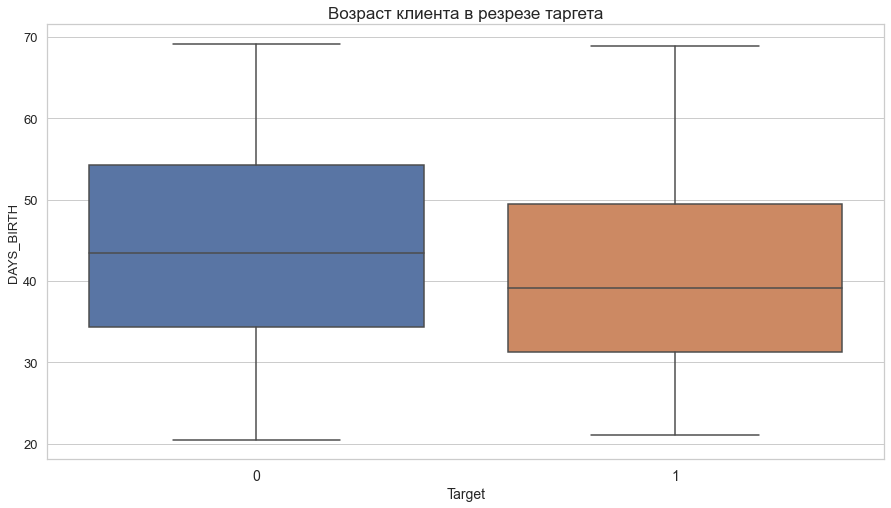

In [12]:
plt.figure(figsize=(15, 8))

sns.set_theme(style="whitegrid")
sns.boxplot(data=appl_train, y=(abs(appl_train['DAYS_BIRTH']) / 365), x='TARGET')

plt.xlabel('Target', fontsize=14)
plt.ylabel('DAYS_BIRTH', fontsize=13)
plt.xticks(fontsize=14)
plt.yticks(fontsize=13)
plt.title('Возраст клиента в резрезе таргета', fontsize=17)

plt.show()

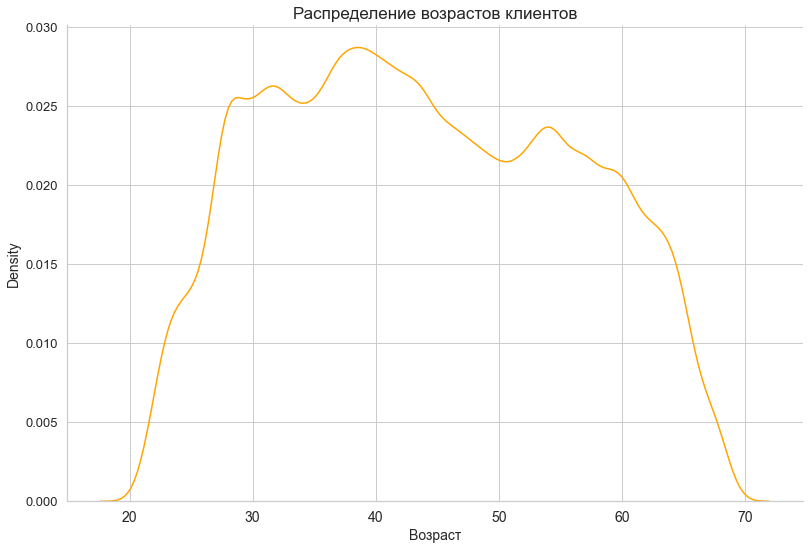

In [13]:
sns.set_theme(style="whitegrid")
displot = sns.displot(x=(abs(appl_train.DAYS_BIRTH) / 365), kind='kde', color='orange')

displot.fig.set_figheight(8)
displot.fig.set_figwidth(13)

plt.xticks(fontsize=14)
plt.yticks(fontsize=13)
plt.xlabel('Возраст', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Распределение возрастов клиентов', fontsize=17)

plt.show()

Интерквартильный размах 34-54 года, средний возраст около 43 лет. Можно заметить, что просрочка по кредиту свойственна более молодым заемщикам, средний возраст меньше 40 лет.

## Типы выдаваемых кредитов

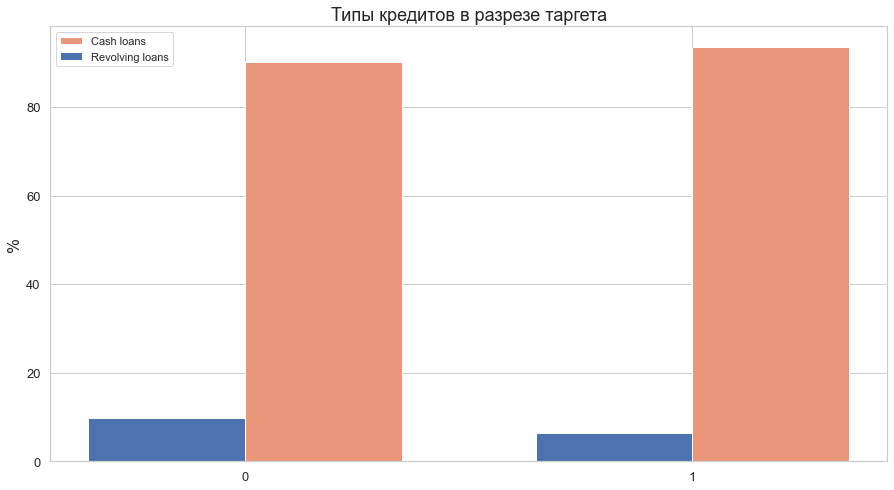

In [14]:
# Нормируем данные

target_group = appl_train.groupby(['TARGET', 'NAME_CONTRACT_TYPE'])['TARGET'].count()
all_count = appl_train.groupby('TARGET')['NAME_CONTRACT_TYPE'].count()
norma = (target_group / all_count) * 100

# Строим график по нормированным данным

fig, ax = plt.subplots(figsize=(15, 8))
x = np.arange(len(norma[0].index))
width = 0.35

ax.bar(x=x + width/2, height=(norma[0][0], norma[1][0]), width=0.35, label='Cash loans', color='darksalmon')
ax.bar(x=x - width/2, height=(norma[0][1], norma[1][1]), width=0.35, label='Revolving loans')

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.set_ylabel('%', fontsize=17)
ax.set_title('Типы кредитов в разрезе таргета', fontsize=18)
ax.set_xticks(x)
ax.legend();

Большую часть кредитов банк выдает частным лицам

## Наличие имущества у заемщика

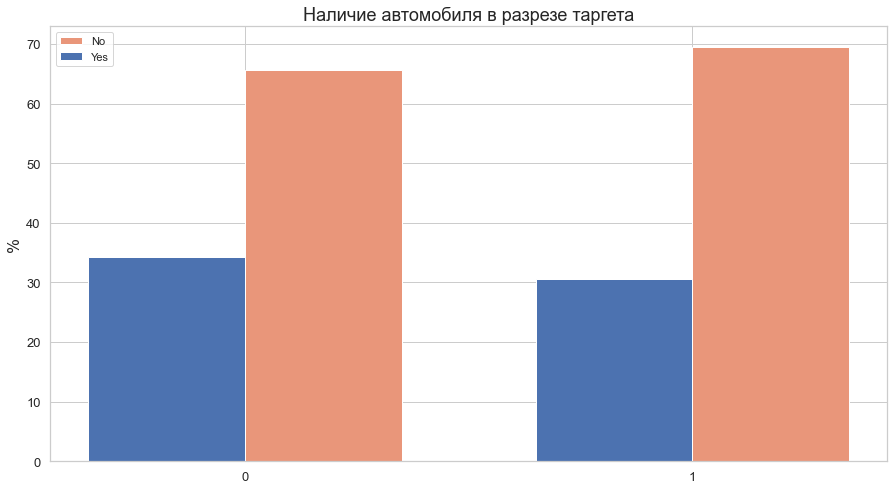

In [15]:
# Нормируем данные

target_group = appl_train.groupby(['TARGET', 'FLAG_OWN_CAR'])['TARGET'].count()
all_count = appl_train.groupby('TARGET')['FLAG_OWN_CAR'].count()
norma = (target_group / all_count) * 100

# Строим график по нормированным данным

fig, ax = plt.subplots(figsize=(15, 8))
x = np.arange(len(norma[0].index))
width = 0.35

ax.bar(x=x + width/2, height=(norma[0][0], norma[1][0]), width=0.35, label='No', color='darksalmon')
ax.bar(x=x - width/2, height=(norma[0][1], norma[1][1]), width=0.35, label='Yes')

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.set_ylabel('%', fontsize=17)
ax.set_title('Наличие автомобиля в разрезе таргета', fontsize=18)
ax.set_xticks(x)
ax.legend();

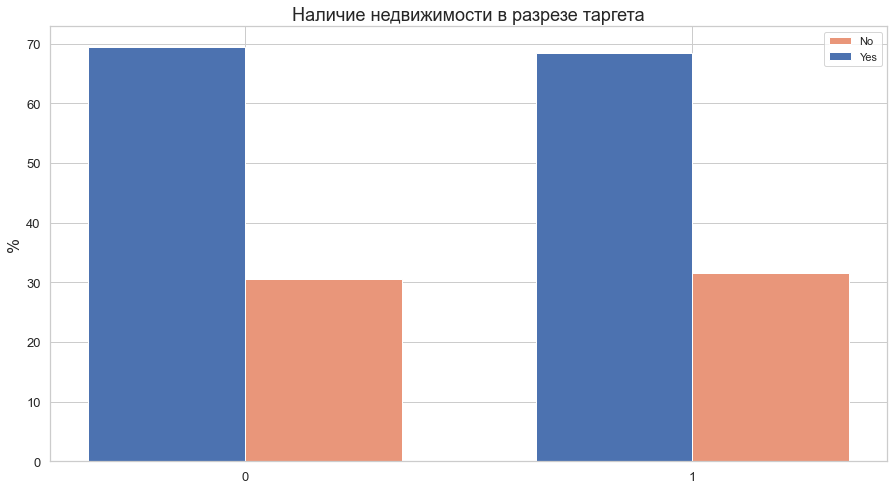

In [16]:
# Нормируем данные

target_group = appl_train.groupby(['TARGET', 'FLAG_OWN_REALTY'])['TARGET'].count()
all_count = appl_train.groupby('TARGET')['FLAG_OWN_REALTY'].count()
norma = (target_group / all_count) * 100

# Строим график по нормированным данным

fig, ax = plt.subplots(figsize=(15, 8))
x = np.arange(len(norma[0].index))
width = 0.35

ax.bar(x=x + width/2, height=(norma[0][0], norma[1][0]), width=0.35, label='No', color='darksalmon')
ax.bar(x=x - width/2, height=(norma[0][1], norma[1][1]), width=0.35, label='Yes')

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.set_ylabel('%', fontsize=17)
ax.set_title('Наличие недвижимости в разрезе таргета', fontsize=18)
ax.set_xticks(x)
ax.legend();

Преимущественно у людей есть недвижимость, но нет собственной машины

## Виды доходов заемщиков

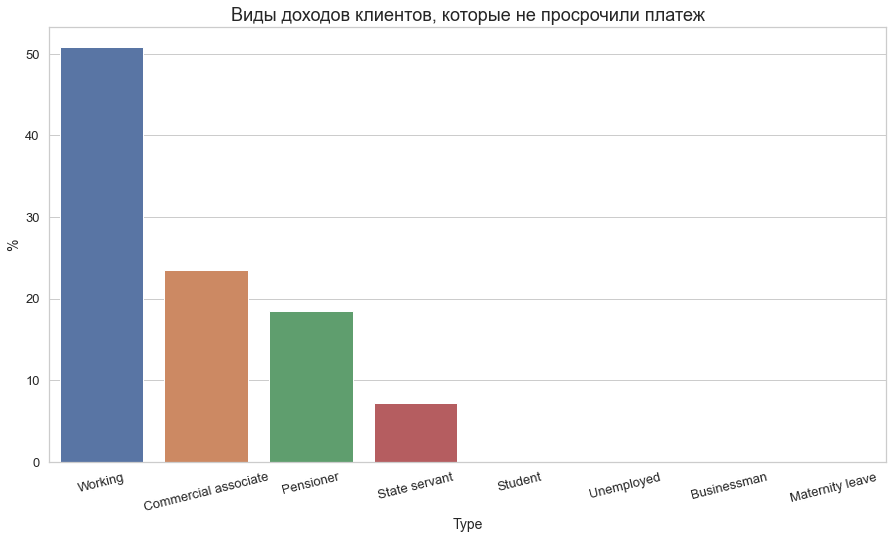

In [17]:
# Нормируем данные

target_group = appl_train.groupby(['TARGET', 'NAME_INCOME_TYPE'])['TARGET'].count()
all_count = appl_train.groupby('TARGET')['NAME_INCOME_TYPE'].count()
norma = ((target_group / all_count) * 100).sort_values(ascending=False)

# Строим график по нормированным данным

plt.figure(figsize=(15, 8))

sns.set_theme(style="whitegrid")
sns.barplot(x=norma[0].index, y=norma[0].sort_values(ascending=False))

plt.xlabel('Type', fontsize=14)
plt.ylabel('%', fontsize=14)
plt.xticks(fontsize=13, rotation=14)
plt.yticks(fontsize=13)
plt.title('Виды доходов клиентов, которые не просрочили платеж', fontsize=18)

plt.show()

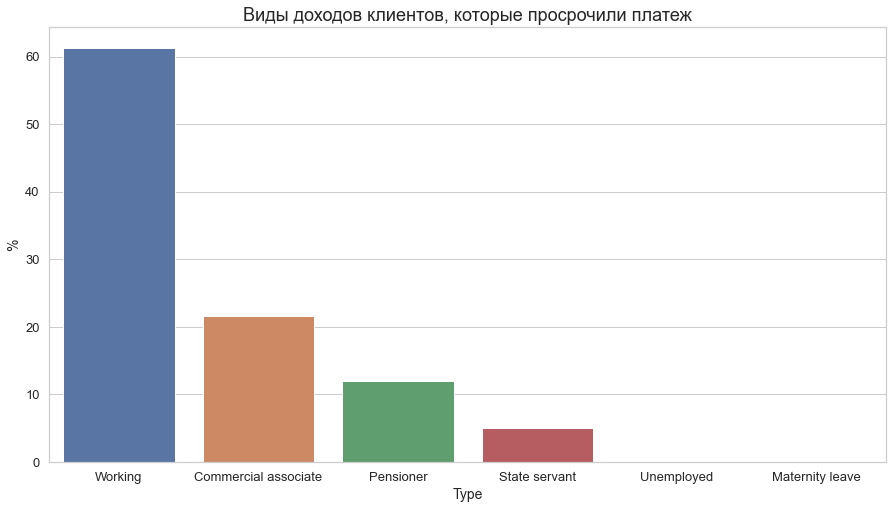

In [18]:
# Нормируем данные

target_group = appl_train.groupby(['TARGET', 'NAME_INCOME_TYPE'])['TARGET'].count()
all_count = appl_train.groupby('TARGET')['NAME_INCOME_TYPE'].count()
norma = ((target_group / all_count) * 100).sort_values(ascending=False)

# Строим график по нормированным данным

plt.figure(figsize=(15, 8))

sns.set_theme(style="whitegrid")
sns.barplot(x=norma[1].index, y=norma[1].sort_values(ascending=False))

plt.xlabel('Type', fontsize=14)
plt.ylabel('%', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('Виды доходов клиентов, которые просрочили платеж', fontsize=18)

plt.show()

Профессия обычного рабочего преобладает как и в просрочке платежа, так и при его возврате в срок

### Статус кредита в разрезе должности клиента

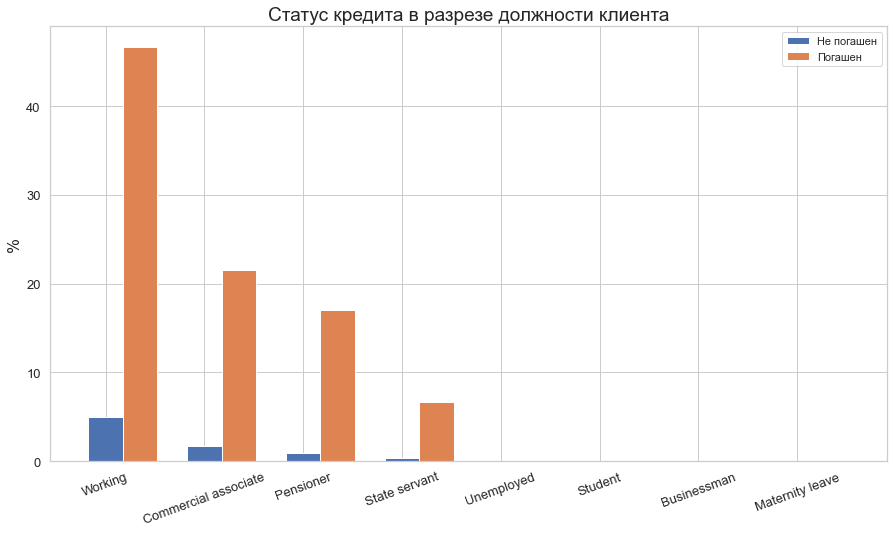

In [19]:
temp = appl_train["NAME_INCOME_TYPE"].value_counts()

temp_y0 = []
temp_y1 = []

for val in temp.index:
    temp_y1.append(np.sum(appl_train["TARGET"][appl_train["NAME_INCOME_TYPE"] == val] == 1))
    temp_y0.append(np.sum(appl_train["TARGET"][appl_train["NAME_INCOME_TYPE"] == val] == 0)) 

fig, ax = plt.subplots(figsize=(15, 8))
x = np.arange(len(temp.index))
width = 0.35

ax.bar(x = temp.index, height = (temp_y1 / temp.sum()) * 100, width=0.35, label='Не погашен')
ax.bar(x = x + width, height = (temp_y0 / temp.sum()) * 100, width=0.35, label='Погашен')
plt.xticks(fontsize=13, rotation=20)
plt.yticks(fontsize=13)
plt.ylabel('%', fontsize=17)
plt.title('Статус кредита в разрезе должности клиента', fontsize=19)
plt.legend()

plt.show()

Распределение клиентов в разрезе задержки платежа / выплаты в срок - равномерное

## Семейное положение клиентов

### Семейное положение клиентов, которые просрочили / не просрочили платеж

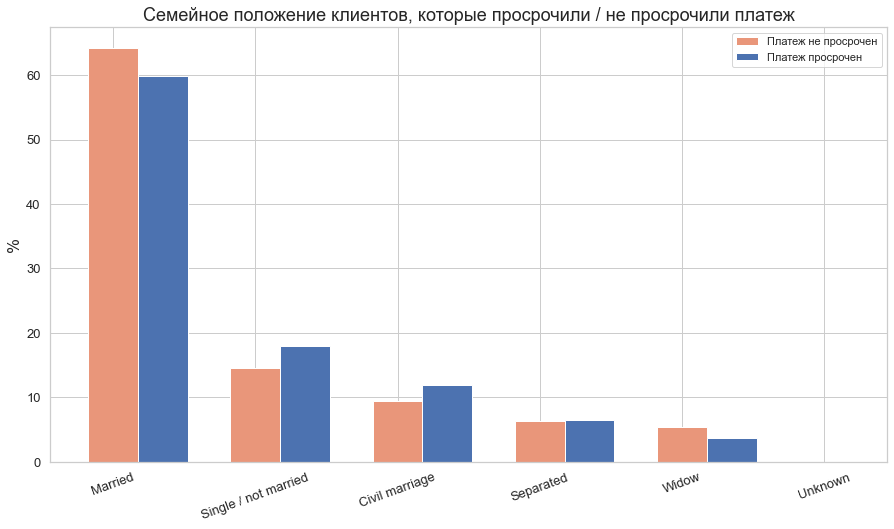

In [20]:
# Нормируем данные на размер класса

target_group = appl_train.groupby(['TARGET', 'NAME_FAMILY_STATUS'])['TARGET'].count()
all_count = appl_train.groupby('TARGET')['NAME_FAMILY_STATUS'].count()
norma = ((target_group / all_count) * 100).sort_values(ascending=False)

# Строим график по нормированным данным

fig, ax = plt.subplots(figsize=(15, 8))
x = np.arange(len(norma[1].index))
width = 0.35

ax.bar(x=norma[0].index, height=(norma[0]), width=0.35, label='Платеж не просрочен', color='darksalmon')
ax.bar(x=x + width, height=norma[1], width=0.35, label='Платеж просрочен')

plt.xticks(fontsize=13, rotation=20)
plt.yticks(fontsize=13)
ax.set_ylabel('%', fontsize=17)
ax.set_title('Семейное положение клиентов, которые просрочили / не просрочили платеж', fontsize=18)
ax.legend();

Самое популярное семейное положение - замужем/женат

### Статус кредита в разрезе семейного положения

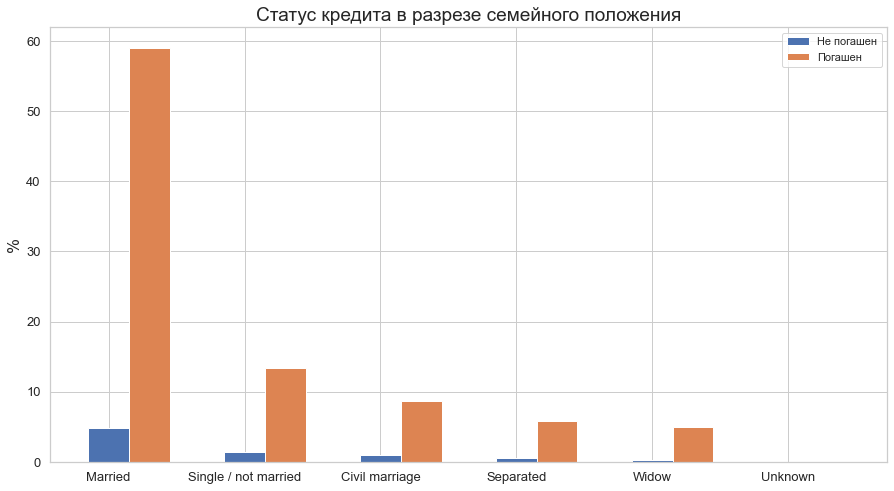

In [21]:
temp = appl_train["NAME_FAMILY_STATUS"].value_counts()

temp_y0 = []
temp_y1 = []

for val in temp.index:
    temp_y1.append(np.sum(appl_train["TARGET"][appl_train["NAME_FAMILY_STATUS"] == val] == 1))
    temp_y0.append(np.sum(appl_train["TARGET"][appl_train["NAME_FAMILY_STATUS"] == val] == 0)) 

fig, ax = plt.subplots(figsize=(15, 8))
x = np.arange(len(temp.index))
width = 0.3

ax.bar(x = temp.index, height = (temp_y1 / temp.sum()) * 100, width=0.3, label='Не погашен')
ax.bar(x = x + width, height = (temp_y0 / temp.sum()) * 100, width=0.3, label='Погашен')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel('%', fontsize=17)
plt.title('Статус кредита в разрезе семейного положения', fontsize=19)
plt.legend()

plt.show()

Распределение клиентов в разрезе задержки платежа / выплаты в срок - равномерное

## Сферы деятельности заемщиков

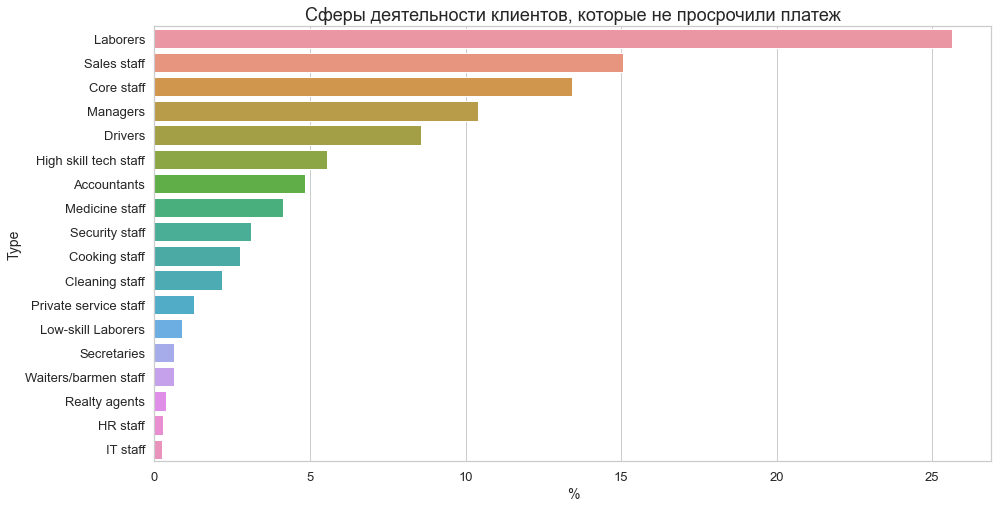

In [22]:
# Нормируем данные

target_group = appl_train.groupby(['TARGET', 'OCCUPATION_TYPE'])['TARGET'].count()
all_count = appl_train.groupby('TARGET')['OCCUPATION_TYPE'].count()
norma = ((target_group / all_count) * 100).sort_values(ascending=False)

# Строим график по нормированным данным

plt.figure(figsize=(15, 8))

sns.set_theme(style="whitegrid")
sns.barplot(y=norma[0].index, x=norma[0].sort_values(ascending=False))

plt.xlabel('%', fontsize=14)
plt.ylabel('Type', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('Сферы деятельности клиентов, которые не просрочили платеж', fontsize=18)

plt.show()

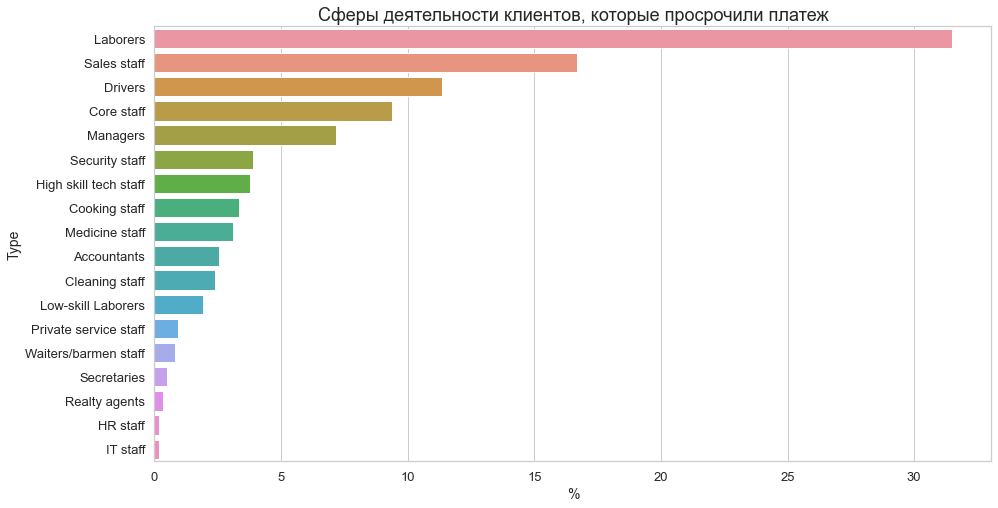

In [23]:
# Нормируем данные

target_group = appl_train.groupby(['TARGET', 'OCCUPATION_TYPE'])['TARGET'].count()
all_count = appl_train.groupby('TARGET')['OCCUPATION_TYPE'].count()
norma = ((target_group / all_count) * 100).sort_values(ascending=False)

# Строим график по нормированным данным

plt.figure(figsize=(15, 8))

sns.set_theme(style="whitegrid")
sns.barplot(y=norma[1].index, x=norma[1].sort_values(ascending=False))

plt.xlabel('%', fontsize=14)
plt.ylabel('Type', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('Сферы деятельности клиентов, которые просрочили платеж', fontsize=18)

plt.show()

Сильно выделяется группа неквалифицированных рабочих. Далее идут продавцы, менеджеры, основной персонал и тд

### Статус кредита в разрезе сферы деятельности

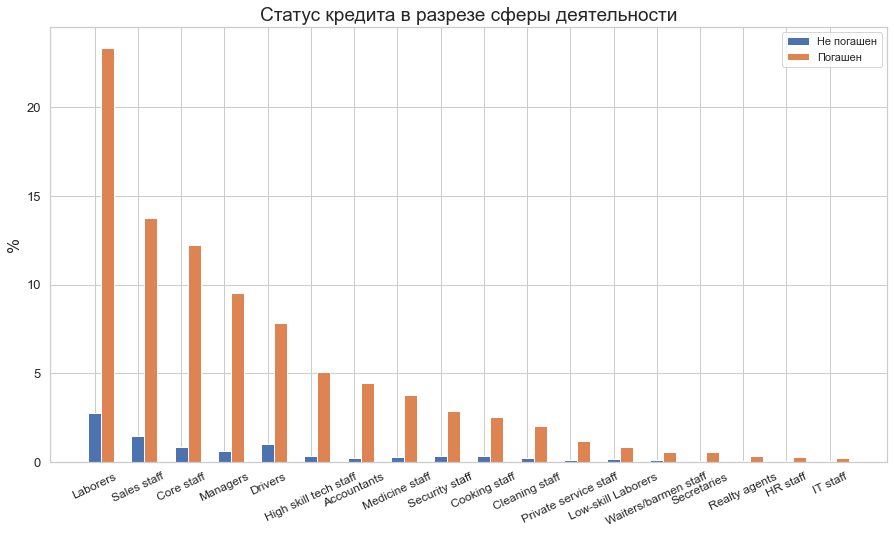

In [24]:
temp = appl_train['OCCUPATION_TYPE'].value_counts()

temp_y0 = []
temp_y1 = []

for val in temp.index:
    temp_y1.append(np.sum(appl_train["TARGET"][appl_train["OCCUPATION_TYPE"] == val] == 1))
    temp_y0.append(np.sum(appl_train["TARGET"][appl_train["OCCUPATION_TYPE"] == val] == 0)) 

fig, ax = plt.subplots(figsize=(15, 8))
x = np.arange(len(temp.index))
width = 0.3

ax.bar(x = temp.index, height = (temp_y1 / temp.sum()) * 100, width=0.3, label='Не погашен')
ax.bar(x = x + width, height = (temp_y0 / temp.sum()) * 100, width=0.3, label='Погашен')
plt.xticks(fontsize=12, rotation=25)
plt.yticks(fontsize=13)
plt.ylabel('%', fontsize=17)
plt.title('Статус кредита в разрезе сферы деятельности', fontsize=19)
plt.legend()

plt.show()

Распределение клиентов в разрезе задержки платежа / выплаты в срок - равномерное

## Наличие образования

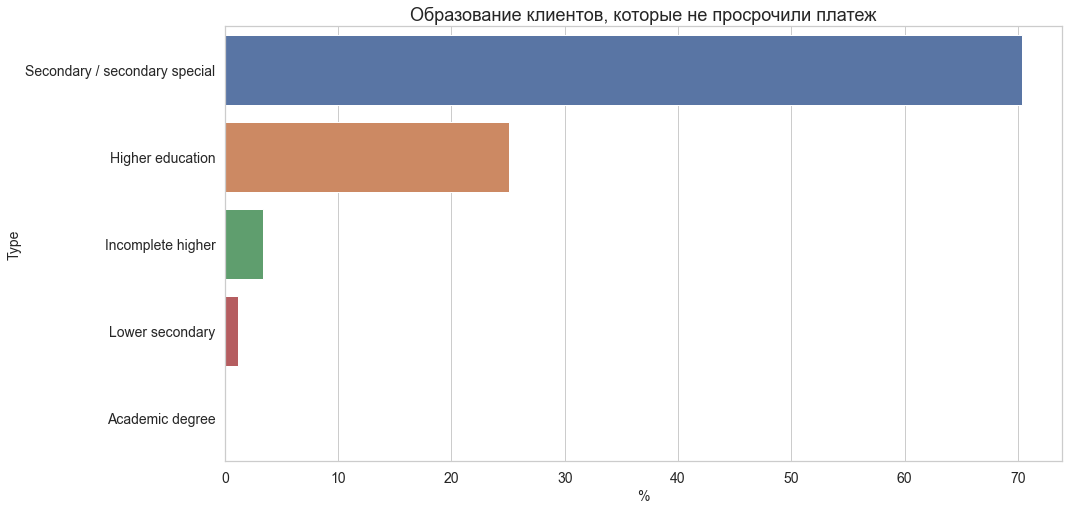

In [25]:
# Нормируем данные

target_group = appl_train.groupby(['TARGET', 'NAME_EDUCATION_TYPE'])['TARGET'].count()
all_count = appl_train.groupby('TARGET')['NAME_EDUCATION_TYPE'].count()
norma = ((target_group / all_count) * 100).sort_values(ascending=False)

# Строим график по нормированным данным

plt.figure(figsize=(15, 8))

sns.set_theme(style="whitegrid")
sns.barplot(y=norma[0].index, x=norma[0].sort_values(ascending=False))

plt.xlabel('%', fontsize=14)
plt.ylabel('Type', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Образование клиентов, которые не просрочили платеж', fontsize=18)

plt.show()

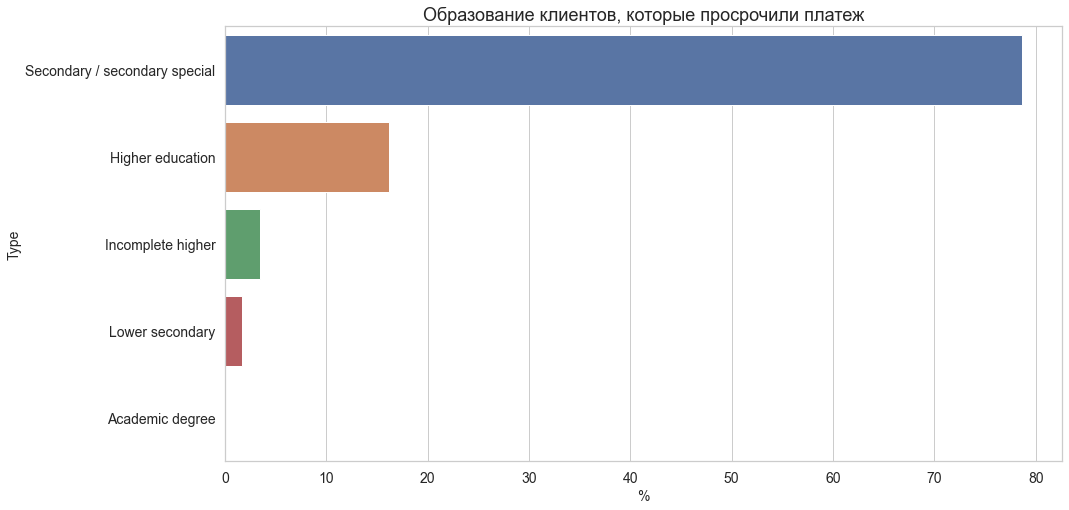

In [26]:
# Нормируем данные

target_group = appl_train.groupby(['TARGET', 'NAME_EDUCATION_TYPE'])['TARGET'].count()
all_count = appl_train.groupby('TARGET')['NAME_EDUCATION_TYPE'].count()
norma = ((target_group / all_count) * 100).sort_values(ascending=False)

# Строим график по нормированным данным

plt.figure(figsize=(15, 8))

sns.set_theme(style="whitegrid")
sns.barplot(y=norma[1].index, x=norma[1].sort_values(ascending=False))

plt.xlabel('%', fontsize=14)
plt.ylabel('Type', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Образование клиентов, которые просрочили платеж', fontsize=18)

plt.show()

Исходя из предыдущего графика, можно подтвердить гипотезу о том, что основными клиентами банка являются мало квалифицированные рабочие со средним образованием. Но также можно отметить заметную долю клиентов (~16%) с высшим образванием

### Статус кредита в разрезе образования

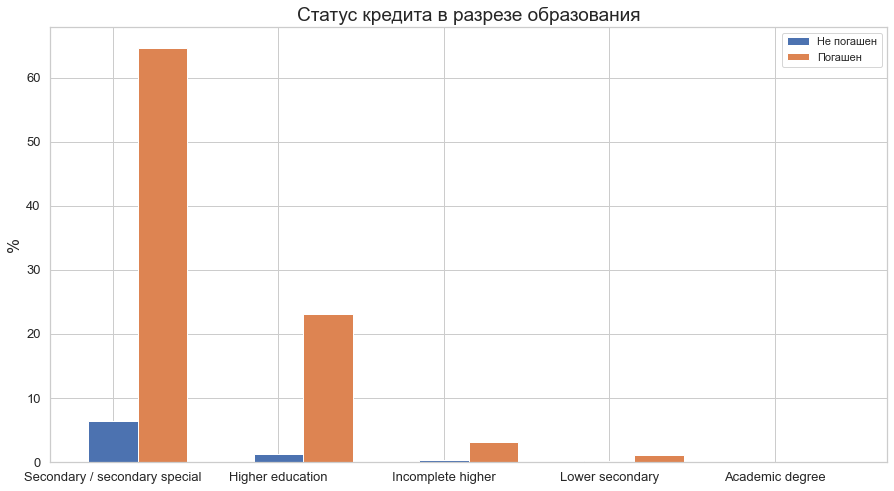

In [27]:
temp = appl_train['NAME_EDUCATION_TYPE'].value_counts()

temp_y0 = []
temp_y1 = []

for val in temp.index:
    temp_y1.append(np.sum(appl_train["TARGET"][appl_train["NAME_EDUCATION_TYPE"] == val] == 1))
    temp_y0.append(np.sum(appl_train["TARGET"][appl_train["NAME_EDUCATION_TYPE"] == val] == 0)) 

fig, ax = plt.subplots(figsize=(15, 8))
x = np.arange(len(temp.index))
width = 0.3

ax.bar(x = temp.index, height = (temp_y1 / temp.sum()) * 100, width=0.3, label='Не погашен')
ax.bar(x = x + width, height = (temp_y0 / temp.sum()) * 100, width=0.3, label='Погашен')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel('%', fontsize=17)
plt.title('Статус кредита в разрезе образования', fontsize=19)
plt.legend()

plt.show()

Распределение клиентов в разрезе задержки платежа / выплаты в срок - равномерное

## Тип дома в котором проживает клиент

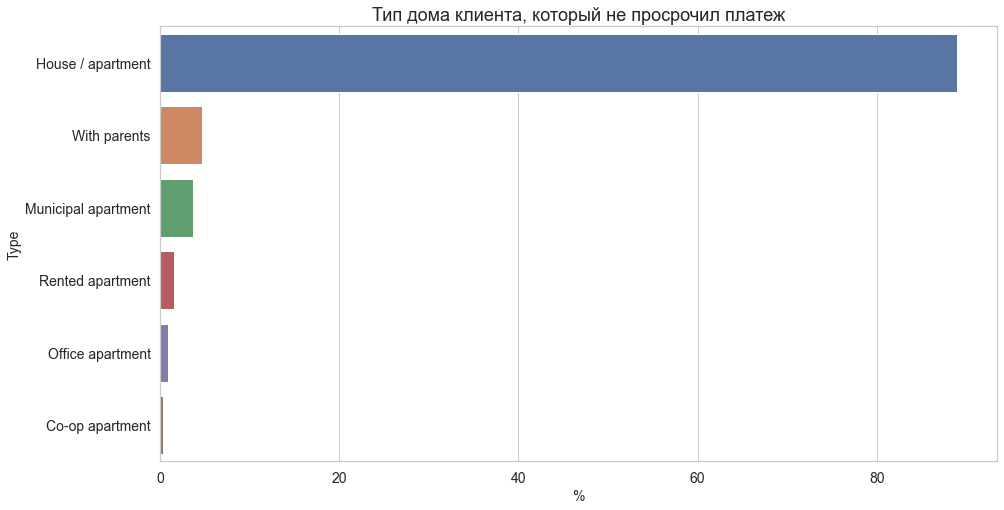

In [28]:
# Нормируем данные

target_group = appl_train.groupby(['TARGET', 'NAME_HOUSING_TYPE'])['TARGET'].count()
all_count = appl_train.groupby('TARGET')['NAME_HOUSING_TYPE'].count()
norma = ((target_group / all_count) * 100).sort_values(ascending=False)

# Строим график по нормированным данным

plt.figure(figsize=(15, 8))

sns.set_theme(style="whitegrid")
sns.barplot(y=norma[0].index, x=norma[0].sort_values(ascending=False))

plt.xlabel('%', fontsize=14)
plt.ylabel('Type', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Тип дома клиента, который не просрочил платеж', fontsize=18)

plt.show()

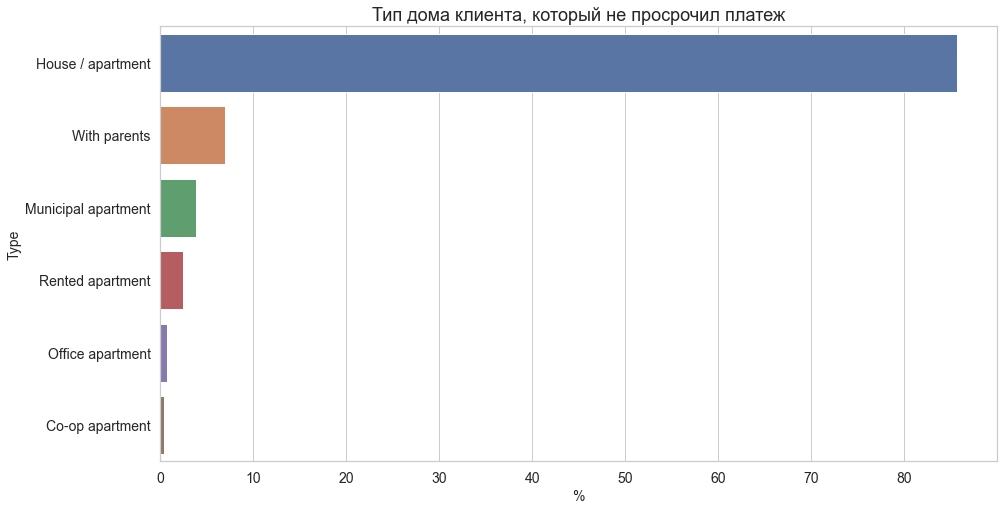

In [29]:
# Нормируем данные

target_group = appl_train.groupby(['TARGET', 'NAME_HOUSING_TYPE'])['TARGET'].count()
all_count = appl_train.groupby('TARGET')['NAME_HOUSING_TYPE'].count()
norma = ((target_group / all_count) * 100).sort_values(ascending=False)

# Строим график по нормированным данным

plt.figure(figsize=(15, 8))

sns.set_theme(style="whitegrid")
sns.barplot(y=norma[1].index, x=norma[1].sort_values(ascending=False))

plt.xlabel('%', fontsize=14)
plt.ylabel('Type', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Тип дома клиента, который не просрочил платеж', fontsize=18)

plt.show()

Почти все заемщики проживают в доме/апартаментах

### Статус кредита в разрезе места проживания заемщика

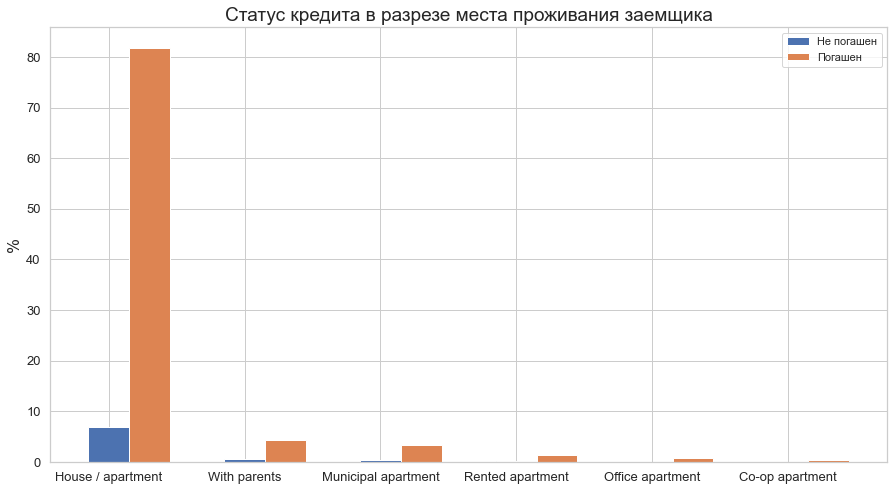

In [30]:
temp = appl_train['NAME_HOUSING_TYPE'].value_counts()

temp_y0 = []
temp_y1 = []

for val in temp.index:
    temp_y1.append(np.sum(appl_train["TARGET"][appl_train["NAME_HOUSING_TYPE"] == val] == 1))
    temp_y0.append(np.sum(appl_train["TARGET"][appl_train["NAME_HOUSING_TYPE"] == val] == 0)) 

fig, ax = plt.subplots(figsize=(15, 8))
x = np.arange(len(temp.index))
width = 0.3

ax.bar(x = temp.index, height = (temp_y1 / temp.sum()) * 100, width=0.3, label='Не погашен')
ax.bar(x = x + width, height = (temp_y0 / temp.sum()) * 100, width=0.3, label='Погашен')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel('%', fontsize=17)
plt.title('Статус кредита в разрезе места проживания заемщика', fontsize=19)
plt.legend()

plt.show()

Распределение клиентов в разрезе задержки платежа / выплаты в срок - равномерное

# Feature Engineering

In [31]:
# Создаем набор новых фичей на train

# Процент отработанных дней в разрезе возраста клиента
appl_train['DAYS_EMPLOYED_PERCENT'] = appl_train['DAYS_EMPLOYED'] / \
    appl_train['DAYS_BIRTH']

# Процент суммы кредита в разрезе дохода клиента
appl_train['CREDIT_INCOME_PERCENT'] = appl_train['AMT_CREDIT'] / \
    appl_train['AMT_INCOME_TOTAL']

# Продолжительность платежа в месяцах
appl_train['CREDIT_TERM'] = appl_train['AMT_ANNUITY'] / \
    appl_train['AMT_CREDIT']

# Возраст клиента в кол-ве лет
appl_train['DAYS_BIRTH'] = abs(appl_train['DAYS_BIRTH'] / 365)

# Кредитные коэффициенты
appl_train['CREDIT_TO_ANNUITY_RATIO'] = appl_train['AMT_CREDIT'] / \
    appl_train['AMT_ANNUITY']
appl_train['CREDIT_TO_GOODS_RATIO'] = appl_train['AMT_CREDIT'] / \
    appl_train['AMT_GOODS_PRICE']

# Коэффициенты доходов
appl_train['ANNUITY_TO_INCOME_RATIO'] = appl_train['AMT_ANNUITY'] / \
    appl_train['AMT_INCOME_TOTAL']
appl_train['CREDIT_TO_INCOME_RATIO'] = appl_train['AMT_CREDIT'] / \
    appl_train['AMT_INCOME_TOTAL']
appl_train['INCOME_TO_BIRTH_RATIO'] = appl_train['AMT_INCOME_TOTAL'] / \
    appl_train['DAYS_BIRTH']

In [32]:
# Создаем новые фичи в тестовых данных

appl_test['DAYS_EMPLOYED_PERCENT'] = appl_test['DAYS_EMPLOYED'] / \
    appl_test['DAYS_BIRTH']

appl_test['CREDIT_INCOME_PERCENT'] = appl_test['AMT_CREDIT'] / \
    appl_test['AMT_INCOME_TOTAL']

appl_test['CREDIT_TERM'] = appl_test['AMT_ANNUITY'] / \
    appl_test['AMT_CREDIT']

appl_test['DAYS_BIRTH'] = abs(appl_test['DAYS_BIRTH'] / 365)

appl_test['CREDIT_TO_ANNUITY_RATIO'] = appl_test['AMT_CREDIT'] / \
    appl_test['AMT_ANNUITY']
appl_test['CREDIT_TO_GOODS_RATIO'] = appl_test['AMT_CREDIT'] / \
    appl_test['AMT_GOODS_PRICE']

appl_test['ANNUITY_TO_INCOME_RATIO'] = appl_test['AMT_ANNUITY'] / \
    appl_test['AMT_INCOME_TOTAL']
appl_test['CREDIT_TO_INCOME_RATIO'] = appl_test['AMT_CREDIT'] / \
    appl_test['AMT_INCOME_TOTAL']
appl_test['INCOME_TO_BIRTH_RATIO'] = appl_test['AMT_INCOME_TOTAL'] / \
    appl_test['DAYS_BIRTH']

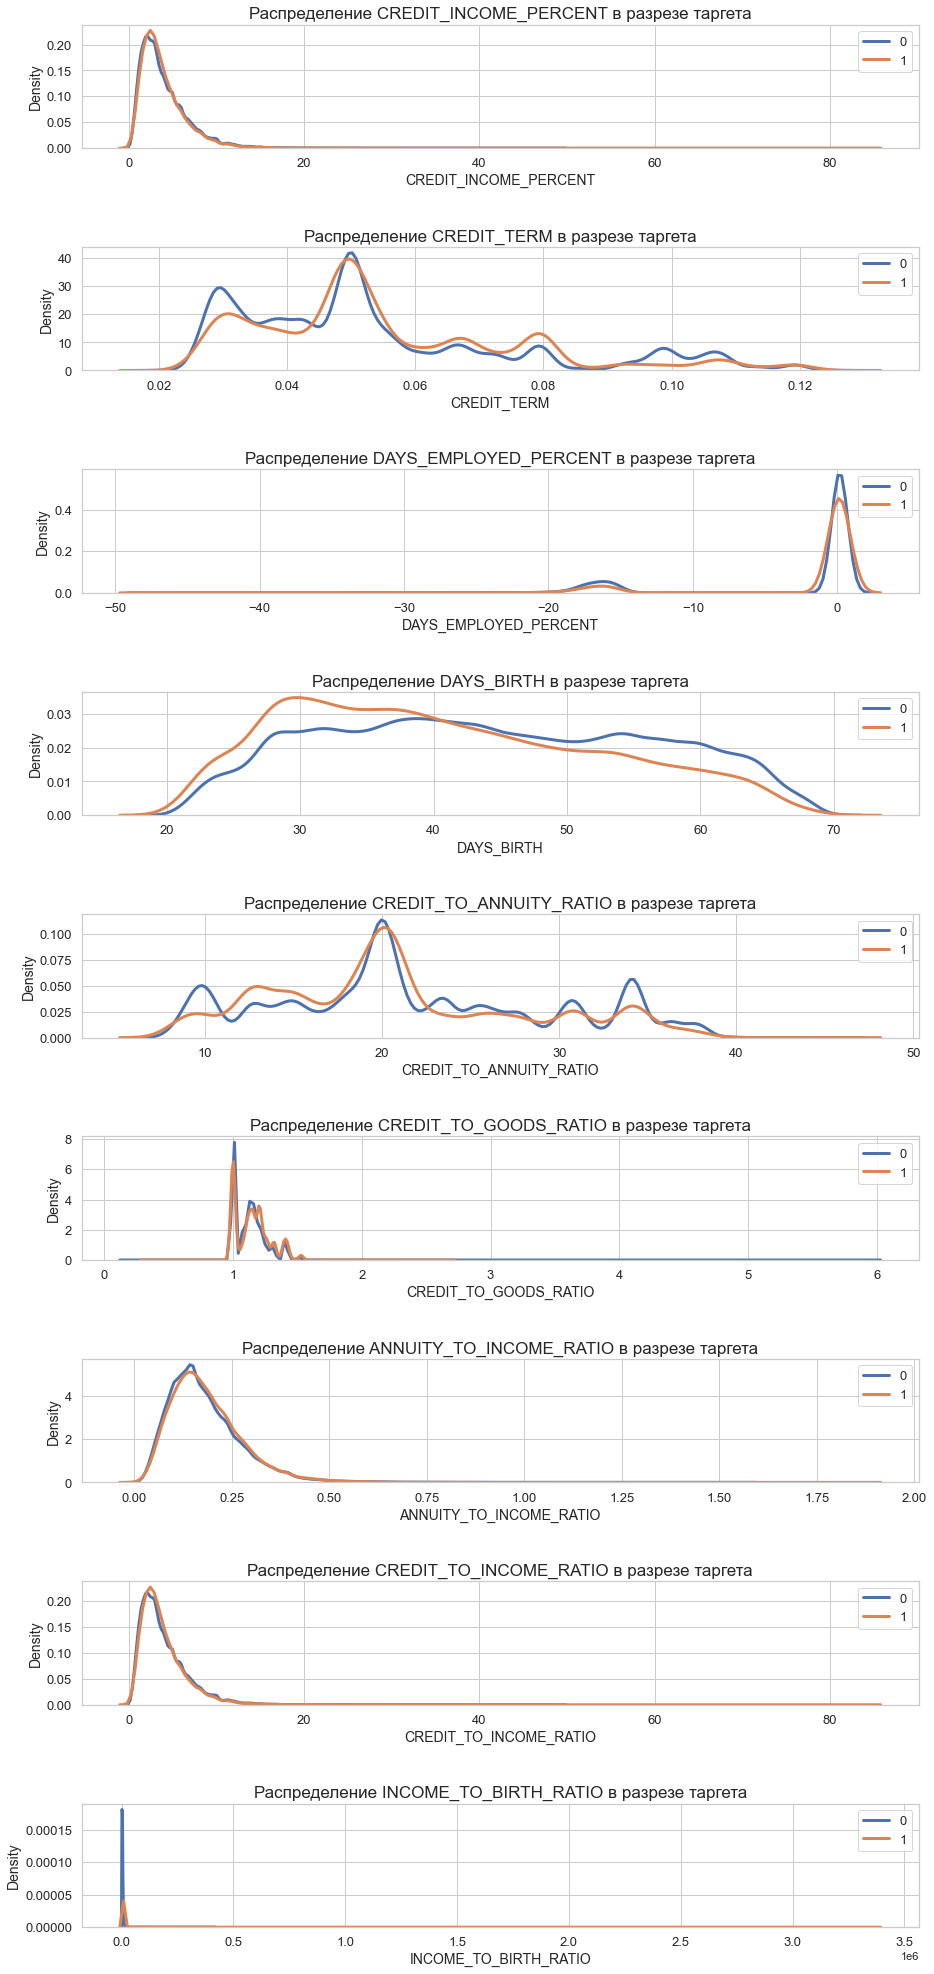

In [33]:
plt.figure(figsize=(15, 35))

# Создадим цикл for для построения графиков наших новых фичей
for num, feature in enumerate(['CREDIT_INCOME_PERCENT', 'CREDIT_TERM', 
                               'DAYS_EMPLOYED_PERCENT', 'DAYS_BIRTH', 
                               'CREDIT_TO_ANNUITY_RATIO', 'CREDIT_TO_GOODS_RATIO',
                               'ANNUITY_TO_INCOME_RATIO', 'CREDIT_TO_INCOME_RATIO',
                               'INCOME_TO_BIRTH_RATIO']):
    
    # Зададим стиль и subplot
    plt.subplot(9, 1, num + 1)
    plt.subplots_adjust(wspace=0.8, hspace=0.8)
    sns.set_theme(style="whitegrid")
    
    # Feature в разрезе таргета = 0
    sns.kdeplot(appl_train.loc[appl_train['TARGET'] == 0, feature], label='0', linewidth=3)
    
    # Feature в разрезе таргета = 1
    sns.kdeplot(appl_train.loc[appl_train['TARGET'] == 1, feature], label='1', linewidth=3)
    
    # Обозначения графиков
    plt.title('Распределение %s в разрезе таргета' % feature, fontsize=17)
    plt.xlabel('%s' % feature, fontsize=14) 
    plt.ylabel('Density', fontsize=14)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.legend(fontsize=13)

# Baseline

In [34]:
# Заполняем пропуски в данных

def func_fill(data):
    if isinstance(data, pd.Series):
        try:
            if data.dtype is pd.np.dtype(float):
                data.fillna(data.median(), inplace=True)
            elif data.dtype is pd.np.dtype(int):
                data.fillna(data.median(), inplace=True)
            elif data.dtype is pd.np.dtype(object):
                data.fillna(data.mode()[0], inplace=True)
            else:
                ('Не нашел указанные типы')
        except Exception as ex:
            print(f'Поздравляю, у тебя ошибка - {ex}')
    else:
        print('Series, не DF -_-')

In [35]:
for col in appl_train.columns:
    func_fill(appl_train[col])
    
for col in appl_test.columns:
    func_fill(appl_test[col])

In [36]:
# DataFrame для записи результатов

metrics = pd.DataFrame(
    index=('ROC-AUC', 'F1', 'Accuracy', 'Precision', 'Recall'))

## Проверка данных на выбросы

In [37]:
# Попробуем найти выбросы

# Бинаризуем полный сет данных
lx_cols = appl_train.dtypes[appl_train.dtypes == 'O'].index.to_list()
lx_train = pd.get_dummies(data=appl_train, columns=lx_cols)

# Разбиваем на train и test
X = lx_train.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = lx_train.TARGET

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, shuffle=True, random_state=RAND)

In [38]:
# Обучаем модель

lg = LogisticRegression(class_weight='balanced')

lg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [39]:
y_proba = lg.predict_proba(X_test)

In [40]:
# Создаем датасеты с данными и выводим

df_test = pd.DataFrame(y_test)
df_proba = pd.DataFrame(y_proba[:, 1:])
df = pd.merge(df_test['TARGET'], df_proba, left_index=True, right_index=True)
df = df.rename(columns = {0: 'probability'})

df.sort_values(by='probability', ascending=False).head(60)

,TARGET,probability
4542,0,0.953897
29684,0,0.937538
26454,0,0.927828
5629,0,0.812600
26876,0,0.794748
51490,0,0.782595
51359,0,0.780005
2520,1,0.776264
14182,0,0.772266
42793,0,0.770768


При вероятности > 0.85 довольно много id с таргетом 0 (вернут кредит). Для лучшего распознавания зависимотей моделью,
запишем их в переменную wrong_indexes_train, для того чтобы удалить и сравнить скоры с исходными данными

In [41]:
# Копируем исходный датасет

outlayers_df = appl_train.copy()

In [42]:
# Записываем наши выбросы в переменную

wrong_indexes_train = df[(df['probability'] > 0.85) & (df['TARGET'] == 0)].index

## Logistic Regression

In [43]:
# Бинаризуем наши данные

lx_cols = appl_train.dtypes[appl_train.dtypes == 'O'].index.to_list()

lx_train = pd.get_dummies(data=appl_train, columns=lx_cols)

In [44]:
# Разбиваем данные на train и test

X = lx_train.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = lx_train.TARGET

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, shuffle=True, random_state=RAND)

In [45]:
# Обучаем модель

lg = LogisticRegression(class_weight='balanced')

lg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [46]:
# Предиктим и смотрим на метрики

y_proba = lg.predict_proba(X_test)
y_pred = lg.predict(X_test)

metrics['LogisticRegression'] = ((roc_auc_score(y_test, y_proba[:, 1:]),
                                  f1_score(y_test, y_pred),
                                  accuracy_score(y_test, y_pred),
                                  precision_score(y_test, y_pred),
                                  recall_score(y_test, y_pred)))

print(f'ROC-AUC = {roc_auc_score(y_test, y_proba[:, 1:])}')
print(f'F1 = {f1_score(y_test, y_pred)}')
print(f'Accuracy = {accuracy_score(y_test, y_pred)}')
print(f'Precision = {precision_score(y_test, y_pred)}')
print(f'Recall = {recall_score(y_test, y_pred)}')

ROC-AUC = 0.6202324260912024
F1 = 0.19216928170433278
Accuracy = 0.6350096743248297
Precision = 0.11698724970424572
Recall = 0.5377643504531722


In [47]:
# Делаем кросс-валидацию

folds = StratifiedShuffleSplit(n_splits=3, test_size=0.2)
scores = cross_val_score(lg, X, y, scoring='roc_auc', cv=folds)

print(f"ShuffleSplit = {np.abs(scores)}")

ShuffleSplit = [0.62143598 0.6092964  0.61035005]


Теперь пробуем удалить выбросы и посмотреть на скор

In [48]:
outlayers_df = outlayers_df.drop(wrong_indexes_train, axis=0)

In [49]:
# Бинаризуем наши данные

lx_cols = outlayers_df.dtypes[outlayers_df.dtypes == 'O'].index.to_list()

lx_train = pd.get_dummies(data=outlayers_df, columns=lx_cols)

In [50]:
# Разбиваем данные на train и test

X = lx_train.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = lx_train.TARGET

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, shuffle=True, random_state=RAND)

In [51]:
# Обучаем модель

lg = LogisticRegression(class_weight='balanced')

lg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [52]:
# Предиктим и смотрим на метрики

y_proba = lg.predict_proba(X_test)
y_pred = lg.predict(X_test)

metrics['LogisticRegression'] = ((roc_auc_score(y_test, y_proba[:, 1:]),
                                  f1_score(y_test, y_pred),
                                  accuracy_score(y_test, y_pred),
                                  precision_score(y_test, y_pred),
                                  recall_score(y_test, y_pred)))

print(f'ROC-AUC = {roc_auc_score(y_test, y_proba[:, 1:])}')
print(f'F1 = {f1_score(y_test, y_pred)}')
print(f'Accuracy = {accuracy_score(y_test, y_pred)}')
print(f'Precision = {precision_score(y_test, y_pred)}')
print(f'Recall = {recall_score(y_test, y_pred)}')

ROC-AUC = 0.6196545209964275
F1 = 0.1923209723085422
Accuracy = 0.6196546453773861
Precision = 0.11605617368837771
Recall = 0.5609264853977844


In [53]:
# Делаем кросс-валидацию

folds = StratifiedShuffleSplit(n_splits=3, test_size=0.2)
scores = cross_val_score(lg, X, y, scoring='roc_auc', cv=folds)

print(f"ShuffleSplit = {np.abs(scores)}")

ShuffleSplit = [0.61888158 0.61359391 0.61525697]


## XGBClassifier

In [54]:
# Бинаризуем наши данные

lx_cols = appl_train.dtypes[appl_train.dtypes == 'O'].index.to_list()

lx_train = pd.get_dummies(data=appl_train, columns=lx_cols)

In [55]:
# Разбиваем данные на train и test

X = lx_train.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = lx_train.TARGET

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, shuffle=True, random_state=RAND)

In [56]:
# Обучаем модель

xgb = XGBClassifier(scale_pos_weight=11.5)

eval_set = [(X_test, y_test)]
xgb.fit(X_train, y_train, eval_set=eval_set)

[18:28:49] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.65563
[1]	validation_0-logloss:0.63446
[2]	validation_0-logloss:0.62087
[3]	validation_0-logloss:0.61197
[4]	validation_0-logloss:0.60568
[5]	validation_0-logloss:0.60054
[6]	validation_0-logloss:0.59541
[7]	validation_0-logloss:0.59167
[8]	validation_0-logloss:0.58870
[9]	validation_0-logloss:0.58534
[10]	validation_0-logloss:0.58259
[11]	validation_0-logloss:0.58044
[12]	validation_0-logloss:0.57867
[13]	validation_0-logloss:0.57715
[14]	validation_0-logloss:0.57505
[15]	validation_0-logloss:0.57366
[16]	validation_0-logloss:0.57242
[17]	validation_0-logloss:0.57085
[18]	validation_0-logloss:0.56957
[19

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=11.5, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [57]:
# Делаем предикт и смотрим на метрики

y_proba = xgb.predict_proba(X_test)
y_pred = xgb.predict(X_test)

metrics['XGBClassifier'] = ((roc_auc_score(y_test, y_proba[:, 1:]),
                             f1_score(y_test, y_pred),
                             accuracy_score(y_test, y_pred),
                             precision_score(y_test, y_pred),
                             recall_score(y_test, y_pred)))

print(f'ROC-AUC = {roc_auc_score(y_test, y_proba[:, 1:])}')
print(f'F1 = {f1_score(y_test, y_pred)}')
print(f'Accuracy = {accuracy_score(y_test, y_pred)}')
print(f'Precision = {precision_score(y_test, y_pred)}')
print(f'Recall = {recall_score(y_test, y_pred)}')

ROC-AUC = 0.7507338592903161
F1 = 0.2747666905958363
Accuracy = 0.7371835520218526
Precision = 0.1767592218437915
Recall = 0.6167170191339376


In [58]:
# Делаем кросс-валидацию

folds = StratifiedShuffleSplit(n_splits=3, test_size=0.2)
scores = cross_val_score(xgb, X, y, scoring='roc_auc', cv=folds)

print(f"score ShuffleSplit = {np.abs(scores)}")

[18:30:00] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:31:15] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:32:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

Теперь пробуем удалить выбросы и посмотреть на скор

In [59]:
# Бинаризуем наши данные

lx_cols = outlayers_df.dtypes[outlayers_df.dtypes == 'O'].index.to_list()

lx_train = pd.get_dummies(data=outlayers_df, columns=lx_cols)

In [60]:
# Разбиваем данные на train и test

X = lx_train.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = lx_train.TARGET

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, shuffle=True, random_state=RAND)

In [61]:
# Обучаем модель

xgb = XGBClassifier(scale_pos_weight=11.5)

eval_set = [(X_test, y_test)]
xgb.fit(X_train, y_train, eval_set=eval_set)

[18:33:53] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.65571
[1]	validation_0-logloss:0.63390
[2]	validation_0-logloss:0.62095
[3]	validation_0-logloss:0.61254
[4]	validation_0-logloss:0.60559
[5]	validation_0-logloss:0.59972
[6]	validation_0-logloss:0.59565
[7]	validation_0-logloss:0.59224
[8]	validation_0-logloss:0.58860
[9]	validation_0-logloss:0.58609
[10]	validation_0-logloss:0.58371
[11]	validation_0-logloss:0.58184
[12]	validation_0-logloss:0.57995
[13]	validation_0-logloss:0.57787
[14]	validation_0-logloss:0.57659
[15]	validation_0-logloss:0.57493
[16]	validation_0-logloss:0.57379
[17]	validation_0-logloss:0.57227
[18]	validation_0-logloss:0.57114
[19

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=11.5, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [62]:
# Делаем предикт и смотрим на метрики

y_proba = xgb.predict_proba(X_test)
y_pred = xgb.predict(X_test)

metrics['XGBClassifier'] = ((roc_auc_score(y_test, y_proba[:, 1:]),
                             f1_score(y_test, y_pred),
                             accuracy_score(y_test, y_pred),
                             precision_score(y_test, y_pred),
                             recall_score(y_test, y_pred)))

print(f'ROC-AUC = {roc_auc_score(y_test, y_proba[:, 1:])}')
print(f'F1 = {f1_score(y_test, y_pred)}')
print(f'Accuracy = {accuracy_score(y_test, y_pred)}')
print(f'Precision = {precision_score(y_test, y_pred)}')
print(f'Recall = {recall_score(y_test, y_pred)}')

ROC-AUC = 0.7495742782030771
F1 = 0.27165441995101314
Accuracy = 0.7340736886605314
Precision = 0.17438536306460833
Recall = 0.6143001007049346


In [63]:
# Делаем кросс-валидацию

folds = StratifiedShuffleSplit(n_splits=3, test_size=0.2)
scores = cross_val_score(xgb, X, y, scoring='roc_auc', cv=folds)

print(f"score ShuffleSplit = {np.abs(scores)}")

[18:35:17] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:36:42] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:38:02] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

## LGBMClassifier

In [64]:
# Копируем датасет в новую переменную для LGBM

appl_lgbm = appl_train.copy()

In [65]:
# Переводим данные типа O в category

lgbm_cols = appl_train.dtypes[appl_train.dtypes == 'O'].index.to_list()

appl_lgbm[lgbm_cols] = appl_lgbm[lgbm_cols].astype('category')

In [66]:
# Разбиваем данные на train и test

X = appl_lgbm.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = appl_lgbm.TARGET

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, shuffle=True, random_state=RAND)

In [67]:
# Обучаем модель

lgbm = LGBMClassifier(class_weight='balanced')

eval_set = [(X_test, y_test)]
lgbm.fit(X_train, y_train, eval_set=eval_set)

[1]	valid_0's binary_logloss: 0.679182
[2]	valid_0's binary_logloss: 0.667591
[3]	valid_0's binary_logloss: 0.657825
[4]	valid_0's binary_logloss: 0.649591
[5]	valid_0's binary_logloss: 0.642486
[6]	valid_0's binary_logloss: 0.63636
[7]	valid_0's binary_logloss: 0.631133
[8]	valid_0's binary_logloss: 0.626496
[9]	valid_0's binary_logloss: 0.622458
[10]	valid_0's binary_logloss: 0.618899
[11]	valid_0's binary_logloss: 0.615669
[12]	valid_0's binary_logloss: 0.612738
[13]	valid_0's binary_logloss: 0.609923
[14]	valid_0's binary_logloss: 0.607411
[15]	valid_0's binary_logloss: 0.605185
[16]	valid_0's binary_logloss: 0.603103
[17]	valid_0's binary_logloss: 0.601222
[18]	valid_0's binary_logloss: 0.599615
[19]	valid_0's binary_logloss: 0.597895
[20]	valid_0's binary_logloss: 0.596281
[21]	valid_0's binary_logloss: 0.594809
[22]	valid_0's binary_logloss: 0.593409
[23]	valid_0's binary_logloss: 0.591903
[24]	valid_0's binary_logloss: 0.590518
[25]	valid_0's binary_logloss: 0.589231
[26]	valid

LGBMClassifier(class_weight='balanced')

In [68]:
# Делаем предикт и смотрим на метрики

y_proba = lgbm.predict_proba(X_test)
y_pred = lgbm.predict(X_test)

metrics['LGBMClassifier'] = ((roc_auc_score(y_test, y_proba[:, 1:]),
                              f1_score(y_test, y_pred),
                              accuracy_score(y_test, y_pred),
                              precision_score(y_test, y_pred),
                              recall_score(y_test, y_pred)))

print(f'ROC-AUC = {roc_auc_score(y_test, y_proba[:, 1:])}')
print(f'F1 = {f1_score(y_test, y_pred)}')
print(f'Accuracy = {accuracy_score(y_test, y_pred)}')
print(f'Precision = {precision_score(y_test, y_pred)}')
print(f'Recall = {recall_score(y_test, y_pred)}')

ROC-AUC = 0.7602195559229081
F1 = 0.27406822620185317
Accuracy = 0.715932556135473
Precision = 0.17265207831640667
Recall = 0.6642497482376637


In [69]:
# Делаем кросс-валидацию

folds = StratifiedShuffleSplit(n_splits=3, test_size=0.2)
scores = cross_val_score(lgbm, X, y, scoring='roc_auc', cv=folds)

print(f"score ShuffleSplit = {np.abs(scores)}")

score ShuffleSplit = [0.76242644 0.76446171 0.75904903]


Теперь пробуем удалить выбросы и посмотреть на скор

In [70]:
# Копируем датасет в новую переменную для LGBM

appl_lgbm = outlayers_df.copy()

In [71]:
# Переводим данные типа O в category

lgbm_cols = outlayers_df.dtypes[outlayers_df.dtypes == 'O'].index.to_list()

appl_lgbm[lgbm_cols] = appl_lgbm[lgbm_cols].astype('category')

In [72]:
# Разбиваем данные на train и test

X = appl_lgbm.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = appl_lgbm.TARGET

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, shuffle=True, random_state=RAND)

In [73]:
# Обучаем модель

lgbm = LGBMClassifier(class_weight='balanced')

eval_set = [(X_test, y_test)]
lgbm.fit(X_train, y_train, eval_set=eval_set)

[1]	valid_0's binary_logloss: 0.679113
[2]	valid_0's binary_logloss: 0.667529
[3]	valid_0's binary_logloss: 0.657823
[4]	valid_0's binary_logloss: 0.649631
[5]	valid_0's binary_logloss: 0.642444
[6]	valid_0's binary_logloss: 0.636528
[7]	valid_0's binary_logloss: 0.631228
[8]	valid_0's binary_logloss: 0.626698
[9]	valid_0's binary_logloss: 0.62259
[10]	valid_0's binary_logloss: 0.619137
[11]	valid_0's binary_logloss: 0.615944
[12]	valid_0's binary_logloss: 0.613036
[13]	valid_0's binary_logloss: 0.610361
[14]	valid_0's binary_logloss: 0.608068
[15]	valid_0's binary_logloss: 0.605889
[16]	valid_0's binary_logloss: 0.603568
[17]	valid_0's binary_logloss: 0.60156
[18]	valid_0's binary_logloss: 0.59985
[19]	valid_0's binary_logloss: 0.598259
[20]	valid_0's binary_logloss: 0.596657
[21]	valid_0's binary_logloss: 0.595211
[22]	valid_0's binary_logloss: 0.593731
[23]	valid_0's binary_logloss: 0.592282
[24]	valid_0's binary_logloss: 0.591111
[25]	valid_0's binary_logloss: 0.589949
[26]	valid_0

LGBMClassifier(class_weight='balanced')

In [74]:
# Делаем предикт и смотрим на метрики

y_proba = lgbm.predict_proba(X_test)
y_pred = lgbm.predict(X_test)

metrics['LGBMClassifier'] = ((roc_auc_score(y_test, y_proba[:, 1:]),
                              f1_score(y_test, y_pred),
                              accuracy_score(y_test, y_pred),
                              precision_score(y_test, y_pred),
                              recall_score(y_test, y_pred)))

print(f'ROC-AUC = {roc_auc_score(y_test, y_proba[:, 1:])}')
print(f'F1 = {f1_score(y_test, y_pred)}')
print(f'Accuracy = {accuracy_score(y_test, y_pred)}')
print(f'Precision = {precision_score(y_test, y_pred)}')
print(f'Recall = {recall_score(y_test, y_pred)}')

ROC-AUC = 0.7605269573574265
F1 = 0.27439557238566853
Accuracy = 0.7164807648531755
Precision = 0.1729256267701668
Recall = 0.66404833836858


In [75]:
# Делаем кросс-валидацию

folds = StratifiedShuffleSplit(n_splits=3, test_size=0.2)
scores = cross_val_score(lgbm, X, y, scoring='roc_auc', cv=folds)

print(f"score ShuffleSplit = {np.abs(scores)}")

score ShuffleSplit = [0.76047743 0.76403604 0.75889989]


## CatBoostClassifier

In [76]:
# Разбиваем данные на train и test

X = appl_train.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = appl_train.TARGET

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, shuffle=True, random_state=RAND)

In [77]:
# Обучаем модель

cat_col = appl_train.dtypes[appl_train.dtypes == 'O'].index.to_list()

cat = CatBoostClassifier(cat_features=cat_col, verbose=True, 
                         auto_class_weights='Balanced')

eval_set = [(X_test, y_test)]
cat.fit(X_train, y_train, eval_set=eval_set)

Learning rate set to 0.123445
0:	learn: 0.6761932	test: 0.6767427	best: 0.6767427 (0)	total: 257ms	remaining: 4m 16s
1:	learn: 0.6637139	test: 0.6643007	best: 0.6643007 (1)	total: 405ms	remaining: 3m 21s
2:	learn: 0.6535126	test: 0.6544731	best: 0.6544731 (2)	total: 583ms	remaining: 3m 13s
3:	learn: 0.6448021	test: 0.6460364	best: 0.6460364 (3)	total: 727ms	remaining: 3m 1s
4:	learn: 0.6377176	test: 0.6391766	best: 0.6391766 (4)	total: 929ms	remaining: 3m 4s
5:	learn: 0.6320199	test: 0.6336784	best: 0.6336784 (5)	total: 1.1s	remaining: 3m 1s
6:	learn: 0.6276230	test: 0.6294485	best: 0.6294485 (6)	total: 1.27s	remaining: 3m
7:	learn: 0.6234186	test: 0.6253694	best: 0.6253694 (7)	total: 1.47s	remaining: 3m 1s
8:	learn: 0.6210088	test: 0.6230795	best: 0.6230795 (8)	total: 1.6s	remaining: 2m 56s
9:	learn: 0.6173554	test: 0.6196974	best: 0.6196974 (9)	total: 1.77s	remaining: 2m 54s
10:	learn: 0.6149661	test: 0.6176656	best: 0.6176656 (10)	total: 1.94s	remaining: 2m 54s
11:	learn: 0.6125492	

94:	learn: 0.5750158	test: 0.5872085	best: 0.5872085 (94)	total: 16.6s	remaining: 2m 37s
95:	learn: 0.5749208	test: 0.5871659	best: 0.5871659 (95)	total: 16.7s	remaining: 2m 37s
96:	learn: 0.5747489	test: 0.5871371	best: 0.5871371 (96)	total: 16.9s	remaining: 2m 37s
97:	learn: 0.5744671	test: 0.5871481	best: 0.5871371 (96)	total: 17.1s	remaining: 2m 37s
98:	learn: 0.5742255	test: 0.5869452	best: 0.5869452 (98)	total: 17.3s	remaining: 2m 37s
99:	learn: 0.5740169	test: 0.5868262	best: 0.5868262 (99)	total: 17.5s	remaining: 2m 37s
100:	learn: 0.5739459	test: 0.5867546	best: 0.5867546 (100)	total: 17.6s	remaining: 2m 36s
101:	learn: 0.5737453	test: 0.5867159	best: 0.5867159 (101)	total: 17.8s	remaining: 2m 36s
102:	learn: 0.5735094	test: 0.5866494	best: 0.5866494 (102)	total: 18s	remaining: 2m 36s
103:	learn: 0.5731566	test: 0.5863073	best: 0.5863073 (103)	total: 18.1s	remaining: 2m 36s
104:	learn: 0.5729684	test: 0.5862820	best: 0.5862820 (104)	total: 18.3s	remaining: 2m 35s
105:	learn: 0

186:	learn: 0.5533934	test: 0.5823476	best: 0.5820792 (153)	total: 33.5s	remaining: 2m 25s
187:	learn: 0.5531871	test: 0.5822464	best: 0.5820792 (153)	total: 33.7s	remaining: 2m 25s
188:	learn: 0.5529234	test: 0.5821968	best: 0.5820792 (153)	total: 33.9s	remaining: 2m 25s
189:	learn: 0.5527251	test: 0.5822247	best: 0.5820792 (153)	total: 34.1s	remaining: 2m 25s
190:	learn: 0.5525031	test: 0.5822568	best: 0.5820792 (153)	total: 34.2s	remaining: 2m 25s
191:	learn: 0.5522643	test: 0.5822549	best: 0.5820792 (153)	total: 34.4s	remaining: 2m 24s
192:	learn: 0.5521624	test: 0.5822271	best: 0.5820792 (153)	total: 34.6s	remaining: 2m 24s
193:	learn: 0.5519929	test: 0.5821843	best: 0.5820792 (153)	total: 34.8s	remaining: 2m 24s
194:	learn: 0.5519096	test: 0.5821931	best: 0.5820792 (153)	total: 34.9s	remaining: 2m 24s
195:	learn: 0.5516777	test: 0.5823361	best: 0.5820792 (153)	total: 35.1s	remaining: 2m 24s
196:	learn: 0.5514352	test: 0.5823717	best: 0.5820792 (153)	total: 35.3s	remaining: 2m 23s

277:	learn: 0.5367443	test: 0.5818456	best: 0.5816773 (274)	total: 50.2s	remaining: 2m 10s
278:	learn: 0.5364676	test: 0.5818211	best: 0.5816773 (274)	total: 50.4s	remaining: 2m 10s
279:	learn: 0.5363534	test: 0.5818504	best: 0.5816773 (274)	total: 50.5s	remaining: 2m 9s
280:	learn: 0.5362703	test: 0.5818622	best: 0.5816773 (274)	total: 50.7s	remaining: 2m 9s
281:	learn: 0.5360978	test: 0.5819062	best: 0.5816773 (274)	total: 50.9s	remaining: 2m 9s
282:	learn: 0.5359473	test: 0.5819111	best: 0.5816773 (274)	total: 51.1s	remaining: 2m 9s
283:	learn: 0.5357719	test: 0.5818578	best: 0.5816773 (274)	total: 51.3s	remaining: 2m 9s
284:	learn: 0.5355906	test: 0.5818175	best: 0.5816773 (274)	total: 51.5s	remaining: 2m 9s
285:	learn: 0.5353891	test: 0.5818291	best: 0.5816773 (274)	total: 51.7s	remaining: 2m 8s
286:	learn: 0.5352401	test: 0.5818789	best: 0.5816773 (274)	total: 51.8s	remaining: 2m 8s
287:	learn: 0.5350727	test: 0.5818769	best: 0.5816773 (274)	total: 52s	remaining: 2m 8s
288:	learn

370:	learn: 0.5219399	test: 0.5840059	best: 0.5816773 (274)	total: 1m 7s	remaining: 1m 54s
371:	learn: 0.5218434	test: 0.5840149	best: 0.5816773 (274)	total: 1m 7s	remaining: 1m 53s
372:	learn: 0.5216883	test: 0.5839526	best: 0.5816773 (274)	total: 1m 7s	remaining: 1m 53s
373:	learn: 0.5214949	test: 0.5840718	best: 0.5816773 (274)	total: 1m 7s	remaining: 1m 53s
374:	learn: 0.5213144	test: 0.5841312	best: 0.5816773 (274)	total: 1m 8s	remaining: 1m 53s
375:	learn: 0.5211267	test: 0.5841341	best: 0.5816773 (274)	total: 1m 8s	remaining: 1m 53s
376:	learn: 0.5209506	test: 0.5841105	best: 0.5816773 (274)	total: 1m 8s	remaining: 1m 53s
377:	learn: 0.5208052	test: 0.5841277	best: 0.5816773 (274)	total: 1m 8s	remaining: 1m 52s
378:	learn: 0.5206693	test: 0.5841438	best: 0.5816773 (274)	total: 1m 8s	remaining: 1m 52s
379:	learn: 0.5205020	test: 0.5841805	best: 0.5816773 (274)	total: 1m 9s	remaining: 1m 52s
380:	learn: 0.5203588	test: 0.5841958	best: 0.5816773 (274)	total: 1m 9s	remaining: 1m 52s

460:	learn: 0.5089323	test: 0.5851251	best: 0.5816773 (274)	total: 1m 23s	remaining: 1m 38s
461:	learn: 0.5087817	test: 0.5851570	best: 0.5816773 (274)	total: 1m 24s	remaining: 1m 37s
462:	learn: 0.5086426	test: 0.5851532	best: 0.5816773 (274)	total: 1m 24s	remaining: 1m 37s
463:	learn: 0.5085198	test: 0.5851465	best: 0.5816773 (274)	total: 1m 24s	remaining: 1m 37s
464:	learn: 0.5084057	test: 0.5850772	best: 0.5816773 (274)	total: 1m 24s	remaining: 1m 37s
465:	learn: 0.5083989	test: 0.5850996	best: 0.5816773 (274)	total: 1m 24s	remaining: 1m 37s
466:	learn: 0.5083136	test: 0.5850528	best: 0.5816773 (274)	total: 1m 25s	remaining: 1m 37s
467:	learn: 0.5081512	test: 0.5850457	best: 0.5816773 (274)	total: 1m 25s	remaining: 1m 36s
468:	learn: 0.5079269	test: 0.5850554	best: 0.5816773 (274)	total: 1m 25s	remaining: 1m 36s
469:	learn: 0.5077915	test: 0.5850827	best: 0.5816773 (274)	total: 1m 25s	remaining: 1m 36s
470:	learn: 0.5076326	test: 0.5850799	best: 0.5816773 (274)	total: 1m 25s	remain

550:	learn: 0.4967998	test: 0.5870766	best: 0.5816773 (274)	total: 1m 40s	remaining: 1m 21s
551:	learn: 0.4966637	test: 0.5870680	best: 0.5816773 (274)	total: 1m 40s	remaining: 1m 21s
552:	learn: 0.4964992	test: 0.5871351	best: 0.5816773 (274)	total: 1m 40s	remaining: 1m 21s
553:	learn: 0.4963136	test: 0.5872385	best: 0.5816773 (274)	total: 1m 41s	remaining: 1m 21s
554:	learn: 0.4962238	test: 0.5873120	best: 0.5816773 (274)	total: 1m 41s	remaining: 1m 21s
555:	learn: 0.4961053	test: 0.5873585	best: 0.5816773 (274)	total: 1m 41s	remaining: 1m 20s
556:	learn: 0.4959385	test: 0.5873681	best: 0.5816773 (274)	total: 1m 41s	remaining: 1m 20s
557:	learn: 0.4958201	test: 0.5873195	best: 0.5816773 (274)	total: 1m 41s	remaining: 1m 20s
558:	learn: 0.4957101	test: 0.5873464	best: 0.5816773 (274)	total: 1m 41s	remaining: 1m 20s
559:	learn: 0.4955984	test: 0.5873663	best: 0.5816773 (274)	total: 1m 42s	remaining: 1m 20s
560:	learn: 0.4955297	test: 0.5873459	best: 0.5816773 (274)	total: 1m 42s	remain

641:	learn: 0.4851554	test: 0.5886333	best: 0.5816773 (274)	total: 1m 57s	remaining: 1m 5s
642:	learn: 0.4850052	test: 0.5887375	best: 0.5816773 (274)	total: 1m 57s	remaining: 1m 5s
643:	learn: 0.4848753	test: 0.5887387	best: 0.5816773 (274)	total: 1m 57s	remaining: 1m 4s
644:	learn: 0.4847574	test: 0.5887627	best: 0.5816773 (274)	total: 1m 57s	remaining: 1m 4s
645:	learn: 0.4846465	test: 0.5888144	best: 0.5816773 (274)	total: 1m 57s	remaining: 1m 4s
646:	learn: 0.4844979	test: 0.5887600	best: 0.5816773 (274)	total: 1m 58s	remaining: 1m 4s
647:	learn: 0.4843042	test: 0.5888537	best: 0.5816773 (274)	total: 1m 58s	remaining: 1m 4s
648:	learn: 0.4841418	test: 0.5888339	best: 0.5816773 (274)	total: 1m 58s	remaining: 1m 4s
649:	learn: 0.4840027	test: 0.5888711	best: 0.5816773 (274)	total: 1m 58s	remaining: 1m 3s
650:	learn: 0.4839224	test: 0.5889198	best: 0.5816773 (274)	total: 1m 58s	remaining: 1m 3s
651:	learn: 0.4837773	test: 0.5889050	best: 0.5816773 (274)	total: 1m 59s	remaining: 1m 3s

734:	learn: 0.4738286	test: 0.5916685	best: 0.5816773 (274)	total: 2m 14s	remaining: 48.5s
735:	learn: 0.4737348	test: 0.5916680	best: 0.5816773 (274)	total: 2m 14s	remaining: 48.3s
736:	learn: 0.4736138	test: 0.5917425	best: 0.5816773 (274)	total: 2m 14s	remaining: 48.1s
737:	learn: 0.4734690	test: 0.5917595	best: 0.5816773 (274)	total: 2m 15s	remaining: 47.9s
738:	learn: 0.4734044	test: 0.5917615	best: 0.5816773 (274)	total: 2m 15s	remaining: 47.8s
739:	learn: 0.4733036	test: 0.5917419	best: 0.5816773 (274)	total: 2m 15s	remaining: 47.6s
740:	learn: 0.4731519	test: 0.5917862	best: 0.5816773 (274)	total: 2m 15s	remaining: 47.4s
741:	learn: 0.4730150	test: 0.5917908	best: 0.5816773 (274)	total: 2m 15s	remaining: 47.2s
742:	learn: 0.4729315	test: 0.5917709	best: 0.5816773 (274)	total: 2m 15s	remaining: 47s
743:	learn: 0.4728664	test: 0.5918214	best: 0.5816773 (274)	total: 2m 16s	remaining: 46.9s
744:	learn: 0.4728073	test: 0.5919151	best: 0.5816773 (274)	total: 2m 16s	remaining: 46.7s
7

825:	learn: 0.4641308	test: 0.5936609	best: 0.5816773 (274)	total: 2m 31s	remaining: 31.9s
826:	learn: 0.4640289	test: 0.5936267	best: 0.5816773 (274)	total: 2m 31s	remaining: 31.7s
827:	learn: 0.4638703	test: 0.5937174	best: 0.5816773 (274)	total: 2m 31s	remaining: 31.6s
828:	learn: 0.4637698	test: 0.5938376	best: 0.5816773 (274)	total: 2m 32s	remaining: 31.4s
829:	learn: 0.4637032	test: 0.5938798	best: 0.5816773 (274)	total: 2m 32s	remaining: 31.2s
830:	learn: 0.4635773	test: 0.5938475	best: 0.5816773 (274)	total: 2m 32s	remaining: 31s
831:	learn: 0.4634538	test: 0.5938094	best: 0.5816773 (274)	total: 2m 32s	remaining: 30.8s
832:	learn: 0.4633699	test: 0.5937695	best: 0.5816773 (274)	total: 2m 32s	remaining: 30.6s
833:	learn: 0.4632437	test: 0.5938172	best: 0.5816773 (274)	total: 2m 33s	remaining: 30.5s
834:	learn: 0.4631219	test: 0.5938260	best: 0.5816773 (274)	total: 2m 33s	remaining: 30.3s
835:	learn: 0.4630239	test: 0.5939129	best: 0.5816773 (274)	total: 2m 33s	remaining: 30.1s
8

917:	learn: 0.4545052	test: 0.5962751	best: 0.5816773 (274)	total: 2m 48s	remaining: 15.1s
918:	learn: 0.4544288	test: 0.5962358	best: 0.5816773 (274)	total: 2m 48s	remaining: 14.9s
919:	learn: 0.4542962	test: 0.5963395	best: 0.5816773 (274)	total: 2m 49s	remaining: 14.7s
920:	learn: 0.4542487	test: 0.5963169	best: 0.5816773 (274)	total: 2m 49s	remaining: 14.5s
921:	learn: 0.4541804	test: 0.5963623	best: 0.5816773 (274)	total: 2m 49s	remaining: 14.3s
922:	learn: 0.4540759	test: 0.5964868	best: 0.5816773 (274)	total: 2m 49s	remaining: 14.2s
923:	learn: 0.4538779	test: 0.5964893	best: 0.5816773 (274)	total: 2m 49s	remaining: 14s
924:	learn: 0.4537712	test: 0.5965230	best: 0.5816773 (274)	total: 2m 50s	remaining: 13.8s
925:	learn: 0.4537017	test: 0.5965489	best: 0.5816773 (274)	total: 2m 50s	remaining: 13.6s
926:	learn: 0.4536218	test: 0.5965978	best: 0.5816773 (274)	total: 2m 50s	remaining: 13.4s
927:	learn: 0.4535178	test: 0.5966428	best: 0.5816773 (274)	total: 2m 50s	remaining: 13.2s
9

In [78]:
# Делаем предикт и смотрим на метрики

y_proba = cat.predict_proba(X_test)
y_pred = cat.predict(X_test)

metrics['CatBoostClassifier'] = ((roc_auc_score(y_test, y_proba[:, 1:]),
                                  f1_score(y_test, y_pred),
                                  accuracy_score(y_test, y_pred),
                                  precision_score(y_test, y_pred),
                                  recall_score(y_test, y_pred)))

print(f'ROC-AUC = {roc_auc_score(y_test, y_proba[:, 1:])}')
print(f'F1 = {f1_score(y_test, y_pred)}')
print(f'Accuracy = {accuracy_score(y_test, y_pred)}')
print(f'Precision = {precision_score(y_test, y_pred)}')
print(f'Recall = {recall_score(y_test, y_pred)}')

ROC-AUC = 0.7625196959565235
F1 = 0.2744722488237499
Accuracy = 0.7166804871307091
Precision = 0.17300020995171111
Recall = 0.6638469284994964


In [79]:
# Делаем кросс-валидацию

folds = StratifiedShuffleSplit(n_splits=3, test_size=0.2)
scores = cross_val_score(cat, X, y, scoring='roc_auc', cv=folds)

print(f"score ShuffleSplit = {np.abs(scores)}")

Learning rate set to 0.108111
0:	learn: 0.6784893	total: 187ms	remaining: 3m 6s
1:	learn: 0.6668588	total: 349ms	remaining: 2m 54s
2:	learn: 0.6570859	total: 550ms	remaining: 3m 2s
3:	learn: 0.6485196	total: 722ms	remaining: 2m 59s
4:	learn: 0.6414696	total: 892ms	remaining: 2m 57s
5:	learn: 0.6359594	total: 1.05s	remaining: 2m 54s
6:	learn: 0.6317355	total: 1.22s	remaining: 2m 52s
7:	learn: 0.6271435	total: 1.41s	remaining: 2m 54s
8:	learn: 0.6234391	total: 1.59s	remaining: 2m 55s
9:	learn: 0.6204492	total: 1.73s	remaining: 2m 51s
10:	learn: 0.6175141	total: 1.91s	remaining: 2m 51s
11:	learn: 0.6148625	total: 2.08s	remaining: 2m 50s
12:	learn: 0.6130114	total: 2.24s	remaining: 2m 50s
13:	learn: 0.6112152	total: 2.4s	remaining: 2m 49s
14:	learn: 0.6094901	total: 2.57s	remaining: 2m 48s
15:	learn: 0.6077318	total: 2.74s	remaining: 2m 48s
16:	learn: 0.6059688	total: 2.92s	remaining: 2m 48s
17:	learn: 0.6046041	total: 3.08s	remaining: 2m 48s
18:	learn: 0.6031094	total: 3.25s	remaining: 2m

158:	learn: 0.5623947	total: 27.1s	remaining: 2m 23s
159:	learn: 0.5621784	total: 27.3s	remaining: 2m 23s
160:	learn: 0.5619856	total: 27.5s	remaining: 2m 23s
161:	learn: 0.5618103	total: 27.7s	remaining: 2m 23s
162:	learn: 0.5616180	total: 27.9s	remaining: 2m 23s
163:	learn: 0.5613291	total: 28s	remaining: 2m 22s
164:	learn: 0.5610781	total: 28.2s	remaining: 2m 22s
165:	learn: 0.5608884	total: 28.4s	remaining: 2m 22s
166:	learn: 0.5606926	total: 28.5s	remaining: 2m 22s
167:	learn: 0.5605069	total: 28.7s	remaining: 2m 22s
168:	learn: 0.5602905	total: 28.9s	remaining: 2m 22s
169:	learn: 0.5600060	total: 29.1s	remaining: 2m 21s
170:	learn: 0.5598271	total: 29.2s	remaining: 2m 21s
171:	learn: 0.5596280	total: 29.4s	remaining: 2m 21s
172:	learn: 0.5594463	total: 29.6s	remaining: 2m 21s
173:	learn: 0.5592607	total: 29.8s	remaining: 2m 21s
174:	learn: 0.5590694	total: 29.9s	remaining: 2m 21s
175:	learn: 0.5588782	total: 30.1s	remaining: 2m 20s
176:	learn: 0.5587255	total: 30.3s	remaining: 2m

316:	learn: 0.5352090	total: 54.5s	remaining: 1m 57s
317:	learn: 0.5350842	total: 54.7s	remaining: 1m 57s
318:	learn: 0.5349290	total: 54.9s	remaining: 1m 57s
319:	learn: 0.5347866	total: 55s	remaining: 1m 56s
320:	learn: 0.5345977	total: 55.2s	remaining: 1m 56s
321:	learn: 0.5344458	total: 55.4s	remaining: 1m 56s
322:	learn: 0.5342629	total: 55.5s	remaining: 1m 56s
323:	learn: 0.5341274	total: 55.7s	remaining: 1m 56s
324:	learn: 0.5339917	total: 55.9s	remaining: 1m 56s
325:	learn: 0.5338195	total: 56.1s	remaining: 1m 55s
326:	learn: 0.5336834	total: 56.2s	remaining: 1m 55s
327:	learn: 0.5335014	total: 56.4s	remaining: 1m 55s
328:	learn: 0.5333499	total: 56.6s	remaining: 1m 55s
329:	learn: 0.5331685	total: 56.7s	remaining: 1m 55s
330:	learn: 0.5329864	total: 56.9s	remaining: 1m 55s
331:	learn: 0.5328371	total: 57.1s	remaining: 1m 54s
332:	learn: 0.5326914	total: 57.3s	remaining: 1m 54s
333:	learn: 0.5325044	total: 57.5s	remaining: 1m 54s
334:	learn: 0.5323430	total: 57.6s	remaining: 1m

470:	learn: 0.5139244	total: 1m 21s	remaining: 1m 31s
471:	learn: 0.5137839	total: 1m 21s	remaining: 1m 31s
472:	learn: 0.5136054	total: 1m 21s	remaining: 1m 31s
473:	learn: 0.5134936	total: 1m 22s	remaining: 1m 31s
474:	learn: 0.5133022	total: 1m 22s	remaining: 1m 31s
475:	learn: 0.5131298	total: 1m 22s	remaining: 1m 30s
476:	learn: 0.5130153	total: 1m 22s	remaining: 1m 30s
477:	learn: 0.5128882	total: 1m 22s	remaining: 1m 30s
478:	learn: 0.5127573	total: 1m 23s	remaining: 1m 30s
479:	learn: 0.5126002	total: 1m 23s	remaining: 1m 30s
480:	learn: 0.5125056	total: 1m 23s	remaining: 1m 29s
481:	learn: 0.5123517	total: 1m 23s	remaining: 1m 29s
482:	learn: 0.5122519	total: 1m 23s	remaining: 1m 29s
483:	learn: 0.5120908	total: 1m 23s	remaining: 1m 29s
484:	learn: 0.5119439	total: 1m 24s	remaining: 1m 29s
485:	learn: 0.5118396	total: 1m 24s	remaining: 1m 29s
486:	learn: 0.5117202	total: 1m 24s	remaining: 1m 28s
487:	learn: 0.5115546	total: 1m 24s	remaining: 1m 28s
488:	learn: 0.5114253	total:

622:	learn: 0.4954551	total: 1m 52s	remaining: 1m 7s
623:	learn: 0.4953176	total: 1m 52s	remaining: 1m 7s
624:	learn: 0.4951691	total: 1m 52s	remaining: 1m 7s
625:	learn: 0.4951247	total: 1m 52s	remaining: 1m 7s
626:	learn: 0.4949957	total: 1m 52s	remaining: 1m 7s
627:	learn: 0.4948742	total: 1m 53s	remaining: 1m 6s
628:	learn: 0.4947749	total: 1m 53s	remaining: 1m 6s
629:	learn: 0.4946523	total: 1m 53s	remaining: 1m 6s
630:	learn: 0.4945573	total: 1m 53s	remaining: 1m 6s
631:	learn: 0.4944246	total: 1m 53s	remaining: 1m 6s
632:	learn: 0.4942851	total: 1m 53s	remaining: 1m 6s
633:	learn: 0.4941635	total: 1m 54s	remaining: 1m 5s
634:	learn: 0.4940625	total: 1m 54s	remaining: 1m 5s
635:	learn: 0.4939005	total: 1m 54s	remaining: 1m 5s
636:	learn: 0.4938810	total: 1m 54s	remaining: 1m 5s
637:	learn: 0.4937968	total: 1m 54s	remaining: 1m 5s
638:	learn: 0.4937157	total: 1m 54s	remaining: 1m 4s
639:	learn: 0.4936190	total: 1m 55s	remaining: 1m 4s
640:	learn: 0.4935008	total: 1m 55s	remaining:

780:	learn: 0.4781358	total: 2m 20s	remaining: 39.3s
781:	learn: 0.4780272	total: 2m 20s	remaining: 39.1s
782:	learn: 0.4779466	total: 2m 20s	remaining: 38.9s
783:	learn: 0.4778958	total: 2m 20s	remaining: 38.7s
784:	learn: 0.4777759	total: 2m 20s	remaining: 38.6s
785:	learn: 0.4776687	total: 2m 20s	remaining: 38.4s
786:	learn: 0.4775493	total: 2m 21s	remaining: 38.2s
787:	learn: 0.4774850	total: 2m 21s	remaining: 38s
788:	learn: 0.4773648	total: 2m 21s	remaining: 37.8s
789:	learn: 0.4772442	total: 2m 21s	remaining: 37.7s
790:	learn: 0.4771342	total: 2m 21s	remaining: 37.5s
791:	learn: 0.4769854	total: 2m 22s	remaining: 37.3s
792:	learn: 0.4769032	total: 2m 22s	remaining: 37.1s
793:	learn: 0.4767857	total: 2m 22s	remaining: 36.9s
794:	learn: 0.4766538	total: 2m 22s	remaining: 36.8s
795:	learn: 0.4765347	total: 2m 22s	remaining: 36.6s
796:	learn: 0.4764587	total: 2m 22s	remaining: 36.4s
797:	learn: 0.4763720	total: 2m 23s	remaining: 36.2s
798:	learn: 0.4762548	total: 2m 23s	remaining: 3

937:	learn: 0.4626523	total: 2m 48s	remaining: 11.1s
938:	learn: 0.4626124	total: 2m 48s	remaining: 10.9s
939:	learn: 0.4625367	total: 2m 48s	remaining: 10.7s
940:	learn: 0.4624354	total: 2m 48s	remaining: 10.6s
941:	learn: 0.4623571	total: 2m 48s	remaining: 10.4s
942:	learn: 0.4622542	total: 2m 48s	remaining: 10.2s
943:	learn: 0.4621921	total: 2m 49s	remaining: 10s
944:	learn: 0.4620889	total: 2m 49s	remaining: 9.85s
945:	learn: 0.4619932	total: 2m 49s	remaining: 9.67s
946:	learn: 0.4619319	total: 2m 49s	remaining: 9.49s
947:	learn: 0.4618498	total: 2m 49s	remaining: 9.31s
948:	learn: 0.4617938	total: 2m 49s	remaining: 9.13s
949:	learn: 0.4616812	total: 2m 50s	remaining: 8.95s
950:	learn: 0.4615771	total: 2m 50s	remaining: 8.77s
951:	learn: 0.4614674	total: 2m 50s	remaining: 8.59s
952:	learn: 0.4613440	total: 2m 50s	remaining: 8.41s
953:	learn: 0.4612495	total: 2m 50s	remaining: 8.24s
954:	learn: 0.4611372	total: 2m 51s	remaining: 8.06s
955:	learn: 0.4610359	total: 2m 51s	remaining: 7

94:	learn: 0.5755093	total: 16.1s	remaining: 2m 33s
95:	learn: 0.5753875	total: 16.3s	remaining: 2m 33s
96:	learn: 0.5752263	total: 16.5s	remaining: 2m 33s
97:	learn: 0.5750803	total: 16.6s	remaining: 2m 33s
98:	learn: 0.5749480	total: 16.8s	remaining: 2m 32s
99:	learn: 0.5747344	total: 16.9s	remaining: 2m 32s
100:	learn: 0.5745626	total: 17.1s	remaining: 2m 32s
101:	learn: 0.5744288	total: 17.3s	remaining: 2m 32s
102:	learn: 0.5742097	total: 17.5s	remaining: 2m 32s
103:	learn: 0.5739934	total: 17.6s	remaining: 2m 31s
104:	learn: 0.5738491	total: 17.8s	remaining: 2m 31s
105:	learn: 0.5737258	total: 18s	remaining: 2m 31s
106:	learn: 0.5736736	total: 18.1s	remaining: 2m 31s
107:	learn: 0.5735019	total: 18.3s	remaining: 2m 31s
108:	learn: 0.5733771	total: 18.5s	remaining: 2m 30s
109:	learn: 0.5732211	total: 18.6s	remaining: 2m 30s
110:	learn: 0.5730171	total: 18.8s	remaining: 2m 30s
111:	learn: 0.5728357	total: 19s	remaining: 2m 30s
112:	learn: 0.5726122	total: 19.1s	remaining: 2m 30s
113

250:	learn: 0.5461871	total: 43.4s	remaining: 2m 9s
251:	learn: 0.5460261	total: 43.5s	remaining: 2m 9s
252:	learn: 0.5459440	total: 43.7s	remaining: 2m 9s
253:	learn: 0.5457397	total: 43.9s	remaining: 2m 8s
254:	learn: 0.5455603	total: 44s	remaining: 2m 8s
255:	learn: 0.5453634	total: 44.2s	remaining: 2m 8s
256:	learn: 0.5451840	total: 44.4s	remaining: 2m 8s
257:	learn: 0.5449526	total: 44.6s	remaining: 2m 8s
258:	learn: 0.5447503	total: 44.8s	remaining: 2m 8s
259:	learn: 0.5445560	total: 44.9s	remaining: 2m 7s
260:	learn: 0.5443629	total: 45.1s	remaining: 2m 7s
261:	learn: 0.5441599	total: 45.3s	remaining: 2m 7s
262:	learn: 0.5440488	total: 45.5s	remaining: 2m 7s
263:	learn: 0.5438984	total: 45.6s	remaining: 2m 7s
264:	learn: 0.5437329	total: 45.8s	remaining: 2m 7s
265:	learn: 0.5435465	total: 46s	remaining: 2m 7s
266:	learn: 0.5434171	total: 46.3s	remaining: 2m 7s
267:	learn: 0.5432456	total: 46.5s	remaining: 2m 6s
268:	learn: 0.5430951	total: 46.7s	remaining: 2m 6s
269:	learn: 0.54

407:	learn: 0.5230106	total: 1m 11s	remaining: 1m 43s
408:	learn: 0.5228733	total: 1m 11s	remaining: 1m 43s
409:	learn: 0.5227571	total: 1m 11s	remaining: 1m 42s
410:	learn: 0.5226617	total: 1m 11s	remaining: 1m 42s
411:	learn: 0.5225060	total: 1m 11s	remaining: 1m 42s
412:	learn: 0.5223753	total: 1m 12s	remaining: 1m 42s
413:	learn: 0.5222525	total: 1m 12s	remaining: 1m 42s
414:	learn: 0.5221699	total: 1m 12s	remaining: 1m 42s
415:	learn: 0.5221078	total: 1m 12s	remaining: 1m 41s
416:	learn: 0.5219648	total: 1m 12s	remaining: 1m 41s
417:	learn: 0.5218451	total: 1m 12s	remaining: 1m 41s
418:	learn: 0.5216788	total: 1m 13s	remaining: 1m 41s
419:	learn: 0.5215791	total: 1m 13s	remaining: 1m 41s
420:	learn: 0.5214193	total: 1m 13s	remaining: 1m 40s
421:	learn: 0.5212894	total: 1m 13s	remaining: 1m 40s
422:	learn: 0.5211851	total: 1m 13s	remaining: 1m 40s
423:	learn: 0.5210742	total: 1m 13s	remaining: 1m 40s
424:	learn: 0.5210011	total: 1m 14s	remaining: 1m 40s
425:	learn: 0.5208692	total:

559:	learn: 0.5036467	total: 1m 37s	remaining: 1m 16s
560:	learn: 0.5035358	total: 1m 38s	remaining: 1m 16s
561:	learn: 0.5034532	total: 1m 38s	remaining: 1m 16s
562:	learn: 0.5033203	total: 1m 38s	remaining: 1m 16s
563:	learn: 0.5032435	total: 1m 38s	remaining: 1m 16s
564:	learn: 0.5030984	total: 1m 38s	remaining: 1m 16s
565:	learn: 0.5029426	total: 1m 39s	remaining: 1m 15s
566:	learn: 0.5027954	total: 1m 39s	remaining: 1m 15s
567:	learn: 0.5027782	total: 1m 39s	remaining: 1m 15s
568:	learn: 0.5026415	total: 1m 39s	remaining: 1m 15s
569:	learn: 0.5025457	total: 1m 39s	remaining: 1m 15s
570:	learn: 0.5024325	total: 1m 39s	remaining: 1m 15s
571:	learn: 0.5023149	total: 1m 40s	remaining: 1m 14s
572:	learn: 0.5021831	total: 1m 40s	remaining: 1m 14s
573:	learn: 0.5020716	total: 1m 40s	remaining: 1m 14s
574:	learn: 0.5019822	total: 1m 40s	remaining: 1m 14s
575:	learn: 0.5018288	total: 1m 40s	remaining: 1m 14s
576:	learn: 0.5017304	total: 1m 40s	remaining: 1m 14s
577:	learn: 0.5015878	total:

715:	learn: 0.4855322	total: 2m 5s	remaining: 49.9s
716:	learn: 0.4854261	total: 2m 6s	remaining: 49.7s
717:	learn: 0.4853396	total: 2m 6s	remaining: 49.6s
718:	learn: 0.4852238	total: 2m 6s	remaining: 49.4s
719:	learn: 0.4851085	total: 2m 6s	remaining: 49.2s
720:	learn: 0.4849801	total: 2m 6s	remaining: 49.1s
721:	learn: 0.4848651	total: 2m 6s	remaining: 48.9s
722:	learn: 0.4847018	total: 2m 7s	remaining: 48.7s
723:	learn: 0.4845823	total: 2m 7s	remaining: 48.5s
724:	learn: 0.4844750	total: 2m 7s	remaining: 48.3s
725:	learn: 0.4843520	total: 2m 7s	remaining: 48.2s
726:	learn: 0.4842494	total: 2m 7s	remaining: 48s
727:	learn: 0.4841131	total: 2m 7s	remaining: 47.8s
728:	learn: 0.4840084	total: 2m 8s	remaining: 47.6s
729:	learn: 0.4838846	total: 2m 8s	remaining: 47.5s
730:	learn: 0.4837679	total: 2m 8s	remaining: 47.3s
731:	learn: 0.4836707	total: 2m 8s	remaining: 47.1s
732:	learn: 0.4836359	total: 2m 8s	remaining: 46.9s
733:	learn: 0.4835365	total: 2m 9s	remaining: 46.8s
734:	learn: 0.

871:	learn: 0.4692411	total: 2m 33s	remaining: 22.5s
872:	learn: 0.4691202	total: 2m 33s	remaining: 22.3s
873:	learn: 0.4690095	total: 2m 33s	remaining: 22.2s
874:	learn: 0.4689242	total: 2m 33s	remaining: 22s
875:	learn: 0.4688608	total: 2m 34s	remaining: 21.8s
876:	learn: 0.4687415	total: 2m 34s	remaining: 21.6s
877:	learn: 0.4686297	total: 2m 34s	remaining: 21.4s
878:	learn: 0.4685476	total: 2m 34s	remaining: 21.3s
879:	learn: 0.4684561	total: 2m 34s	remaining: 21.1s
880:	learn: 0.4683634	total: 2m 34s	remaining: 20.9s
881:	learn: 0.4682417	total: 2m 35s	remaining: 20.7s
882:	learn: 0.4681747	total: 2m 35s	remaining: 20.6s
883:	learn: 0.4680893	total: 2m 35s	remaining: 20.4s
884:	learn: 0.4680401	total: 2m 35s	remaining: 20.2s
885:	learn: 0.4679134	total: 2m 35s	remaining: 20s
886:	learn: 0.4678860	total: 2m 35s	remaining: 19.9s
887:	learn: 0.4677598	total: 2m 36s	remaining: 19.7s
888:	learn: 0.4676035	total: 2m 36s	remaining: 19.5s
889:	learn: 0.4675234	total: 2m 36s	remaining: 19.

27:	learn: 0.5950999	total: 4.85s	remaining: 2m 48s
28:	learn: 0.5944833	total: 5.01s	remaining: 2m 47s
29:	learn: 0.5940416	total: 5.2s	remaining: 2m 48s
30:	learn: 0.5935070	total: 5.36s	remaining: 2m 47s
31:	learn: 0.5930849	total: 5.53s	remaining: 2m 47s
32:	learn: 0.5924028	total: 5.7s	remaining: 2m 46s
33:	learn: 0.5918803	total: 5.86s	remaining: 2m 46s
34:	learn: 0.5914447	total: 6.04s	remaining: 2m 46s
35:	learn: 0.5909441	total: 6.22s	remaining: 2m 46s
36:	learn: 0.5905346	total: 6.39s	remaining: 2m 46s
37:	learn: 0.5902230	total: 6.58s	remaining: 2m 46s
38:	learn: 0.5898436	total: 6.77s	remaining: 2m 46s
39:	learn: 0.5894776	total: 6.94s	remaining: 2m 46s
40:	learn: 0.5891745	total: 7.12s	remaining: 2m 46s
41:	learn: 0.5886992	total: 7.3s	remaining: 2m 46s
42:	learn: 0.5883367	total: 7.46s	remaining: 2m 45s
43:	learn: 0.5879599	total: 7.63s	remaining: 2m 45s
44:	learn: 0.5876290	total: 7.82s	remaining: 2m 46s
45:	learn: 0.5872616	total: 8.01s	remaining: 2m 46s
46:	learn: 0.58

185:	learn: 0.5578519	total: 33.2s	remaining: 2m 25s
186:	learn: 0.5576666	total: 33.4s	remaining: 2m 25s
187:	learn: 0.5574849	total: 33.6s	remaining: 2m 24s
188:	learn: 0.5573064	total: 33.7s	remaining: 2m 24s
189:	learn: 0.5571749	total: 33.9s	remaining: 2m 24s
190:	learn: 0.5570348	total: 34.1s	remaining: 2m 24s
191:	learn: 0.5568234	total: 34.3s	remaining: 2m 24s
192:	learn: 0.5567183	total: 34.4s	remaining: 2m 24s
193:	learn: 0.5565609	total: 34.6s	remaining: 2m 23s
194:	learn: 0.5563672	total: 34.8s	remaining: 2m 23s
195:	learn: 0.5561544	total: 35s	remaining: 2m 23s
196:	learn: 0.5559460	total: 35.2s	remaining: 2m 23s
197:	learn: 0.5557483	total: 35.4s	remaining: 2m 23s
198:	learn: 0.5555891	total: 35.5s	remaining: 2m 23s
199:	learn: 0.5553572	total: 35.7s	remaining: 2m 22s
200:	learn: 0.5552453	total: 35.9s	remaining: 2m 22s
201:	learn: 0.5550501	total: 36.1s	remaining: 2m 22s
202:	learn: 0.5548314	total: 36.3s	remaining: 2m 22s
203:	learn: 0.5546818	total: 36.4s	remaining: 2m

342:	learn: 0.5326265	total: 1m 2s	remaining: 1m 58s
343:	learn: 0.5325302	total: 1m 2s	remaining: 1m 58s
344:	learn: 0.5323580	total: 1m 2s	remaining: 1m 58s
345:	learn: 0.5322008	total: 1m 2s	remaining: 1m 58s
346:	learn: 0.5320419	total: 1m 2s	remaining: 1m 58s
347:	learn: 0.5318840	total: 1m 3s	remaining: 1m 58s
348:	learn: 0.5317755	total: 1m 3s	remaining: 1m 57s
349:	learn: 0.5316665	total: 1m 3s	remaining: 1m 57s
350:	learn: 0.5315233	total: 1m 3s	remaining: 1m 57s
351:	learn: 0.5313644	total: 1m 3s	remaining: 1m 57s
352:	learn: 0.5312789	total: 1m 3s	remaining: 1m 57s
353:	learn: 0.5311341	total: 1m 4s	remaining: 1m 56s
354:	learn: 0.5310272	total: 1m 4s	remaining: 1m 56s
355:	learn: 0.5308718	total: 1m 4s	remaining: 1m 56s
356:	learn: 0.5306949	total: 1m 4s	remaining: 1m 56s
357:	learn: 0.5305449	total: 1m 4s	remaining: 1m 56s
358:	learn: 0.5304147	total: 1m 5s	remaining: 1m 56s
359:	learn: 0.5302811	total: 1m 5s	remaining: 1m 55s
360:	learn: 0.5301694	total: 1m 5s	remaining: 

495:	learn: 0.5115712	total: 1m 30s	remaining: 1m 31s
496:	learn: 0.5115196	total: 1m 30s	remaining: 1m 31s
497:	learn: 0.5113776	total: 1m 30s	remaining: 1m 31s
498:	learn: 0.5112486	total: 1m 31s	remaining: 1m 31s
499:	learn: 0.5111690	total: 1m 31s	remaining: 1m 31s
500:	learn: 0.5110814	total: 1m 31s	remaining: 1m 31s
501:	learn: 0.5110607	total: 1m 31s	remaining: 1m 30s
502:	learn: 0.5109317	total: 1m 31s	remaining: 1m 30s
503:	learn: 0.5108160	total: 1m 32s	remaining: 1m 30s
504:	learn: 0.5107172	total: 1m 32s	remaining: 1m 30s
505:	learn: 0.5105937	total: 1m 32s	remaining: 1m 30s
506:	learn: 0.5104988	total: 1m 32s	remaining: 1m 30s
507:	learn: 0.5103427	total: 1m 32s	remaining: 1m 29s
508:	learn: 0.5102142	total: 1m 32s	remaining: 1m 29s
509:	learn: 0.5100670	total: 1m 33s	remaining: 1m 29s
510:	learn: 0.5099312	total: 1m 33s	remaining: 1m 29s
511:	learn: 0.5098044	total: 1m 33s	remaining: 1m 29s
512:	learn: 0.5096563	total: 1m 33s	remaining: 1m 28s
513:	learn: 0.5095266	total:

648:	learn: 0.4937153	total: 1m 59s	remaining: 1m 4s
649:	learn: 0.4935445	total: 1m 59s	remaining: 1m 4s
650:	learn: 0.4934081	total: 1m 59s	remaining: 1m 4s
651:	learn: 0.4933414	total: 2m	remaining: 1m 4s
652:	learn: 0.4932213	total: 2m	remaining: 1m 3s
653:	learn: 0.4931441	total: 2m	remaining: 1m 3s
654:	learn: 0.4930272	total: 2m	remaining: 1m 3s
655:	learn: 0.4929085	total: 2m	remaining: 1m 3s
656:	learn: 0.4928053	total: 2m	remaining: 1m 3s
657:	learn: 0.4926957	total: 2m 1s	remaining: 1m 2s
658:	learn: 0.4925887	total: 2m 1s	remaining: 1m 2s
659:	learn: 0.4924662	total: 2m 1s	remaining: 1m 2s
660:	learn: 0.4923415	total: 2m 1s	remaining: 1m 2s
661:	learn: 0.4922205	total: 2m 1s	remaining: 1m 2s
662:	learn: 0.4921021	total: 2m 2s	remaining: 1m 2s
663:	learn: 0.4919618	total: 2m 2s	remaining: 1m 1s
664:	learn: 0.4918408	total: 2m 2s	remaining: 1m 1s
665:	learn: 0.4917509	total: 2m 2s	remaining: 1m 1s
666:	learn: 0.4916440	total: 2m 2s	remaining: 1m 1s
667:	learn: 0.4915206	total

805:	learn: 0.4766978	total: 2m 29s	remaining: 35.9s
806:	learn: 0.4765956	total: 2m 29s	remaining: 35.7s
807:	learn: 0.4765151	total: 2m 29s	remaining: 35.5s
808:	learn: 0.4763849	total: 2m 29s	remaining: 35.3s
809:	learn: 0.4762911	total: 2m 29s	remaining: 35.2s
810:	learn: 0.4761939	total: 2m 30s	remaining: 35s
811:	learn: 0.4760969	total: 2m 30s	remaining: 34.8s
812:	learn: 0.4760069	total: 2m 30s	remaining: 34.6s
813:	learn: 0.4758661	total: 2m 30s	remaining: 34.4s
814:	learn: 0.4757249	total: 2m 30s	remaining: 34.2s
815:	learn: 0.4756060	total: 2m 31s	remaining: 34.1s
816:	learn: 0.4754950	total: 2m 31s	remaining: 33.9s
817:	learn: 0.4754105	total: 2m 31s	remaining: 33.7s
818:	learn: 0.4753052	total: 2m 31s	remaining: 33.5s
819:	learn: 0.4752266	total: 2m 31s	remaining: 33.3s
820:	learn: 0.4751103	total: 2m 31s	remaining: 33.1s
821:	learn: 0.4750056	total: 2m 32s	remaining: 33s
822:	learn: 0.4748811	total: 2m 32s	remaining: 32.8s
823:	learn: 0.4747583	total: 2m 32s	remaining: 32.

962:	learn: 0.4605447	total: 2m 59s	remaining: 6.88s
963:	learn: 0.4604316	total: 2m 59s	remaining: 6.7s
964:	learn: 0.4603983	total: 2m 59s	remaining: 6.51s
965:	learn: 0.4602823	total: 2m 59s	remaining: 6.33s
966:	learn: 0.4601965	total: 2m 59s	remaining: 6.14s
967:	learn: 0.4600439	total: 3m	remaining: 5.95s
968:	learn: 0.4599405	total: 3m	remaining: 5.77s
969:	learn: 0.4597976	total: 3m	remaining: 5.58s
970:	learn: 0.4596814	total: 3m	remaining: 5.39s
971:	learn: 0.4595946	total: 3m	remaining: 5.21s
972:	learn: 0.4595052	total: 3m 1s	remaining: 5.02s
973:	learn: 0.4594323	total: 3m 1s	remaining: 4.84s
974:	learn: 0.4593393	total: 3m 1s	remaining: 4.65s
975:	learn: 0.4592391	total: 3m 1s	remaining: 4.46s
976:	learn: 0.4591264	total: 3m 1s	remaining: 4.28s
977:	learn: 0.4590221	total: 3m 2s	remaining: 4.09s
978:	learn: 0.4589330	total: 3m 2s	remaining: 3.91s
979:	learn: 0.4588459	total: 3m 2s	remaining: 3.72s
980:	learn: 0.4587242	total: 3m 2s	remaining: 3.54s
981:	learn: 0.4586818	t

Теперь пробуем удалить выбросы и посмотреть на скор

In [80]:
# Разбиваем данные на train и test

X = outlayers_df.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = outlayers_df.TARGET

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, shuffle=True, random_state=RAND)

In [81]:
# Обучаем модель

cat_col = outlayers_df.dtypes[outlayers_df.dtypes == 'O'].index.to_list()

cat = CatBoostClassifier(cat_features=cat_col, verbose=True, 
                         auto_class_weights='Balanced')

eval_set = [(X_test, y_test)]
cat.fit(X_train, y_train, eval_set=eval_set)

Learning rate set to 0.123445
0:	learn: 0.6762171	test: 0.6764305	best: 0.6764305 (0)	total: 231ms	remaining: 3m 51s
1:	learn: 0.6637338	test: 0.6644564	best: 0.6644564 (1)	total: 422ms	remaining: 3m 30s
2:	learn: 0.6538547	test: 0.6547855	best: 0.6547855 (2)	total: 617ms	remaining: 3m 25s
3:	learn: 0.6452020	test: 0.6464370	best: 0.6464370 (3)	total: 818ms	remaining: 3m 23s
4:	learn: 0.6382023	test: 0.6396898	best: 0.6396898 (4)	total: 1.02s	remaining: 3m 23s
5:	learn: 0.6318906	test: 0.6335218	best: 0.6335218 (5)	total: 1.2s	remaining: 3m 19s
6:	learn: 0.6269261	test: 0.6289052	best: 0.6289052 (6)	total: 1.39s	remaining: 3m 17s
7:	learn: 0.6223786	test: 0.6245492	best: 0.6245492 (7)	total: 1.58s	remaining: 3m 16s
8:	learn: 0.6192408	test: 0.6214627	best: 0.6214627 (8)	total: 1.78s	remaining: 3m 15s
9:	learn: 0.6161884	test: 0.6184576	best: 0.6184576 (9)	total: 1.95s	remaining: 3m 13s
10:	learn: 0.6139411	test: 0.6164021	best: 0.6164021 (10)	total: 2.16s	remaining: 3m 14s
11:	learn: 0

94:	learn: 0.5754159	test: 0.5870678	best: 0.5870678 (94)	total: 18.5s	remaining: 2m 56s
95:	learn: 0.5752736	test: 0.5870658	best: 0.5870658 (95)	total: 18.7s	remaining: 2m 55s
96:	learn: 0.5750157	test: 0.5869966	best: 0.5869966 (96)	total: 18.9s	remaining: 2m 55s
97:	learn: 0.5747619	test: 0.5868396	best: 0.5868396 (97)	total: 19.1s	remaining: 2m 55s
98:	learn: 0.5746026	test: 0.5867261	best: 0.5867261 (98)	total: 19.3s	remaining: 2m 55s
99:	learn: 0.5744305	test: 0.5865965	best: 0.5865965 (99)	total: 19.5s	remaining: 2m 55s
100:	learn: 0.5741325	test: 0.5863288	best: 0.5863288 (100)	total: 19.7s	remaining: 2m 55s
101:	learn: 0.5739178	test: 0.5861802	best: 0.5861802 (101)	total: 19.9s	remaining: 2m 55s
102:	learn: 0.5737296	test: 0.5861433	best: 0.5861433 (102)	total: 20.1s	remaining: 2m 55s
103:	learn: 0.5735621	test: 0.5860996	best: 0.5860996 (103)	total: 20.3s	remaining: 2m 55s
104:	learn: 0.5734232	test: 0.5860849	best: 0.5860849 (104)	total: 20.6s	remaining: 2m 55s
105:	learn:

186:	learn: 0.5537820	test: 0.5812149	best: 0.5810326 (183)	total: 37.3s	remaining: 2m 42s
187:	learn: 0.5535926	test: 0.5811953	best: 0.5810326 (183)	total: 37.5s	remaining: 2m 42s
188:	learn: 0.5533562	test: 0.5812330	best: 0.5810326 (183)	total: 37.7s	remaining: 2m 41s
189:	learn: 0.5531247	test: 0.5810818	best: 0.5810326 (183)	total: 38s	remaining: 2m 41s
190:	learn: 0.5530338	test: 0.5810848	best: 0.5810326 (183)	total: 38.2s	remaining: 2m 41s
191:	learn: 0.5528001	test: 0.5812488	best: 0.5810326 (183)	total: 38.4s	remaining: 2m 41s
192:	learn: 0.5525809	test: 0.5814164	best: 0.5810326 (183)	total: 38.6s	remaining: 2m 41s
193:	learn: 0.5523757	test: 0.5813465	best: 0.5810326 (183)	total: 38.8s	remaining: 2m 41s
194:	learn: 0.5521448	test: 0.5815101	best: 0.5810326 (183)	total: 39s	remaining: 2m 41s
195:	learn: 0.5519456	test: 0.5815618	best: 0.5810326 (183)	total: 39.2s	remaining: 2m 40s
196:	learn: 0.5517447	test: 0.5815831	best: 0.5810326 (183)	total: 39.4s	remaining: 2m 40s
197

277:	learn: 0.5370348	test: 0.5813141	best: 0.5809105 (263)	total: 56.2s	remaining: 2m 26s
278:	learn: 0.5368436	test: 0.5813727	best: 0.5809105 (263)	total: 56.4s	remaining: 2m 25s
279:	learn: 0.5366367	test: 0.5813444	best: 0.5809105 (263)	total: 56.6s	remaining: 2m 25s
280:	learn: 0.5364528	test: 0.5813114	best: 0.5809105 (263)	total: 56.9s	remaining: 2m 25s
281:	learn: 0.5362736	test: 0.5813988	best: 0.5809105 (263)	total: 57.1s	remaining: 2m 25s
282:	learn: 0.5361905	test: 0.5813668	best: 0.5809105 (263)	total: 57.3s	remaining: 2m 25s
283:	learn: 0.5360239	test: 0.5814350	best: 0.5809105 (263)	total: 57.5s	remaining: 2m 24s
284:	learn: 0.5359236	test: 0.5814416	best: 0.5809105 (263)	total: 57.7s	remaining: 2m 24s
285:	learn: 0.5357153	test: 0.5814035	best: 0.5809105 (263)	total: 57.9s	remaining: 2m 24s
286:	learn: 0.5354842	test: 0.5813470	best: 0.5809105 (263)	total: 58.1s	remaining: 2m 24s
287:	learn: 0.5353535	test: 0.5813840	best: 0.5809105 (263)	total: 58.3s	remaining: 2m 24s

367:	learn: 0.5222604	test: 0.5824654	best: 0.5809105 (263)	total: 1m 16s	remaining: 2m 10s
368:	learn: 0.5221506	test: 0.5824766	best: 0.5809105 (263)	total: 1m 16s	remaining: 2m 10s
369:	learn: 0.5219689	test: 0.5826025	best: 0.5809105 (263)	total: 1m 16s	remaining: 2m 10s
370:	learn: 0.5218201	test: 0.5826560	best: 0.5809105 (263)	total: 1m 16s	remaining: 2m 10s
371:	learn: 0.5217442	test: 0.5826702	best: 0.5809105 (263)	total: 1m 17s	remaining: 2m 10s
372:	learn: 0.5215710	test: 0.5827305	best: 0.5809105 (263)	total: 1m 17s	remaining: 2m 9s
373:	learn: 0.5213706	test: 0.5829356	best: 0.5809105 (263)	total: 1m 17s	remaining: 2m 9s
374:	learn: 0.5212178	test: 0.5829335	best: 0.5809105 (263)	total: 1m 17s	remaining: 2m 9s
375:	learn: 0.5210689	test: 0.5829965	best: 0.5809105 (263)	total: 1m 18s	remaining: 2m 9s
376:	learn: 0.5209324	test: 0.5830333	best: 0.5809105 (263)	total: 1m 18s	remaining: 2m 9s
377:	learn: 0.5207797	test: 0.5830356	best: 0.5809105 (263)	total: 1m 18s	remaining: 

457:	learn: 0.5087963	test: 0.5841658	best: 0.5809105 (263)	total: 1m 37s	remaining: 1m 55s
458:	learn: 0.5087174	test: 0.5841628	best: 0.5809105 (263)	total: 1m 37s	remaining: 1m 55s
459:	learn: 0.5085494	test: 0.5841002	best: 0.5809105 (263)	total: 1m 37s	remaining: 1m 54s
460:	learn: 0.5084353	test: 0.5841229	best: 0.5809105 (263)	total: 1m 37s	remaining: 1m 54s
461:	learn: 0.5083054	test: 0.5841010	best: 0.5809105 (263)	total: 1m 38s	remaining: 1m 54s
462:	learn: 0.5080983	test: 0.5840097	best: 0.5809105 (263)	total: 1m 38s	remaining: 1m 54s
463:	learn: 0.5079426	test: 0.5840502	best: 0.5809105 (263)	total: 1m 38s	remaining: 1m 53s
464:	learn: 0.5078291	test: 0.5840289	best: 0.5809105 (263)	total: 1m 38s	remaining: 1m 53s
465:	learn: 0.5077360	test: 0.5839679	best: 0.5809105 (263)	total: 1m 39s	remaining: 1m 53s
466:	learn: 0.5075763	test: 0.5839692	best: 0.5809105 (263)	total: 1m 39s	remaining: 1m 53s
467:	learn: 0.5075162	test: 0.5839599	best: 0.5809105 (263)	total: 1m 39s	remain

548:	learn: 0.4966668	test: 0.5853237	best: 0.5809105 (263)	total: 1m 56s	remaining: 1m 35s
549:	learn: 0.4965590	test: 0.5853052	best: 0.5809105 (263)	total: 1m 56s	remaining: 1m 35s
550:	learn: 0.4964462	test: 0.5852800	best: 0.5809105 (263)	total: 1m 56s	remaining: 1m 35s
551:	learn: 0.4963639	test: 0.5852898	best: 0.5809105 (263)	total: 1m 57s	remaining: 1m 34s
552:	learn: 0.4961789	test: 0.5853593	best: 0.5809105 (263)	total: 1m 57s	remaining: 1m 34s
553:	learn: 0.4960338	test: 0.5853628	best: 0.5809105 (263)	total: 1m 57s	remaining: 1m 34s
554:	learn: 0.4958633	test: 0.5854905	best: 0.5809105 (263)	total: 1m 57s	remaining: 1m 34s
555:	learn: 0.4957214	test: 0.5854992	best: 0.5809105 (263)	total: 1m 57s	remaining: 1m 34s
556:	learn: 0.4955693	test: 0.5855418	best: 0.5809105 (263)	total: 1m 58s	remaining: 1m 33s
557:	learn: 0.4954925	test: 0.5855876	best: 0.5809105 (263)	total: 1m 58s	remaining: 1m 33s
558:	learn: 0.4953450	test: 0.5855752	best: 0.5809105 (263)	total: 1m 58s	remain

638:	learn: 0.4849339	test: 0.5871996	best: 0.5809105 (263)	total: 2m 15s	remaining: 1m 16s
639:	learn: 0.4847933	test: 0.5872977	best: 0.5809105 (263)	total: 2m 15s	remaining: 1m 16s
640:	learn: 0.4846433	test: 0.5873234	best: 0.5809105 (263)	total: 2m 15s	remaining: 1m 16s
641:	learn: 0.4845247	test: 0.5874209	best: 0.5809105 (263)	total: 2m 16s	remaining: 1m 15s
642:	learn: 0.4844125	test: 0.5874626	best: 0.5809105 (263)	total: 2m 16s	remaining: 1m 15s
643:	learn: 0.4843367	test: 0.5874604	best: 0.5809105 (263)	total: 2m 16s	remaining: 1m 15s
644:	learn: 0.4843043	test: 0.5874570	best: 0.5809105 (263)	total: 2m 16s	remaining: 1m 15s
645:	learn: 0.4841447	test: 0.5874663	best: 0.5809105 (263)	total: 2m 16s	remaining: 1m 15s
646:	learn: 0.4841316	test: 0.5874556	best: 0.5809105 (263)	total: 2m 17s	remaining: 1m 14s
647:	learn: 0.4839701	test: 0.5874481	best: 0.5809105 (263)	total: 2m 17s	remaining: 1m 14s
648:	learn: 0.4838075	test: 0.5874198	best: 0.5809105 (263)	total: 2m 17s	remain

728:	learn: 0.4744110	test: 0.5900461	best: 0.5809105 (263)	total: 2m 34s	remaining: 57.5s
729:	learn: 0.4742706	test: 0.5900490	best: 0.5809105 (263)	total: 2m 34s	remaining: 57.2s
730:	learn: 0.4741619	test: 0.5900377	best: 0.5809105 (263)	total: 2m 34s	remaining: 57s
731:	learn: 0.4741082	test: 0.5900508	best: 0.5809105 (263)	total: 2m 35s	remaining: 56.8s
732:	learn: 0.4739657	test: 0.5900488	best: 0.5809105 (263)	total: 2m 35s	remaining: 56.6s
733:	learn: 0.4738276	test: 0.5900642	best: 0.5809105 (263)	total: 2m 35s	remaining: 56.4s
734:	learn: 0.4736811	test: 0.5901517	best: 0.5809105 (263)	total: 2m 35s	remaining: 56.2s
735:	learn: 0.4735709	test: 0.5901460	best: 0.5809105 (263)	total: 2m 36s	remaining: 56s
736:	learn: 0.4734393	test: 0.5901932	best: 0.5809105 (263)	total: 2m 36s	remaining: 55.7s
737:	learn: 0.4733044	test: 0.5903089	best: 0.5809105 (263)	total: 2m 36s	remaining: 55.5s
738:	learn: 0.4731514	test: 0.5903740	best: 0.5809105 (263)	total: 2m 36s	remaining: 55.3s
739

820:	learn: 0.4640873	test: 0.5919391	best: 0.5809105 (263)	total: 2m 53s	remaining: 37.9s
821:	learn: 0.4639968	test: 0.5919641	best: 0.5809105 (263)	total: 2m 54s	remaining: 37.7s
822:	learn: 0.4638980	test: 0.5919884	best: 0.5809105 (263)	total: 2m 54s	remaining: 37.5s
823:	learn: 0.4638479	test: 0.5920159	best: 0.5809105 (263)	total: 2m 54s	remaining: 37.3s
824:	learn: 0.4636996	test: 0.5920913	best: 0.5809105 (263)	total: 2m 54s	remaining: 37.1s
825:	learn: 0.4635681	test: 0.5921274	best: 0.5809105 (263)	total: 2m 55s	remaining: 36.9s
826:	learn: 0.4635013	test: 0.5921802	best: 0.5809105 (263)	total: 2m 55s	remaining: 36.7s
827:	learn: 0.4633788	test: 0.5921942	best: 0.5809105 (263)	total: 2m 55s	remaining: 36.4s
828:	learn: 0.4632371	test: 0.5922342	best: 0.5809105 (263)	total: 2m 55s	remaining: 36.2s
829:	learn: 0.4631158	test: 0.5923491	best: 0.5809105 (263)	total: 2m 55s	remaining: 36s
830:	learn: 0.4629727	test: 0.5924997	best: 0.5809105 (263)	total: 2m 56s	remaining: 35.8s
8

911:	learn: 0.4543254	test: 0.5952782	best: 0.5809105 (263)	total: 3m 13s	remaining: 18.6s
912:	learn: 0.4541846	test: 0.5954293	best: 0.5809105 (263)	total: 3m 13s	remaining: 18.4s
913:	learn: 0.4540791	test: 0.5954582	best: 0.5809105 (263)	total: 3m 13s	remaining: 18.2s
914:	learn: 0.4539378	test: 0.5954251	best: 0.5809105 (263)	total: 3m 13s	remaining: 18s
915:	learn: 0.4538309	test: 0.5955196	best: 0.5809105 (263)	total: 3m 14s	remaining: 17.8s
916:	learn: 0.4536619	test: 0.5955217	best: 0.5809105 (263)	total: 3m 14s	remaining: 17.6s
917:	learn: 0.4535113	test: 0.5955079	best: 0.5809105 (263)	total: 3m 14s	remaining: 17.4s
918:	learn: 0.4534089	test: 0.5956135	best: 0.5809105 (263)	total: 3m 14s	remaining: 17.2s
919:	learn: 0.4532977	test: 0.5955337	best: 0.5809105 (263)	total: 3m 14s	remaining: 16.9s
920:	learn: 0.4531732	test: 0.5956424	best: 0.5809105 (263)	total: 3m 15s	remaining: 16.7s
921:	learn: 0.4530673	test: 0.5956953	best: 0.5809105 (263)	total: 3m 15s	remaining: 16.5s
9

In [82]:
# Делаем предикт и смотрим на метрики

y_proba = cat.predict_proba(X_test)
y_pred = cat.predict(X_test)

metrics['CatBoostClassifier'] = ((roc_auc_score(y_test, y_proba[:, 1:]),
                                  f1_score(y_test, y_pred),
                                  accuracy_score(y_test, y_pred),
                                  precision_score(y_test, y_pred),
                                  recall_score(y_test, y_pred)))

print(f'ROC-AUC = {roc_auc_score(y_test, y_proba[:, 1:])}')
print(f'F1 = {f1_score(y_test, y_pred)}')
print(f'Accuracy = {accuracy_score(y_test, y_pred)}')
print(f'Precision = {precision_score(y_test, y_pred)}')
print(f'Recall = {recall_score(y_test, y_pred)}')

ROC-AUC = 0.7625024534103192
F1 = 0.27309370455017656
Accuracy = 0.7155702253585249
Precision = 0.17204188481675392
Recall = 0.6618328298086606


In [83]:
# Делаем кросс-валидацию

folds = StratifiedShuffleSplit(n_splits=3, test_size=0.2)
scores = cross_val_score(cat, X, y, scoring='roc_auc', cv=folds)

print(f"score ShuffleSplit = {np.abs(scores)}")

Learning rate set to 0.10811
0:	learn: 0.6782697	total: 299ms	remaining: 4m 58s
1:	learn: 0.6668103	total: 520ms	remaining: 4m 19s
2:	learn: 0.6572161	total: 704ms	remaining: 3m 53s
3:	learn: 0.6488379	total: 902ms	remaining: 3m 44s
4:	learn: 0.6424521	total: 1.19s	remaining: 3m 56s
5:	learn: 0.6370665	total: 1.5s	remaining: 4m 8s
6:	learn: 0.6320028	total: 1.78s	remaining: 4m 13s
7:	learn: 0.6277590	total: 2.11s	remaining: 4m 22s
8:	learn: 0.6234927	total: 2.37s	remaining: 4m 20s
9:	learn: 0.6204454	total: 2.61s	remaining: 4m 18s
10:	learn: 0.6173662	total: 3.05s	remaining: 4m 33s
11:	learn: 0.6151031	total: 3.48s	remaining: 4m 46s
12:	learn: 0.6130647	total: 3.84s	remaining: 4m 51s
13:	learn: 0.6109107	total: 4.11s	remaining: 4m 49s
14:	learn: 0.6090151	total: 4.36s	remaining: 4m 46s
15:	learn: 0.6075616	total: 4.58s	remaining: 4m 41s
16:	learn: 0.6061291	total: 4.83s	remaining: 4m 39s
17:	learn: 0.6047826	total: 5.15s	remaining: 4m 41s
18:	learn: 0.6036081	total: 5.38s	remaining: 4m

159:	learn: 0.5636728	total: 34.6s	remaining: 3m 1s
160:	learn: 0.5634538	total: 34.8s	remaining: 3m 1s
161:	learn: 0.5632012	total: 35.1s	remaining: 3m 1s
162:	learn: 0.5630323	total: 35.3s	remaining: 3m 1s
163:	learn: 0.5628072	total: 35.5s	remaining: 3m
164:	learn: 0.5626268	total: 35.7s	remaining: 3m
165:	learn: 0.5624251	total: 35.9s	remaining: 3m
166:	learn: 0.5622207	total: 36.1s	remaining: 3m
167:	learn: 0.5620562	total: 36.3s	remaining: 2m 59s
168:	learn: 0.5618137	total: 36.5s	remaining: 2m 59s
169:	learn: 0.5616363	total: 36.7s	remaining: 2m 59s
170:	learn: 0.5614346	total: 36.9s	remaining: 2m 59s
171:	learn: 0.5612941	total: 37.1s	remaining: 2m 58s
172:	learn: 0.5611034	total: 37.4s	remaining: 2m 58s
173:	learn: 0.5608748	total: 37.6s	remaining: 2m 58s
174:	learn: 0.5606317	total: 37.8s	remaining: 2m 58s
175:	learn: 0.5604764	total: 38.1s	remaining: 2m 58s
176:	learn: 0.5602409	total: 38.3s	remaining: 2m 57s
177:	learn: 0.5599678	total: 38.5s	remaining: 2m 57s
178:	learn: 0

315:	learn: 0.5370211	total: 1m 8s	remaining: 2m 27s
316:	learn: 0.5369148	total: 1m 8s	remaining: 2m 27s
317:	learn: 0.5367440	total: 1m 8s	remaining: 2m 26s
318:	learn: 0.5367165	total: 1m 8s	remaining: 2m 26s
319:	learn: 0.5365850	total: 1m 8s	remaining: 2m 26s
320:	learn: 0.5365001	total: 1m 9s	remaining: 2m 26s
321:	learn: 0.5363867	total: 1m 9s	remaining: 2m 25s
322:	learn: 0.5362342	total: 1m 9s	remaining: 2m 25s
323:	learn: 0.5360702	total: 1m 9s	remaining: 2m 25s
324:	learn: 0.5359190	total: 1m 9s	remaining: 2m 25s
325:	learn: 0.5357191	total: 1m 10s	remaining: 2m 25s
326:	learn: 0.5355641	total: 1m 10s	remaining: 2m 24s
327:	learn: 0.5353966	total: 1m 10s	remaining: 2m 24s
328:	learn: 0.5352402	total: 1m 10s	remaining: 2m 24s
329:	learn: 0.5350892	total: 1m 11s	remaining: 2m 24s
330:	learn: 0.5349804	total: 1m 11s	remaining: 2m 23s
331:	learn: 0.5348360	total: 1m 11s	remaining: 2m 23s
332:	learn: 0.5346838	total: 1m 11s	remaining: 2m 23s
333:	learn: 0.5345836	total: 1m 11s	re

469:	learn: 0.5163937	total: 1m 40s	remaining: 1m 53s
470:	learn: 0.5162345	total: 1m 40s	remaining: 1m 53s
471:	learn: 0.5160735	total: 1m 40s	remaining: 1m 52s
472:	learn: 0.5159023	total: 1m 41s	remaining: 1m 52s
473:	learn: 0.5157417	total: 1m 41s	remaining: 1m 52s
474:	learn: 0.5155755	total: 1m 41s	remaining: 1m 52s
475:	learn: 0.5154581	total: 1m 41s	remaining: 1m 52s
476:	learn: 0.5153064	total: 1m 42s	remaining: 1m 51s
477:	learn: 0.5151889	total: 1m 42s	remaining: 1m 51s
478:	learn: 0.5150513	total: 1m 42s	remaining: 1m 51s
479:	learn: 0.5149082	total: 1m 42s	remaining: 1m 51s
480:	learn: 0.5147366	total: 1m 42s	remaining: 1m 51s
481:	learn: 0.5145734	total: 1m 43s	remaining: 1m 50s
482:	learn: 0.5145567	total: 1m 43s	remaining: 1m 50s
483:	learn: 0.5144200	total: 1m 43s	remaining: 1m 50s
484:	learn: 0.5143633	total: 1m 43s	remaining: 1m 50s
485:	learn: 0.5142164	total: 1m 43s	remaining: 1m 49s
486:	learn: 0.5140899	total: 1m 44s	remaining: 1m 49s
487:	learn: 0.5139912	total:

622:	learn: 0.4969563	total: 2m 15s	remaining: 1m 21s
623:	learn: 0.4967963	total: 2m 15s	remaining: 1m 21s
624:	learn: 0.4967136	total: 2m 15s	remaining: 1m 21s
625:	learn: 0.4966394	total: 2m 15s	remaining: 1m 21s
626:	learn: 0.4964764	total: 2m 16s	remaining: 1m 20s
627:	learn: 0.4963711	total: 2m 16s	remaining: 1m 20s
628:	learn: 0.4962303	total: 2m 16s	remaining: 1m 20s
629:	learn: 0.4960862	total: 2m 16s	remaining: 1m 20s
630:	learn: 0.4959395	total: 2m 17s	remaining: 1m 20s
631:	learn: 0.4958415	total: 2m 17s	remaining: 1m 19s
632:	learn: 0.4957119	total: 2m 17s	remaining: 1m 19s
633:	learn: 0.4955519	total: 2m 17s	remaining: 1m 19s
634:	learn: 0.4954168	total: 2m 17s	remaining: 1m 19s
635:	learn: 0.4952894	total: 2m 18s	remaining: 1m 19s
636:	learn: 0.4951463	total: 2m 18s	remaining: 1m 18s
637:	learn: 0.4950379	total: 2m 18s	remaining: 1m 18s
638:	learn: 0.4950196	total: 2m 18s	remaining: 1m 18s
639:	learn: 0.4948814	total: 2m 18s	remaining: 1m 18s
640:	learn: 0.4947507	total:

777:	learn: 0.4794730	total: 2m 50s	remaining: 48.6s
778:	learn: 0.4793536	total: 2m 50s	remaining: 48.4s
779:	learn: 0.4792433	total: 2m 50s	remaining: 48.1s
780:	learn: 0.4790944	total: 2m 50s	remaining: 47.9s
781:	learn: 0.4789876	total: 2m 51s	remaining: 47.7s
782:	learn: 0.4788528	total: 2m 51s	remaining: 47.5s
783:	learn: 0.4787160	total: 2m 51s	remaining: 47.3s
784:	learn: 0.4786400	total: 2m 51s	remaining: 47.1s
785:	learn: 0.4785274	total: 2m 52s	remaining: 46.8s
786:	learn: 0.4784302	total: 2m 52s	remaining: 46.6s
787:	learn: 0.4783269	total: 2m 52s	remaining: 46.4s
788:	learn: 0.4782435	total: 2m 52s	remaining: 46.2s
789:	learn: 0.4781309	total: 2m 52s	remaining: 46s
790:	learn: 0.4780543	total: 2m 53s	remaining: 45.8s
791:	learn: 0.4779246	total: 2m 53s	remaining: 45.5s
792:	learn: 0.4778382	total: 2m 53s	remaining: 45.3s
793:	learn: 0.4777561	total: 2m 53s	remaining: 45.1s
794:	learn: 0.4776153	total: 2m 54s	remaining: 44.9s
795:	learn: 0.4775513	total: 2m 54s	remaining: 4

934:	learn: 0.4637469	total: 3m 24s	remaining: 14.2s
935:	learn: 0.4636487	total: 3m 25s	remaining: 14s
936:	learn: 0.4635170	total: 3m 25s	remaining: 13.8s
937:	learn: 0.4633840	total: 3m 25s	remaining: 13.6s
938:	learn: 0.4632817	total: 3m 25s	remaining: 13.4s
939:	learn: 0.4631591	total: 3m 25s	remaining: 13.1s
940:	learn: 0.4630441	total: 3m 26s	remaining: 12.9s
941:	learn: 0.4629509	total: 3m 26s	remaining: 12.7s
942:	learn: 0.4628120	total: 3m 26s	remaining: 12.5s
943:	learn: 0.4627074	total: 3m 26s	remaining: 12.3s
944:	learn: 0.4625893	total: 3m 26s	remaining: 12s
945:	learn: 0.4625010	total: 3m 27s	remaining: 11.8s
946:	learn: 0.4623960	total: 3m 27s	remaining: 11.6s
947:	learn: 0.4622943	total: 3m 27s	remaining: 11.4s
948:	learn: 0.4622242	total: 3m 27s	remaining: 11.2s
949:	learn: 0.4621190	total: 3m 27s	remaining: 10.9s
950:	learn: 0.4620015	total: 3m 28s	remaining: 10.7s
951:	learn: 0.4619030	total: 3m 28s	remaining: 10.5s
952:	learn: 0.4618171	total: 3m 28s	remaining: 10.

91:	learn: 0.5773842	total: 20s	remaining: 3m 17s
92:	learn: 0.5771516	total: 20.2s	remaining: 3m 16s
93:	learn: 0.5769330	total: 20.4s	remaining: 3m 16s
94:	learn: 0.5768695	total: 20.6s	remaining: 3m 15s
95:	learn: 0.5767044	total: 20.8s	remaining: 3m 15s
96:	learn: 0.5766454	total: 21s	remaining: 3m 15s
97:	learn: 0.5765380	total: 21.2s	remaining: 3m 14s
98:	learn: 0.5763669	total: 21.4s	remaining: 3m 14s
99:	learn: 0.5762670	total: 21.6s	remaining: 3m 14s
100:	learn: 0.5760518	total: 21.8s	remaining: 3m 14s
101:	learn: 0.5758436	total: 22.1s	remaining: 3m 14s
102:	learn: 0.5756180	total: 22.3s	remaining: 3m 14s
103:	learn: 0.5754173	total: 22.6s	remaining: 3m 14s
104:	learn: 0.5752921	total: 22.9s	remaining: 3m 14s
105:	learn: 0.5751425	total: 23.1s	remaining: 3m 14s
106:	learn: 0.5750374	total: 23.3s	remaining: 3m 14s
107:	learn: 0.5749230	total: 23.6s	remaining: 3m 14s
108:	learn: 0.5747399	total: 23.8s	remaining: 3m 14s
109:	learn: 0.5745716	total: 24.1s	remaining: 3m 14s
110:	l

248:	learn: 0.5464225	total: 55.2s	remaining: 2m 46s
249:	learn: 0.5462311	total: 55.5s	remaining: 2m 46s
250:	learn: 0.5461032	total: 55.7s	remaining: 2m 46s
251:	learn: 0.5459105	total: 55.9s	remaining: 2m 45s
252:	learn: 0.5456800	total: 56.1s	remaining: 2m 45s
253:	learn: 0.5455061	total: 56.3s	remaining: 2m 45s
254:	learn: 0.5453081	total: 56.5s	remaining: 2m 45s
255:	learn: 0.5451417	total: 56.7s	remaining: 2m 44s
256:	learn: 0.5450183	total: 57s	remaining: 2m 44s
257:	learn: 0.5448905	total: 57.1s	remaining: 2m 44s
258:	learn: 0.5447200	total: 57.3s	remaining: 2m 44s
259:	learn: 0.5445288	total: 57.5s	remaining: 2m 43s
260:	learn: 0.5443674	total: 57.8s	remaining: 2m 43s
261:	learn: 0.5442340	total: 58s	remaining: 2m 43s
262:	learn: 0.5440510	total: 58.2s	remaining: 2m 43s
263:	learn: 0.5438802	total: 58.4s	remaining: 2m 42s
264:	learn: 0.5437300	total: 58.6s	remaining: 2m 42s
265:	learn: 0.5435893	total: 58.8s	remaining: 2m 42s
266:	learn: 0.5434468	total: 59s	remaining: 2m 42s

402:	learn: 0.5227362	total: 1m 28s	remaining: 2m 11s
403:	learn: 0.5226276	total: 1m 28s	remaining: 2m 11s
404:	learn: 0.5224842	total: 1m 29s	remaining: 2m 11s
405:	learn: 0.5223102	total: 1m 29s	remaining: 2m 10s
406:	learn: 0.5221649	total: 1m 29s	remaining: 2m 10s
407:	learn: 0.5220629	total: 1m 29s	remaining: 2m 10s
408:	learn: 0.5218759	total: 1m 30s	remaining: 2m 10s
409:	learn: 0.5217693	total: 1m 30s	remaining: 2m 9s
410:	learn: 0.5216403	total: 1m 30s	remaining: 2m 9s
411:	learn: 0.5214727	total: 1m 30s	remaining: 2m 9s
412:	learn: 0.5213431	total: 1m 30s	remaining: 2m 9s
413:	learn: 0.5212544	total: 1m 31s	remaining: 2m 9s
414:	learn: 0.5211122	total: 1m 31s	remaining: 2m 8s
415:	learn: 0.5210655	total: 1m 31s	remaining: 2m 8s
416:	learn: 0.5209099	total: 1m 31s	remaining: 2m 8s
417:	learn: 0.5207241	total: 1m 32s	remaining: 2m 8s
418:	learn: 0.5206180	total: 1m 32s	remaining: 2m 7s
419:	learn: 0.5205805	total: 1m 32s	remaining: 2m 7s
420:	learn: 0.5203803	total: 1m 32s	rem

556:	learn: 0.5037791	total: 2m 3s	remaining: 1m 38s
557:	learn: 0.5036891	total: 2m 4s	remaining: 1m 38s
558:	learn: 0.5035712	total: 2m 4s	remaining: 1m 38s
559:	learn: 0.5034523	total: 2m 4s	remaining: 1m 37s
560:	learn: 0.5033356	total: 2m 4s	remaining: 1m 37s
561:	learn: 0.5031888	total: 2m 5s	remaining: 1m 37s
562:	learn: 0.5030508	total: 2m 5s	remaining: 1m 37s
563:	learn: 0.5028911	total: 2m 5s	remaining: 1m 36s
564:	learn: 0.5027437	total: 2m 5s	remaining: 1m 36s
565:	learn: 0.5026533	total: 2m 5s	remaining: 1m 36s
566:	learn: 0.5025452	total: 2m 6s	remaining: 1m 36s
567:	learn: 0.5024336	total: 2m 6s	remaining: 1m 36s
568:	learn: 0.5023217	total: 2m 6s	remaining: 1m 35s
569:	learn: 0.5022004	total: 2m 6s	remaining: 1m 35s
570:	learn: 0.5020827	total: 2m 7s	remaining: 1m 35s
571:	learn: 0.5019432	total: 2m 7s	remaining: 1m 35s
572:	learn: 0.5018571	total: 2m 7s	remaining: 1m 35s
573:	learn: 0.5017674	total: 2m 7s	remaining: 1m 34s
574:	learn: 0.5016760	total: 2m 7s	remaining: 

709:	learn: 0.4862099	total: 2m 42s	remaining: 1m 6s
710:	learn: 0.4860704	total: 2m 42s	remaining: 1m 6s
711:	learn: 0.4860041	total: 2m 42s	remaining: 1m 5s
712:	learn: 0.4859168	total: 2m 42s	remaining: 1m 5s
713:	learn: 0.4858151	total: 2m 43s	remaining: 1m 5s
714:	learn: 0.4857075	total: 2m 43s	remaining: 1m 5s
715:	learn: 0.4856537	total: 2m 43s	remaining: 1m 4s
716:	learn: 0.4854796	total: 2m 43s	remaining: 1m 4s
717:	learn: 0.4853640	total: 2m 44s	remaining: 1m 4s
718:	learn: 0.4852716	total: 2m 44s	remaining: 1m 4s
719:	learn: 0.4851972	total: 2m 44s	remaining: 1m 4s
720:	learn: 0.4851122	total: 2m 44s	remaining: 1m 3s
721:	learn: 0.4849777	total: 2m 45s	remaining: 1m 3s
722:	learn: 0.4848371	total: 2m 45s	remaining: 1m 3s
723:	learn: 0.4847054	total: 2m 45s	remaining: 1m 3s
724:	learn: 0.4845859	total: 2m 45s	remaining: 1m 2s
725:	learn: 0.4844454	total: 2m 46s	remaining: 1m 2s
726:	learn: 0.4843427	total: 2m 46s	remaining: 1m 2s
727:	learn: 0.4842105	total: 2m 46s	remaining:

866:	learn: 0.4699964	total: 3m 17s	remaining: 30.3s
867:	learn: 0.4699323	total: 3m 17s	remaining: 30.1s
868:	learn: 0.4698728	total: 3m 18s	remaining: 29.9s
869:	learn: 0.4698158	total: 3m 18s	remaining: 29.6s
870:	learn: 0.4697052	total: 3m 18s	remaining: 29.4s
871:	learn: 0.4695666	total: 3m 18s	remaining: 29.2s
872:	learn: 0.4694486	total: 3m 19s	remaining: 29s
873:	learn: 0.4692915	total: 3m 19s	remaining: 28.7s
874:	learn: 0.4691727	total: 3m 19s	remaining: 28.5s
875:	learn: 0.4691168	total: 3m 19s	remaining: 28.3s
876:	learn: 0.4689821	total: 3m 19s	remaining: 28s
877:	learn: 0.4689176	total: 3m 20s	remaining: 27.8s
878:	learn: 0.4688348	total: 3m 20s	remaining: 27.6s
879:	learn: 0.4687050	total: 3m 20s	remaining: 27.4s
880:	learn: 0.4686016	total: 3m 20s	remaining: 27.1s
881:	learn: 0.4685244	total: 3m 21s	remaining: 26.9s
882:	learn: 0.4684096	total: 3m 21s	remaining: 26.7s
883:	learn: 0.4683055	total: 3m 21s	remaining: 26.4s
884:	learn: 0.4681456	total: 3m 21s	remaining: 26.

22:	learn: 0.6005571	total: 5.28s	remaining: 3m 44s
23:	learn: 0.5997481	total: 5.51s	remaining: 3m 44s
24:	learn: 0.5987709	total: 5.71s	remaining: 3m 42s
25:	learn: 0.5980189	total: 5.93s	remaining: 3m 42s
26:	learn: 0.5969531	total: 6.16s	remaining: 3m 42s
27:	learn: 0.5961913	total: 6.39s	remaining: 3m 41s
28:	learn: 0.5956708	total: 6.6s	remaining: 3m 41s
29:	learn: 0.5948555	total: 6.83s	remaining: 3m 40s
30:	learn: 0.5941227	total: 7.07s	remaining: 3m 40s
31:	learn: 0.5936102	total: 7.29s	remaining: 3m 40s
32:	learn: 0.5930667	total: 7.57s	remaining: 3m 41s
33:	learn: 0.5926240	total: 7.85s	remaining: 3m 43s
34:	learn: 0.5922377	total: 8.14s	remaining: 3m 44s
35:	learn: 0.5918220	total: 8.33s	remaining: 3m 43s
36:	learn: 0.5913346	total: 8.55s	remaining: 3m 42s
37:	learn: 0.5908506	total: 8.81s	remaining: 3m 42s
38:	learn: 0.5902063	total: 9.1s	remaining: 3m 44s
39:	learn: 0.5897784	total: 9.37s	remaining: 3m 44s
40:	learn: 0.5894232	total: 9.64s	remaining: 3m 45s
41:	learn: 0.5

181:	learn: 0.5599547	total: 39.6s	remaining: 2m 58s
182:	learn: 0.5597752	total: 39.8s	remaining: 2m 57s
183:	learn: 0.5595572	total: 40s	remaining: 2m 57s
184:	learn: 0.5593518	total: 40.2s	remaining: 2m 57s
185:	learn: 0.5591918	total: 40.5s	remaining: 2m 57s
186:	learn: 0.5590039	total: 40.7s	remaining: 2m 56s
187:	learn: 0.5588533	total: 40.9s	remaining: 2m 56s
188:	learn: 0.5586512	total: 41.1s	remaining: 2m 56s
189:	learn: 0.5584746	total: 41.4s	remaining: 2m 56s
190:	learn: 0.5582666	total: 41.6s	remaining: 2m 56s
191:	learn: 0.5581484	total: 41.8s	remaining: 2m 56s
192:	learn: 0.5579484	total: 42s	remaining: 2m 55s
193:	learn: 0.5577704	total: 42.3s	remaining: 2m 55s
194:	learn: 0.5575339	total: 42.4s	remaining: 2m 55s
195:	learn: 0.5573855	total: 42.7s	remaining: 2m 54s
196:	learn: 0.5571707	total: 42.8s	remaining: 2m 54s
197:	learn: 0.5570145	total: 43s	remaining: 2m 54s
198:	learn: 0.5568622	total: 43.2s	remaining: 2m 54s
199:	learn: 0.5567542	total: 43.5s	remaining: 2m 53s

336:	learn: 0.5342610	total: 1m 15s	remaining: 2m 27s
337:	learn: 0.5341000	total: 1m 15s	remaining: 2m 27s
338:	learn: 0.5340012	total: 1m 15s	remaining: 2m 27s
339:	learn: 0.5338736	total: 1m 15s	remaining: 2m 26s
340:	learn: 0.5337201	total: 1m 15s	remaining: 2m 26s
341:	learn: 0.5335647	total: 1m 16s	remaining: 2m 26s
342:	learn: 0.5333834	total: 1m 16s	remaining: 2m 26s
343:	learn: 0.5332797	total: 1m 16s	remaining: 2m 25s
344:	learn: 0.5331046	total: 1m 16s	remaining: 2m 25s
345:	learn: 0.5329306	total: 1m 16s	remaining: 2m 25s
346:	learn: 0.5328249	total: 1m 17s	remaining: 2m 25s
347:	learn: 0.5326537	total: 1m 17s	remaining: 2m 24s
348:	learn: 0.5325185	total: 1m 17s	remaining: 2m 24s
349:	learn: 0.5323279	total: 1m 17s	remaining: 2m 24s
350:	learn: 0.5321873	total: 1m 17s	remaining: 2m 24s
351:	learn: 0.5320401	total: 1m 18s	remaining: 2m 23s
352:	learn: 0.5318821	total: 1m 18s	remaining: 2m 23s
353:	learn: 0.5317205	total: 1m 18s	remaining: 2m 23s
354:	learn: 0.5315581	total:

489:	learn: 0.5125888	total: 1m 46s	remaining: 1m 50s
490:	learn: 0.5124540	total: 1m 46s	remaining: 1m 50s
491:	learn: 0.5123251	total: 1m 46s	remaining: 1m 50s
492:	learn: 0.5121744	total: 1m 46s	remaining: 1m 49s
493:	learn: 0.5120277	total: 1m 46s	remaining: 1m 49s
494:	learn: 0.5119143	total: 1m 47s	remaining: 1m 49s
495:	learn: 0.5118013	total: 1m 47s	remaining: 1m 49s
496:	learn: 0.5116490	total: 1m 47s	remaining: 1m 48s
497:	learn: 0.5114736	total: 1m 47s	remaining: 1m 48s
498:	learn: 0.5113555	total: 1m 47s	remaining: 1m 48s
499:	learn: 0.5112228	total: 1m 48s	remaining: 1m 48s
500:	learn: 0.5111150	total: 1m 48s	remaining: 1m 47s
501:	learn: 0.5109300	total: 1m 48s	remaining: 1m 47s
502:	learn: 0.5108346	total: 1m 48s	remaining: 1m 47s
503:	learn: 0.5106759	total: 1m 48s	remaining: 1m 47s
504:	learn: 0.5106006	total: 1m 49s	remaining: 1m 47s
505:	learn: 0.5105450	total: 1m 49s	remaining: 1m 46s
506:	learn: 0.5104035	total: 1m 49s	remaining: 1m 46s
507:	learn: 0.5102660	total:

642:	learn: 0.4944592	total: 2m 16s	remaining: 1m 15s
643:	learn: 0.4943117	total: 2m 16s	remaining: 1m 15s
644:	learn: 0.4941667	total: 2m 16s	remaining: 1m 15s
645:	learn: 0.4940409	total: 2m 17s	remaining: 1m 15s
646:	learn: 0.4939091	total: 2m 17s	remaining: 1m 14s
647:	learn: 0.4937784	total: 2m 17s	remaining: 1m 14s
648:	learn: 0.4936227	total: 2m 17s	remaining: 1m 14s
649:	learn: 0.4934977	total: 2m 17s	remaining: 1m 14s
650:	learn: 0.4934032	total: 2m 18s	remaining: 1m 14s
651:	learn: 0.4932495	total: 2m 18s	remaining: 1m 13s
652:	learn: 0.4931063	total: 2m 18s	remaining: 1m 13s
653:	learn: 0.4930016	total: 2m 18s	remaining: 1m 13s
654:	learn: 0.4928939	total: 2m 18s	remaining: 1m 13s
655:	learn: 0.4927931	total: 2m 19s	remaining: 1m 12s
656:	learn: 0.4926746	total: 2m 19s	remaining: 1m 12s
657:	learn: 0.4925411	total: 2m 19s	remaining: 1m 12s
658:	learn: 0.4924525	total: 2m 19s	remaining: 1m 12s
659:	learn: 0.4923762	total: 2m 19s	remaining: 1m 12s
660:	learn: 0.4922346	total:

797:	learn: 0.4778946	total: 2m 47s	remaining: 42.3s
798:	learn: 0.4777690	total: 2m 47s	remaining: 42.1s
799:	learn: 0.4776314	total: 2m 47s	remaining: 41.9s
800:	learn: 0.4775181	total: 2m 47s	remaining: 41.7s
801:	learn: 0.4774155	total: 2m 47s	remaining: 41.5s
802:	learn: 0.4773160	total: 2m 48s	remaining: 41.3s
803:	learn: 0.4772304	total: 2m 48s	remaining: 41s
804:	learn: 0.4771400	total: 2m 48s	remaining: 40.8s
805:	learn: 0.4770979	total: 2m 48s	remaining: 40.6s
806:	learn: 0.4770140	total: 2m 48s	remaining: 40.4s
807:	learn: 0.4769702	total: 2m 49s	remaining: 40.2s
808:	learn: 0.4768499	total: 2m 49s	remaining: 40s
809:	learn: 0.4767150	total: 2m 49s	remaining: 39.8s
810:	learn: 0.4766423	total: 2m 49s	remaining: 39.6s
811:	learn: 0.4765383	total: 2m 49s	remaining: 39.3s
812:	learn: 0.4764017	total: 2m 50s	remaining: 39.1s
813:	learn: 0.4763373	total: 2m 50s	remaining: 38.9s
814:	learn: 0.4762096	total: 2m 50s	remaining: 38.7s
815:	learn: 0.4760782	total: 2m 50s	remaining: 38.

954:	learn: 0.4619872	total: 3m 17s	remaining: 9.33s
955:	learn: 0.4618837	total: 3m 18s	remaining: 9.12s
956:	learn: 0.4618069	total: 3m 18s	remaining: 8.91s
957:	learn: 0.4617105	total: 3m 18s	remaining: 8.7s
958:	learn: 0.4616586	total: 3m 18s	remaining: 8.49s
959:	learn: 0.4615874	total: 3m 18s	remaining: 8.29s
960:	learn: 0.4614508	total: 3m 19s	remaining: 8.08s
961:	learn: 0.4613306	total: 3m 19s	remaining: 7.87s
962:	learn: 0.4612596	total: 3m 19s	remaining: 7.67s
963:	learn: 0.4611493	total: 3m 19s	remaining: 7.46s
964:	learn: 0.4610175	total: 3m 19s	remaining: 7.25s
965:	learn: 0.4609894	total: 3m 20s	remaining: 7.04s
966:	learn: 0.4609001	total: 3m 20s	remaining: 6.83s
967:	learn: 0.4608034	total: 3m 20s	remaining: 6.63s
968:	learn: 0.4607135	total: 3m 20s	remaining: 6.42s
969:	learn: 0.4606561	total: 3m 20s	remaining: 6.21s
970:	learn: 0.4605172	total: 3m 21s	remaining: 6s
971:	learn: 0.4604781	total: 3m 21s	remaining: 5.8s
972:	learn: 0.4603879	total: 3m 21s	remaining: 5.59

Хуже всех отработала лог регрессия. Сatboost показал наибольший скор по основным метрикам => выбираем его для поиска по сетке

# GridSearchCV

Удаление выбросов ухудшило скор на catboost'е -> берем полный датасет

In [84]:
# Разбиваем данные на train и test

X = appl_train.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = appl_train.TARGET

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, shuffle=True, random_state=RAND)

In [85]:
# Делаем поиск по сетке

parametrs = {'max_depth': [4, 8],
             'learning_rate': [0.1, 0.05],
             'num_leaves': [15, 20],
             'max_depth': [15, 10]
            }

parametrs = {'max_depth': [5],
             'learning_rate': [0.055],
             'bootstrap_type': ['MVS'],
             'iterations': [695]
            }

eval_set = [(X_test, y_test)]
grid_cv = GridSearchCV(cat, param_grid=parametrs, verbose=2, cv=3)

In [86]:
grid_cv.fit(X_train, y_train, eval_set=eval_set)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
0:	learn: 0.6861745	test: 0.6863750	best: 0.6863750 (0)	total: 116ms	remaining: 1m 20s
1:	learn: 0.6794509	test: 0.6798706	best: 0.6798706 (1)	total: 219ms	remaining: 1m 15s
2:	learn: 0.6742414	test: 0.6748549	best: 0.6748549 (2)	total: 334ms	remaining: 1m 17s
3:	learn: 0.6688760	test: 0.6697026	best: 0.6697026 (3)	total: 471ms	remaining: 1m 21s
4:	learn: 0.6638481	test: 0.6648615	best: 0.6648615 (4)	total: 599ms	remaining: 1m 22s
5:	learn: 0.6599574	test: 0.6611509	best: 0.6611509 (5)	total: 722ms	remaining: 1m 22s
6:	learn: 0.6558243	test: 0.6570534	best: 0.6570534 (6)	total: 845ms	remaining: 1m 23s
7:	learn: 0.6519380	test: 0.6533690	best: 0.6533690 (7)	total: 995ms	remaining: 1m 25s
8:	learn: 0.6483218	test: 0.6498626	best: 0.6498626 (8)	total: 1.12s	remaining: 1m 25s
9:	learn: 0.6450718	test: 0.6466461	best: 0.6466461 (9)	total: 1.23s	remaining: 1m 24s
10:	learn: 0.6422128	test: 0.6438144	best: 0.6438144 (10)	total: 1.39s	

92:	learn: 0.5896129	test: 0.5955575	best: 0.5955575 (92)	total: 10.9s	remaining: 1m 10s
93:	learn: 0.5893803	test: 0.5953655	best: 0.5953655 (93)	total: 11s	remaining: 1m 10s
94:	learn: 0.5892287	test: 0.5952238	best: 0.5952238 (94)	total: 11.1s	remaining: 1m 10s
95:	learn: 0.5890275	test: 0.5950808	best: 0.5950808 (95)	total: 11.2s	remaining: 1m 10s
96:	learn: 0.5889510	test: 0.5950297	best: 0.5950297 (96)	total: 11.3s	remaining: 1m 9s
97:	learn: 0.5887881	test: 0.5949091	best: 0.5949091 (97)	total: 11.5s	remaining: 1m 9s
98:	learn: 0.5886273	test: 0.5948030	best: 0.5948030 (98)	total: 11.6s	remaining: 1m 9s
99:	learn: 0.5885323	test: 0.5947399	best: 0.5947399 (99)	total: 11.7s	remaining: 1m 9s
100:	learn: 0.5884129	test: 0.5946512	best: 0.5946512 (100)	total: 11.8s	remaining: 1m 9s
101:	learn: 0.5881298	test: 0.5944204	best: 0.5944204 (101)	total: 11.9s	remaining: 1m 9s
102:	learn: 0.5879981	test: 0.5943141	best: 0.5943141 (102)	total: 12.1s	remaining: 1m 9s
103:	learn: 0.5878905	te

185:	learn: 0.5803764	test: 0.5898238	best: 0.5898238 (185)	total: 21.4s	remaining: 58.5s
186:	learn: 0.5802822	test: 0.5897996	best: 0.5897996 (186)	total: 21.5s	remaining: 58.3s
187:	learn: 0.5802026	test: 0.5897844	best: 0.5897844 (187)	total: 21.6s	remaining: 58.2s
188:	learn: 0.5800984	test: 0.5897465	best: 0.5897465 (188)	total: 21.7s	remaining: 58.1s
189:	learn: 0.5799720	test: 0.5897115	best: 0.5897115 (189)	total: 21.8s	remaining: 57.9s
190:	learn: 0.5798963	test: 0.5896940	best: 0.5896940 (190)	total: 21.9s	remaining: 57.8s
191:	learn: 0.5798065	test: 0.5896094	best: 0.5896094 (191)	total: 22s	remaining: 57.8s
192:	learn: 0.5797349	test: 0.5895402	best: 0.5895402 (192)	total: 22.2s	remaining: 57.7s
193:	learn: 0.5796778	test: 0.5894919	best: 0.5894919 (193)	total: 22.3s	remaining: 57.6s
194:	learn: 0.5795808	test: 0.5894201	best: 0.5894201 (194)	total: 22.4s	remaining: 57.4s
195:	learn: 0.5794950	test: 0.5893705	best: 0.5893705 (195)	total: 22.5s	remaining: 57.4s
196:	learn: 

277:	learn: 0.5707396	test: 0.5856153	best: 0.5856153 (277)	total: 32.2s	remaining: 48.2s
278:	learn: 0.5705713	test: 0.5855132	best: 0.5855132 (278)	total: 32.3s	remaining: 48.1s
279:	learn: 0.5704695	test: 0.5855379	best: 0.5855132 (278)	total: 32.4s	remaining: 48s
280:	learn: 0.5703339	test: 0.5853879	best: 0.5853879 (280)	total: 32.5s	remaining: 47.9s
281:	learn: 0.5702062	test: 0.5853441	best: 0.5853441 (281)	total: 32.6s	remaining: 47.8s
282:	learn: 0.5700852	test: 0.5852861	best: 0.5852861 (282)	total: 32.7s	remaining: 47.7s
283:	learn: 0.5699883	test: 0.5852619	best: 0.5852619 (283)	total: 32.9s	remaining: 47.5s
284:	learn: 0.5698913	test: 0.5852454	best: 0.5852454 (284)	total: 33s	remaining: 47.4s
285:	learn: 0.5697848	test: 0.5851830	best: 0.5851830 (285)	total: 33.1s	remaining: 47.3s
286:	learn: 0.5696539	test: 0.5851167	best: 0.5851167 (286)	total: 33.2s	remaining: 47.2s
287:	learn: 0.5695601	test: 0.5850923	best: 0.5850923 (287)	total: 33.3s	remaining: 47.1s
288:	learn: 0.

369:	learn: 0.5613246	test: 0.5831967	best: 0.5831967 (369)	total: 43s	remaining: 37.8s
370:	learn: 0.5611804	test: 0.5832135	best: 0.5831967 (369)	total: 43.2s	remaining: 37.7s
371:	learn: 0.5610932	test: 0.5832272	best: 0.5831967 (369)	total: 43.3s	remaining: 37.6s
372:	learn: 0.5610380	test: 0.5832122	best: 0.5831967 (369)	total: 43.4s	remaining: 37.5s
373:	learn: 0.5609699	test: 0.5831968	best: 0.5831967 (369)	total: 43.5s	remaining: 37.4s
374:	learn: 0.5609104	test: 0.5831883	best: 0.5831883 (374)	total: 43.6s	remaining: 37.2s
375:	learn: 0.5608318	test: 0.5831433	best: 0.5831433 (375)	total: 43.8s	remaining: 37.1s
376:	learn: 0.5607087	test: 0.5831004	best: 0.5831004 (376)	total: 43.9s	remaining: 37s
377:	learn: 0.5606880	test: 0.5830828	best: 0.5830828 (377)	total: 44s	remaining: 36.9s
378:	learn: 0.5605830	test: 0.5830931	best: 0.5830828 (377)	total: 44.1s	remaining: 36.8s
379:	learn: 0.5605041	test: 0.5830655	best: 0.5830655 (379)	total: 44.2s	remaining: 36.6s
380:	learn: 0.56

461:	learn: 0.5538140	test: 0.5821230	best: 0.5821230 (461)	total: 53.9s	remaining: 27.2s
462:	learn: 0.5537206	test: 0.5821413	best: 0.5821230 (461)	total: 54s	remaining: 27.1s
463:	learn: 0.5535834	test: 0.5821379	best: 0.5821230 (461)	total: 54.1s	remaining: 27s
464:	learn: 0.5535023	test: 0.5821551	best: 0.5821230 (461)	total: 54.3s	remaining: 26.8s
465:	learn: 0.5534417	test: 0.5821365	best: 0.5821230 (461)	total: 54.4s	remaining: 26.7s
466:	learn: 0.5533255	test: 0.5821395	best: 0.5821230 (461)	total: 54.5s	remaining: 26.6s
467:	learn: 0.5532449	test: 0.5821452	best: 0.5821230 (461)	total: 54.6s	remaining: 26.5s
468:	learn: 0.5532133	test: 0.5821654	best: 0.5821230 (461)	total: 54.7s	remaining: 26.4s
469:	learn: 0.5531063	test: 0.5821612	best: 0.5821230 (461)	total: 54.9s	remaining: 26.3s
470:	learn: 0.5530032	test: 0.5820800	best: 0.5820800 (470)	total: 55s	remaining: 26.1s
471:	learn: 0.5529616	test: 0.5820434	best: 0.5820434 (471)	total: 55.1s	remaining: 26s
472:	learn: 0.5528

554:	learn: 0.5463166	test: 0.5815784	best: 0.5815520 (551)	total: 1m 4s	remaining: 16.4s
555:	learn: 0.5462564	test: 0.5815725	best: 0.5815520 (551)	total: 1m 5s	remaining: 16.3s
556:	learn: 0.5461934	test: 0.5815667	best: 0.5815520 (551)	total: 1m 5s	remaining: 16.2s
557:	learn: 0.5461791	test: 0.5815667	best: 0.5815520 (551)	total: 1m 5s	remaining: 16s
558:	learn: 0.5461108	test: 0.5815567	best: 0.5815520 (551)	total: 1m 5s	remaining: 15.9s
559:	learn: 0.5460415	test: 0.5815226	best: 0.5815226 (559)	total: 1m 5s	remaining: 15.8s
560:	learn: 0.5459795	test: 0.5815204	best: 0.5815204 (560)	total: 1m 5s	remaining: 15.7s
561:	learn: 0.5459172	test: 0.5814817	best: 0.5814817 (561)	total: 1m 5s	remaining: 15.6s
562:	learn: 0.5458467	test: 0.5814704	best: 0.5814704 (562)	total: 1m 5s	remaining: 15.5s
563:	learn: 0.5457803	test: 0.5814893	best: 0.5814704 (562)	total: 1m 6s	remaining: 15.3s
564:	learn: 0.5457159	test: 0.5814527	best: 0.5814527 (564)	total: 1m 6s	remaining: 15.2s
565:	learn: 

646:	learn: 0.5399101	test: 0.5812771	best: 0.5811943 (607)	total: 1m 15s	remaining: 5.63s
647:	learn: 0.5398548	test: 0.5812868	best: 0.5811943 (607)	total: 1m 16s	remaining: 5.51s
648:	learn: 0.5397767	test: 0.5812858	best: 0.5811943 (607)	total: 1m 16s	remaining: 5.4s
649:	learn: 0.5397054	test: 0.5813071	best: 0.5811943 (607)	total: 1m 16s	remaining: 5.28s
650:	learn: 0.5396307	test: 0.5813187	best: 0.5811943 (607)	total: 1m 16s	remaining: 5.16s
651:	learn: 0.5395619	test: 0.5813213	best: 0.5811943 (607)	total: 1m 16s	remaining: 5.04s
652:	learn: 0.5395157	test: 0.5813301	best: 0.5811943 (607)	total: 1m 16s	remaining: 4.93s
653:	learn: 0.5394450	test: 0.5813207	best: 0.5811943 (607)	total: 1m 16s	remaining: 4.81s
654:	learn: 0.5393723	test: 0.5812903	best: 0.5811943 (607)	total: 1m 16s	remaining: 4.69s
655:	learn: 0.5393073	test: 0.5813238	best: 0.5811943 (607)	total: 1m 16s	remaining: 4.58s
656:	learn: 0.5392295	test: 0.5813350	best: 0.5811943 (607)	total: 1m 17s	remaining: 4.46s


42:	learn: 0.6030605	test: 0.6075105	best: 0.6075105 (42)	total: 4.85s	remaining: 1m 13s
43:	learn: 0.6025196	test: 0.6071316	best: 0.6071316 (43)	total: 4.95s	remaining: 1m 13s
44:	learn: 0.6020708	test: 0.6067396	best: 0.6067396 (44)	total: 5.07s	remaining: 1m 13s
45:	learn: 0.6016167	test: 0.6063207	best: 0.6063207 (45)	total: 5.17s	remaining: 1m 13s
46:	learn: 0.6010592	test: 0.6058234	best: 0.6058234 (46)	total: 5.3s	remaining: 1m 13s
47:	learn: 0.6006198	test: 0.6054687	best: 0.6054687 (47)	total: 5.42s	remaining: 1m 13s
48:	learn: 0.6001400	test: 0.6049978	best: 0.6049978 (48)	total: 5.54s	remaining: 1m 12s
49:	learn: 0.5997821	test: 0.6046446	best: 0.6046446 (49)	total: 5.64s	remaining: 1m 12s
50:	learn: 0.5993535	test: 0.6043185	best: 0.6043185 (50)	total: 5.75s	remaining: 1m 12s
51:	learn: 0.5987394	test: 0.6037704	best: 0.6037704 (51)	total: 5.87s	remaining: 1m 12s
52:	learn: 0.5984385	test: 0.6035067	best: 0.6035067 (52)	total: 5.98s	remaining: 1m 12s
53:	learn: 0.5980863	t

135:	learn: 0.5830316	test: 0.5919212	best: 0.5919212 (135)	total: 15.3s	remaining: 1m 3s
136:	learn: 0.5829397	test: 0.5918296	best: 0.5918296 (136)	total: 15.4s	remaining: 1m 2s
137:	learn: 0.5828457	test: 0.5917767	best: 0.5917767 (137)	total: 15.6s	remaining: 1m 2s
138:	learn: 0.5827814	test: 0.5917300	best: 0.5917300 (138)	total: 15.6s	remaining: 1m 2s
139:	learn: 0.5826793	test: 0.5916560	best: 0.5916560 (139)	total: 15.7s	remaining: 1m 2s
140:	learn: 0.5825619	test: 0.5915851	best: 0.5915851 (140)	total: 15.8s	remaining: 1m 2s
141:	learn: 0.5824957	test: 0.5915686	best: 0.5915686 (141)	total: 15.9s	remaining: 1m 2s
142:	learn: 0.5824329	test: 0.5915362	best: 0.5915362 (142)	total: 16s	remaining: 1m 1s
143:	learn: 0.5823338	test: 0.5914303	best: 0.5914303 (143)	total: 16.1s	remaining: 1m 1s
144:	learn: 0.5822834	test: 0.5913853	best: 0.5913853 (144)	total: 16.3s	remaining: 1m 1s
145:	learn: 0.5822028	test: 0.5913144	best: 0.5913144 (145)	total: 16.4s	remaining: 1m 1s
146:	learn: 

228:	learn: 0.5749106	test: 0.5879107	best: 0.5879107 (228)	total: 25.5s	remaining: 51.9s
229:	learn: 0.5748046	test: 0.5878916	best: 0.5878916 (229)	total: 25.6s	remaining: 51.8s
230:	learn: 0.5747388	test: 0.5878679	best: 0.5878679 (230)	total: 25.7s	remaining: 51.6s
231:	learn: 0.5745647	test: 0.5877994	best: 0.5877994 (231)	total: 25.8s	remaining: 51.5s
232:	learn: 0.5744604	test: 0.5877602	best: 0.5877602 (232)	total: 25.9s	remaining: 51.4s
233:	learn: 0.5743609	test: 0.5876824	best: 0.5876824 (233)	total: 26s	remaining: 51.3s
234:	learn: 0.5742666	test: 0.5876822	best: 0.5876822 (234)	total: 26.2s	remaining: 51.2s
235:	learn: 0.5741212	test: 0.5876100	best: 0.5876100 (235)	total: 26.3s	remaining: 51.1s
236:	learn: 0.5740222	test: 0.5876102	best: 0.5876100 (235)	total: 26.4s	remaining: 51s
237:	learn: 0.5739203	test: 0.5875573	best: 0.5875573 (237)	total: 26.5s	remaining: 50.9s
238:	learn: 0.5737629	test: 0.5874695	best: 0.5874695 (238)	total: 26.6s	remaining: 50.8s
239:	learn: 0.

320:	learn: 0.5643469	test: 0.5844859	best: 0.5844859 (320)	total: 35.8s	remaining: 41.7s
321:	learn: 0.5642456	test: 0.5844802	best: 0.5844802 (321)	total: 35.9s	remaining: 41.6s
322:	learn: 0.5641580	test: 0.5844636	best: 0.5844636 (322)	total: 36s	remaining: 41.5s
323:	learn: 0.5640797	test: 0.5844788	best: 0.5844636 (322)	total: 36.1s	remaining: 41.4s
324:	learn: 0.5639697	test: 0.5844365	best: 0.5844365 (324)	total: 36.3s	remaining: 41.3s
325:	learn: 0.5638510	test: 0.5844076	best: 0.5844076 (325)	total: 36.4s	remaining: 41.2s
326:	learn: 0.5637439	test: 0.5843175	best: 0.5843175 (326)	total: 36.5s	remaining: 41.1s
327:	learn: 0.5636433	test: 0.5843152	best: 0.5843152 (327)	total: 36.6s	remaining: 41s
328:	learn: 0.5635632	test: 0.5843434	best: 0.5843152 (327)	total: 36.7s	remaining: 40.8s
329:	learn: 0.5634656	test: 0.5842630	best: 0.5842630 (329)	total: 36.8s	remaining: 40.7s
330:	learn: 0.5633684	test: 0.5842296	best: 0.5842296 (330)	total: 36.9s	remaining: 40.6s
331:	learn: 0.

412:	learn: 0.5557515	test: 0.5835173	best: 0.5835062 (408)	total: 46.2s	remaining: 31.5s
413:	learn: 0.5556501	test: 0.5835159	best: 0.5835062 (408)	total: 46.3s	remaining: 31.4s
414:	learn: 0.5555576	test: 0.5835213	best: 0.5835062 (408)	total: 46.4s	remaining: 31.3s
415:	learn: 0.5554777	test: 0.5835105	best: 0.5835062 (408)	total: 46.5s	remaining: 31.2s
416:	learn: 0.5554096	test: 0.5834662	best: 0.5834662 (416)	total: 46.6s	remaining: 31.1s
417:	learn: 0.5553125	test: 0.5834089	best: 0.5834089 (417)	total: 46.7s	remaining: 31s
418:	learn: 0.5552243	test: 0.5834275	best: 0.5834089 (417)	total: 46.8s	remaining: 30.8s
419:	learn: 0.5551273	test: 0.5834246	best: 0.5834089 (417)	total: 46.9s	remaining: 30.7s
420:	learn: 0.5550485	test: 0.5834107	best: 0.5834089 (417)	total: 47.1s	remaining: 30.6s
421:	learn: 0.5549604	test: 0.5833582	best: 0.5833582 (421)	total: 47.2s	remaining: 30.5s
422:	learn: 0.5548654	test: 0.5833303	best: 0.5833303 (422)	total: 47.3s	remaining: 30.4s
423:	learn: 

505:	learn: 0.5480384	test: 0.5827755	best: 0.5826635 (487)	total: 56.6s	remaining: 21.1s
506:	learn: 0.5479622	test: 0.5827767	best: 0.5826635 (487)	total: 56.7s	remaining: 21s
507:	learn: 0.5478788	test: 0.5827789	best: 0.5826635 (487)	total: 56.8s	remaining: 20.9s
508:	learn: 0.5478473	test: 0.5827708	best: 0.5826635 (487)	total: 56.9s	remaining: 20.8s
509:	learn: 0.5477611	test: 0.5827764	best: 0.5826635 (487)	total: 57.1s	remaining: 20.7s
510:	learn: 0.5476808	test: 0.5827852	best: 0.5826635 (487)	total: 57.2s	remaining: 20.6s
511:	learn: 0.5475907	test: 0.5827924	best: 0.5826635 (487)	total: 57.3s	remaining: 20.5s
512:	learn: 0.5475011	test: 0.5827757	best: 0.5826635 (487)	total: 57.4s	remaining: 20.4s
513:	learn: 0.5474143	test: 0.5827333	best: 0.5826635 (487)	total: 57.5s	remaining: 20.3s
514:	learn: 0.5473410	test: 0.5827313	best: 0.5826635 (487)	total: 57.6s	remaining: 20.1s
515:	learn: 0.5472649	test: 0.5826832	best: 0.5826635 (487)	total: 57.7s	remaining: 20s
516:	learn: 0.

598:	learn: 0.5409715	test: 0.5824554	best: 0.5823725 (595)	total: 1m 7s	remaining: 10.7s
599:	learn: 0.5408847	test: 0.5824509	best: 0.5823725 (595)	total: 1m 7s	remaining: 10.6s
600:	learn: 0.5408153	test: 0.5824589	best: 0.5823725 (595)	total: 1m 7s	remaining: 10.5s
601:	learn: 0.5407539	test: 0.5824638	best: 0.5823725 (595)	total: 1m 7s	remaining: 10.4s
602:	learn: 0.5407292	test: 0.5824728	best: 0.5823725 (595)	total: 1m 7s	remaining: 10.3s
603:	learn: 0.5406622	test: 0.5824928	best: 0.5823725 (595)	total: 1m 7s	remaining: 10.2s
604:	learn: 0.5405856	test: 0.5824509	best: 0.5823725 (595)	total: 1m 7s	remaining: 10.1s
605:	learn: 0.5405405	test: 0.5824693	best: 0.5823725 (595)	total: 1m 7s	remaining: 9.96s
606:	learn: 0.5404607	test: 0.5824961	best: 0.5823725 (595)	total: 1m 7s	remaining: 9.85s
607:	learn: 0.5404332	test: 0.5825071	best: 0.5823725 (595)	total: 1m 8s	remaining: 9.73s
608:	learn: 0.5403709	test: 0.5824899	best: 0.5823725 (595)	total: 1m 8s	remaining: 9.62s
609:	learn

690:	learn: 0.5343079	test: 0.5824760	best: 0.5823725 (595)	total: 1m 17s	remaining: 447ms
691:	learn: 0.5342405	test: 0.5824950	best: 0.5823725 (595)	total: 1m 17s	remaining: 335ms
692:	learn: 0.5341870	test: 0.5825297	best: 0.5823725 (595)	total: 1m 17s	remaining: 224ms
693:	learn: 0.5341294	test: 0.5825774	best: 0.5823725 (595)	total: 1m 17s	remaining: 112ms
694:	learn: 0.5340460	test: 0.5826016	best: 0.5823725 (595)	total: 1m 17s	remaining: 0us

bestTest = 0.5823725014
bestIteration = 595

Shrink model to first 596 iterations.
[CV] END bootstrap_type=MVS, iterations=695, learning_rate=0.055, max_depth=5; total time= 1.3min
0:	learn: 0.6864144	test: 0.6866538	best: 0.6866538 (0)	total: 117ms	remaining: 1m 21s
1:	learn: 0.6796552	test: 0.6800018	best: 0.6800018 (1)	total: 263ms	remaining: 1m 31s
2:	learn: 0.6741663	test: 0.6745486	best: 0.6745486 (2)	total: 389ms	remaining: 1m 29s
3:	learn: 0.6689358	test: 0.6695632	best: 0.6695632 (3)	total: 502ms	remaining: 1m 26s
4:	learn: 0.66385

87:	learn: 0.5911809	test: 0.5964202	best: 0.5964202 (87)	total: 10.3s	remaining: 1m 10s
88:	learn: 0.5910805	test: 0.5963578	best: 0.5963578 (88)	total: 10.4s	remaining: 1m 10s
89:	learn: 0.5908769	test: 0.5961973	best: 0.5961973 (89)	total: 10.5s	remaining: 1m 10s
90:	learn: 0.5907402	test: 0.5961020	best: 0.5961020 (90)	total: 10.6s	remaining: 1m 10s
91:	learn: 0.5905580	test: 0.5959163	best: 0.5959163 (91)	total: 10.7s	remaining: 1m 10s
92:	learn: 0.5903829	test: 0.5957871	best: 0.5957871 (92)	total: 10.8s	remaining: 1m 10s
93:	learn: 0.5901979	test: 0.5956390	best: 0.5956390 (93)	total: 10.9s	remaining: 1m 9s
94:	learn: 0.5900319	test: 0.5955383	best: 0.5955383 (94)	total: 11.1s	remaining: 1m 9s
95:	learn: 0.5898603	test: 0.5953909	best: 0.5953909 (95)	total: 11.2s	remaining: 1m 9s
96:	learn: 0.5897606	test: 0.5953252	best: 0.5953252 (96)	total: 11.3s	remaining: 1m 9s
97:	learn: 0.5896368	test: 0.5952131	best: 0.5952131 (97)	total: 11.4s	remaining: 1m 9s
98:	learn: 0.5895016	test:

179:	learn: 0.5809249	test: 0.5899209	best: 0.5899140 (178)	total: 20.8s	remaining: 59.5s
180:	learn: 0.5807758	test: 0.5898197	best: 0.5898197 (180)	total: 20.9s	remaining: 59.4s
181:	learn: 0.5806394	test: 0.5897206	best: 0.5897206 (181)	total: 21s	remaining: 59.3s
182:	learn: 0.5805912	test: 0.5897011	best: 0.5897011 (182)	total: 21.2s	remaining: 59.2s
183:	learn: 0.5805264	test: 0.5896521	best: 0.5896521 (183)	total: 21.3s	remaining: 59.1s
184:	learn: 0.5804712	test: 0.5896154	best: 0.5896154 (184)	total: 21.4s	remaining: 59s
185:	learn: 0.5804061	test: 0.5895681	best: 0.5895681 (185)	total: 21.5s	remaining: 58.9s
186:	learn: 0.5803028	test: 0.5895545	best: 0.5895545 (186)	total: 21.6s	remaining: 58.7s
187:	learn: 0.5802705	test: 0.5895466	best: 0.5895466 (187)	total: 21.7s	remaining: 58.5s
188:	learn: 0.5802184	test: 0.5895213	best: 0.5895213 (188)	total: 21.8s	remaining: 58.4s
189:	learn: 0.5801321	test: 0.5894977	best: 0.5894977 (189)	total: 21.9s	remaining: 58.2s
190:	learn: 0.

272:	learn: 0.5713135	test: 0.5860394	best: 0.5860394 (272)	total: 31.6s	remaining: 48.9s
273:	learn: 0.5711828	test: 0.5860672	best: 0.5860394 (272)	total: 31.8s	remaining: 48.8s
274:	learn: 0.5710530	test: 0.5860041	best: 0.5860041 (274)	total: 31.9s	remaining: 48.7s
275:	learn: 0.5709505	test: 0.5859758	best: 0.5859758 (275)	total: 32s	remaining: 48.5s
276:	learn: 0.5708429	test: 0.5859266	best: 0.5859266 (276)	total: 32.1s	remaining: 48.4s
277:	learn: 0.5707083	test: 0.5858001	best: 0.5858001 (277)	total: 32.2s	remaining: 48.3s
278:	learn: 0.5705852	test: 0.5858309	best: 0.5858001 (277)	total: 32.3s	remaining: 48.2s
279:	learn: 0.5704455	test: 0.5857990	best: 0.5857990 (279)	total: 32.4s	remaining: 48.1s
280:	learn: 0.5703567	test: 0.5857664	best: 0.5857664 (280)	total: 32.6s	remaining: 48s
281:	learn: 0.5702410	test: 0.5857709	best: 0.5857664 (280)	total: 32.7s	remaining: 47.9s
282:	learn: 0.5701240	test: 0.5857134	best: 0.5857134 (282)	total: 32.8s	remaining: 47.7s
283:	learn: 0.

364:	learn: 0.5621311	test: 0.5841605	best: 0.5841605 (364)	total: 42.4s	remaining: 38.4s
365:	learn: 0.5620605	test: 0.5841840	best: 0.5841605 (364)	total: 42.5s	remaining: 38.2s
366:	learn: 0.5619894	test: 0.5841769	best: 0.5841605 (364)	total: 42.7s	remaining: 38.1s
367:	learn: 0.5618726	test: 0.5841491	best: 0.5841491 (367)	total: 42.8s	remaining: 38s
368:	learn: 0.5617468	test: 0.5841134	best: 0.5841134 (368)	total: 42.9s	remaining: 37.9s
369:	learn: 0.5616798	test: 0.5841328	best: 0.5841134 (368)	total: 43s	remaining: 37.8s
370:	learn: 0.5615754	test: 0.5841108	best: 0.5841108 (370)	total: 43.1s	remaining: 37.7s
371:	learn: 0.5614732	test: 0.5840976	best: 0.5840976 (371)	total: 43.2s	remaining: 37.5s
372:	learn: 0.5613798	test: 0.5841182	best: 0.5840976 (371)	total: 43.4s	remaining: 37.4s
373:	learn: 0.5612769	test: 0.5840777	best: 0.5840777 (373)	total: 43.5s	remaining: 37.3s
374:	learn: 0.5611904	test: 0.5840762	best: 0.5840762 (374)	total: 43.6s	remaining: 37.2s
375:	learn: 0.

456:	learn: 0.5541456	test: 0.5830871	best: 0.5830824 (454)	total: 53.3s	remaining: 27.8s
457:	learn: 0.5540704	test: 0.5830816	best: 0.5830816 (457)	total: 53.5s	remaining: 27.7s
458:	learn: 0.5539943	test: 0.5831079	best: 0.5830816 (457)	total: 53.6s	remaining: 27.6s
459:	learn: 0.5538827	test: 0.5831185	best: 0.5830816 (457)	total: 53.7s	remaining: 27.4s
460:	learn: 0.5537635	test: 0.5831445	best: 0.5830816 (457)	total: 53.8s	remaining: 27.3s
461:	learn: 0.5536911	test: 0.5831125	best: 0.5830816 (457)	total: 54s	remaining: 27.2s
462:	learn: 0.5536014	test: 0.5830971	best: 0.5830816 (457)	total: 54.1s	remaining: 27.1s
463:	learn: 0.5535276	test: 0.5831029	best: 0.5830816 (457)	total: 54.2s	remaining: 27s
464:	learn: 0.5534356	test: 0.5831175	best: 0.5830816 (457)	total: 54.3s	remaining: 26.9s
465:	learn: 0.5533631	test: 0.5831278	best: 0.5830816 (457)	total: 54.5s	remaining: 26.8s
466:	learn: 0.5532740	test: 0.5830993	best: 0.5830816 (457)	total: 54.6s	remaining: 26.6s
467:	learn: 0.

548:	learn: 0.5467501	test: 0.5830611	best: 0.5829671 (542)	total: 1m 4s	remaining: 17.1s
549:	learn: 0.5467159	test: 0.5830638	best: 0.5829671 (542)	total: 1m 4s	remaining: 17s
550:	learn: 0.5466361	test: 0.5830723	best: 0.5829671 (542)	total: 1m 4s	remaining: 16.9s
551:	learn: 0.5465501	test: 0.5830513	best: 0.5829671 (542)	total: 1m 4s	remaining: 16.7s
552:	learn: 0.5465232	test: 0.5830497	best: 0.5829671 (542)	total: 1m 4s	remaining: 16.6s
553:	learn: 0.5464545	test: 0.5830267	best: 0.5829671 (542)	total: 1m 4s	remaining: 16.5s
554:	learn: 0.5463702	test: 0.5830360	best: 0.5829671 (542)	total: 1m 4s	remaining: 16.4s
555:	learn: 0.5462770	test: 0.5829258	best: 0.5829258 (555)	total: 1m 5s	remaining: 16.3s
556:	learn: 0.5462539	test: 0.5829252	best: 0.5829252 (556)	total: 1m 5s	remaining: 16.1s
557:	learn: 0.5461872	test: 0.5829561	best: 0.5829252 (556)	total: 1m 5s	remaining: 16s
558:	learn: 0.5461264	test: 0.5829308	best: 0.5829252 (556)	total: 1m 5s	remaining: 15.9s
559:	learn: 0.

640:	learn: 0.5401977	test: 0.5831356	best: 0.5827764 (594)	total: 1m 15s	remaining: 6.32s
641:	learn: 0.5401119	test: 0.5831465	best: 0.5827764 (594)	total: 1m 15s	remaining: 6.21s
642:	learn: 0.5400234	test: 0.5831773	best: 0.5827764 (594)	total: 1m 15s	remaining: 6.09s
643:	learn: 0.5399466	test: 0.5831765	best: 0.5827764 (594)	total: 1m 15s	remaining: 5.97s
644:	learn: 0.5398572	test: 0.5831724	best: 0.5827764 (594)	total: 1m 15s	remaining: 5.86s
645:	learn: 0.5397819	test: 0.5831369	best: 0.5827764 (594)	total: 1m 15s	remaining: 5.74s
646:	learn: 0.5397069	test: 0.5831116	best: 0.5827764 (594)	total: 1m 15s	remaining: 5.62s
647:	learn: 0.5396267	test: 0.5830644	best: 0.5827764 (594)	total: 1m 15s	remaining: 5.5s
648:	learn: 0.5395400	test: 0.5831133	best: 0.5827764 (594)	total: 1m 16s	remaining: 5.39s
649:	learn: 0.5394598	test: 0.5831478	best: 0.5827764 (594)	total: 1m 16s	remaining: 5.27s
650:	learn: 0.5393718	test: 0.5832121	best: 0.5827764 (594)	total: 1m 16s	remaining: 5.15s


36:	learn: 0.6075066	test: 0.6105951	best: 0.6105951 (36)	total: 6.21s	remaining: 1m 50s
37:	learn: 0.6068019	test: 0.6098940	best: 0.6098940 (37)	total: 6.36s	remaining: 1m 49s
38:	learn: 0.6060798	test: 0.6092615	best: 0.6092615 (38)	total: 6.53s	remaining: 1m 49s
39:	learn: 0.6055785	test: 0.6087697	best: 0.6087697 (39)	total: 6.69s	remaining: 1m 49s
40:	learn: 0.6049573	test: 0.6081216	best: 0.6081216 (40)	total: 6.85s	remaining: 1m 49s
41:	learn: 0.6045079	test: 0.6076904	best: 0.6076904 (41)	total: 7.02s	remaining: 1m 49s
42:	learn: 0.6040668	test: 0.6072655	best: 0.6072655 (42)	total: 7.19s	remaining: 1m 49s
43:	learn: 0.6036723	test: 0.6069551	best: 0.6069551 (43)	total: 7.34s	remaining: 1m 48s
44:	learn: 0.6031646	test: 0.6065289	best: 0.6065289 (44)	total: 7.52s	remaining: 1m 48s
45:	learn: 0.6026171	test: 0.6060546	best: 0.6060546 (45)	total: 7.67s	remaining: 1m 48s
46:	learn: 0.6021890	test: 0.6056816	best: 0.6056816 (46)	total: 7.82s	remaining: 1m 47s
47:	learn: 0.6017274	

128:	learn: 0.5856072	test: 0.5914020	best: 0.5914020 (128)	total: 21.4s	remaining: 1m 33s
129:	learn: 0.5855142	test: 0.5913252	best: 0.5913252 (129)	total: 21.6s	remaining: 1m 33s
130:	learn: 0.5854131	test: 0.5912611	best: 0.5912611 (130)	total: 21.8s	remaining: 1m 33s
131:	learn: 0.5852839	test: 0.5911891	best: 0.5911891 (131)	total: 21.9s	remaining: 1m 33s
132:	learn: 0.5851848	test: 0.5910990	best: 0.5910990 (132)	total: 22.1s	remaining: 1m 33s
133:	learn: 0.5850846	test: 0.5909993	best: 0.5909993 (133)	total: 22.3s	remaining: 1m 33s
134:	learn: 0.5850378	test: 0.5909726	best: 0.5909726 (134)	total: 22.4s	remaining: 1m 33s
135:	learn: 0.5849760	test: 0.5909008	best: 0.5909008 (135)	total: 22.6s	remaining: 1m 32s
136:	learn: 0.5848909	test: 0.5908348	best: 0.5908348 (136)	total: 22.8s	remaining: 1m 32s
137:	learn: 0.5847618	test: 0.5906930	best: 0.5906930 (137)	total: 23s	remaining: 1m 32s
138:	learn: 0.5846813	test: 0.5906423	best: 0.5906423 (138)	total: 23.1s	remaining: 1m 32s
1

220:	learn: 0.5789073	test: 0.5872219	best: 0.5872219 (220)	total: 36.6s	remaining: 1m 18s
221:	learn: 0.5788604	test: 0.5872102	best: 0.5872102 (221)	total: 36.8s	remaining: 1m 18s
222:	learn: 0.5787979	test: 0.5871642	best: 0.5871642 (222)	total: 36.9s	remaining: 1m 18s
223:	learn: 0.5786846	test: 0.5870728	best: 0.5870728 (223)	total: 37.1s	remaining: 1m 18s
224:	learn: 0.5785807	test: 0.5869886	best: 0.5869886 (224)	total: 37.3s	remaining: 1m 17s
225:	learn: 0.5784942	test: 0.5869887	best: 0.5869886 (224)	total: 37.4s	remaining: 1m 17s
226:	learn: 0.5784433	test: 0.5869476	best: 0.5869476 (226)	total: 37.6s	remaining: 1m 17s
227:	learn: 0.5783680	test: 0.5868964	best: 0.5868964 (227)	total: 37.8s	remaining: 1m 17s
228:	learn: 0.5783038	test: 0.5868560	best: 0.5868560 (228)	total: 38s	remaining: 1m 17s
229:	learn: 0.5782034	test: 0.5868047	best: 0.5868047 (229)	total: 38.1s	remaining: 1m 17s
230:	learn: 0.5781353	test: 0.5867689	best: 0.5867689 (230)	total: 38.3s	remaining: 1m 16s
2

312:	learn: 0.5705981	test: 0.5831373	best: 0.5831245 (311)	total: 51.9s	remaining: 1m 3s
313:	learn: 0.5705331	test: 0.5831519	best: 0.5831245 (311)	total: 52.1s	remaining: 1m 3s
314:	learn: 0.5704565	test: 0.5831280	best: 0.5831245 (311)	total: 52.3s	remaining: 1m 3s
315:	learn: 0.5703872	test: 0.5831125	best: 0.5831125 (315)	total: 52.4s	remaining: 1m 2s
316:	learn: 0.5703089	test: 0.5830907	best: 0.5830907 (316)	total: 52.6s	remaining: 1m 2s
317:	learn: 0.5702238	test: 0.5830805	best: 0.5830805 (317)	total: 52.8s	remaining: 1m 2s
318:	learn: 0.5701315	test: 0.5830017	best: 0.5830017 (318)	total: 52.9s	remaining: 1m 2s
319:	learn: 0.5700594	test: 0.5829804	best: 0.5829804 (319)	total: 53.1s	remaining: 1m 2s
320:	learn: 0.5699821	test: 0.5829652	best: 0.5829652 (320)	total: 53.3s	remaining: 1m 2s
321:	learn: 0.5699391	test: 0.5829479	best: 0.5829479 (321)	total: 53.4s	remaining: 1m 1s
322:	learn: 0.5698695	test: 0.5829429	best: 0.5829429 (322)	total: 53.6s	remaining: 1m 1s
323:	learn

404:	learn: 0.5640581	test: 0.5813848	best: 0.5813848 (404)	total: 1m 7s	remaining: 48.2s
405:	learn: 0.5639913	test: 0.5813632	best: 0.5813632 (405)	total: 1m 7s	remaining: 48s
406:	learn: 0.5639299	test: 0.5813807	best: 0.5813632 (405)	total: 1m 7s	remaining: 47.9s
407:	learn: 0.5638632	test: 0.5813352	best: 0.5813352 (407)	total: 1m 7s	remaining: 47.7s
408:	learn: 0.5637411	test: 0.5811812	best: 0.5811812 (408)	total: 1m 7s	remaining: 47.5s
409:	learn: 0.5636477	test: 0.5811077	best: 0.5811077 (409)	total: 1m 8s	remaining: 47.4s
410:	learn: 0.5635634	test: 0.5810975	best: 0.5810975 (410)	total: 1m 8s	remaining: 47.2s
411:	learn: 0.5635022	test: 0.5811068	best: 0.5810975 (410)	total: 1m 8s	remaining: 47.1s
412:	learn: 0.5634393	test: 0.5810905	best: 0.5810905 (412)	total: 1m 8s	remaining: 46.9s
413:	learn: 0.5633853	test: 0.5810977	best: 0.5810905 (412)	total: 1m 8s	remaining: 46.7s
414:	learn: 0.5633342	test: 0.5811079	best: 0.5810905 (412)	total: 1m 9s	remaining: 46.6s
415:	learn: 

496:	learn: 0.5584057	test: 0.5805130	best: 0.5805130 (496)	total: 1m 22s	remaining: 32.9s
497:	learn: 0.5583316	test: 0.5804633	best: 0.5804633 (497)	total: 1m 22s	remaining: 32.8s
498:	learn: 0.5582558	test: 0.5804388	best: 0.5804388 (498)	total: 1m 23s	remaining: 32.6s
499:	learn: 0.5582019	test: 0.5804480	best: 0.5804388 (498)	total: 1m 23s	remaining: 32.4s
500:	learn: 0.5581337	test: 0.5804373	best: 0.5804373 (500)	total: 1m 23s	remaining: 32.3s
501:	learn: 0.5580836	test: 0.5804347	best: 0.5804347 (501)	total: 1m 23s	remaining: 32.1s
502:	learn: 0.5580040	test: 0.5804165	best: 0.5804165 (502)	total: 1m 23s	remaining: 31.9s
503:	learn: 0.5579687	test: 0.5804158	best: 0.5804158 (503)	total: 1m 23s	remaining: 31.8s
504:	learn: 0.5579278	test: 0.5804107	best: 0.5804107 (504)	total: 1m 24s	remaining: 31.6s
505:	learn: 0.5578557	test: 0.5804297	best: 0.5804107 (504)	total: 1m 24s	remaining: 31.4s
506:	learn: 0.5577757	test: 0.5803870	best: 0.5803870 (506)	total: 1m 24s	remaining: 31.3s

588:	learn: 0.5532630	test: 0.5798541	best: 0.5797643 (580)	total: 1m 38s	remaining: 17.7s
589:	learn: 0.5532074	test: 0.5798246	best: 0.5797643 (580)	total: 1m 38s	remaining: 17.5s
590:	learn: 0.5531696	test: 0.5798160	best: 0.5797643 (580)	total: 1m 38s	remaining: 17.3s
591:	learn: 0.5531137	test: 0.5798249	best: 0.5797643 (580)	total: 1m 38s	remaining: 17.2s
592:	learn: 0.5530666	test: 0.5798242	best: 0.5797643 (580)	total: 1m 38s	remaining: 17s
593:	learn: 0.5529973	test: 0.5798145	best: 0.5797643 (580)	total: 1m 39s	remaining: 16.8s
594:	learn: 0.5529507	test: 0.5798259	best: 0.5797643 (580)	total: 1m 39s	remaining: 16.7s
595:	learn: 0.5528942	test: 0.5798361	best: 0.5797643 (580)	total: 1m 39s	remaining: 16.5s
596:	learn: 0.5528444	test: 0.5798264	best: 0.5797643 (580)	total: 1m 39s	remaining: 16.3s
597:	learn: 0.5527967	test: 0.5798174	best: 0.5797643 (580)	total: 1m 39s	remaining: 16.2s
598:	learn: 0.5527476	test: 0.5798212	best: 0.5797643 (580)	total: 1m 39s	remaining: 16s
599

680:	learn: 0.5483965	test: 0.5794654	best: 0.5794366 (669)	total: 1m 53s	remaining: 2.34s
681:	learn: 0.5483303	test: 0.5794495	best: 0.5794366 (669)	total: 1m 53s	remaining: 2.17s
682:	learn: 0.5482757	test: 0.5794179	best: 0.5794179 (682)	total: 1m 54s	remaining: 2s
683:	learn: 0.5482215	test: 0.5794411	best: 0.5794179 (682)	total: 1m 54s	remaining: 1.84s
684:	learn: 0.5481662	test: 0.5794318	best: 0.5794179 (682)	total: 1m 54s	remaining: 1.67s
685:	learn: 0.5481237	test: 0.5794137	best: 0.5794137 (685)	total: 1m 54s	remaining: 1.5s
686:	learn: 0.5480838	test: 0.5794235	best: 0.5794137 (685)	total: 1m 54s	remaining: 1.33s
687:	learn: 0.5480535	test: 0.5794283	best: 0.5794137 (685)	total: 1m 54s	remaining: 1.17s
688:	learn: 0.5480025	test: 0.5794116	best: 0.5794116 (688)	total: 1m 55s	remaining: 1s
689:	learn: 0.5479685	test: 0.5794018	best: 0.5794018 (689)	total: 1m 55s	remaining: 835ms
690:	learn: 0.5479361	test: 0.5793929	best: 0.5793929 (690)	total: 1m 55s	remaining: 668ms
691:	l

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fe3ecb3a4f0>,
             param_grid={'bootstrap_type': ['MVS'], 'iterations': [695],
                         'learning_rate': [0.055], 'max_depth': [5]},
             verbose=2)

In [87]:
# Разбиваем на train и test полный сет

X = appl_train.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = appl_train.TARGET

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, shuffle=True, random_state=RAND)

In [88]:
# Делаем предикт и смотрим на метрики

y_proba = grid_cv.predict_proba(X_test)
y_pred = grid_cv.predict(X_test)

metrics['GridSearchCV(CatBoost)'] = ((roc_auc_score(y_test, y_proba[:, 1:]), 
                                        f1_score(y_test, y_pred),
                                        accuracy_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        recall_score(y_test, y_pred)))

print(f'ROC-AUC = {roc_auc_score(y_test, y_proba[:, 1:])}')
print(f'F1 = {f1_score(y_test, y_pred)}')
print(f'Accuracy = {accuracy_score(y_test, y_pred)}')
print(f'Precision = {precision_score(y_test, y_pred)}')
print(f'Recall = {recall_score(y_test, y_pred)}')

ROC-AUC = 0.7645609008006344
F1 = 0.2758194696096195
Accuracy = 0.7140627286473831
Precision = 0.1733526580050727
Recall = 0.6745216515609265


In [89]:
# Выводим метрики

metrics.T.style.highlight_max(color='orange', axis=0)

,ROC-AUC,F1,Accuracy,Precision,Recall
LogisticRegression,0.619655,0.192321,0.619655,0.116056,0.560926
XGBClassifier,0.749574,0.271654,0.734074,0.174385,0.614300
LGBMClassifier,0.760527,0.274396,0.716481,0.172926,0.664048
CatBoostClassifier,0.762502,0.273094,0.715570,0.172042,0.661833
GridSearchCV(CatBoost),0.764561,0.275819,0.714063,0.173353,0.674522


Если банку выгоднее предсказать плохих заемщиков, которые могут не вернуть кредит (target=1), то лучше ориентироваться на метрику recall, так мы сможем избежать потерь. В остальных случаях смотрим на precision.

# Permutation Importance

## Посмотрим на встроенный метод

In [90]:
# Создаем два df для target = 0 и target = 1

feature_importance = pd.DataFrame((appl_train.drop(['TARGET', 'SK_ID_CURR'], axis=1).columns,
                     cat.feature_importances_), index=('feature', 'feature_importance')).T

In [91]:
feature_importance.sort_values(by='feature_importance', ascending=False).head(30)

,feature,feature_importance
41,EXT_SOURCE_3,10.719163
40,EXT_SOURCE_2,9.134794
39,EXT_SOURCE_1,7.013386
123,CREDIT_TO_ANNUITY_RATIO,4.857393
122,CREDIT_TERM,4.650817
15,DAYS_BIRTH,4.580008
120,DAYS_EMPLOYED_PERCENT,2.914166
124,CREDIT_TO_GOODS_RATIO,2.733819
7,AMT_ANNUITY,2.707197
93,DAYS_LAST_PHONE_CHANGE,2.239142


## Построим график библиотеки shap

In [92]:
# X_test на основании которого проверяем признаков

X_importance = X_test

# Создаем прогнозные значения для каждой фичи 

explainer = shap.TreeExplainer(cat)
shap_values = explainer.shap_values(X_importance)

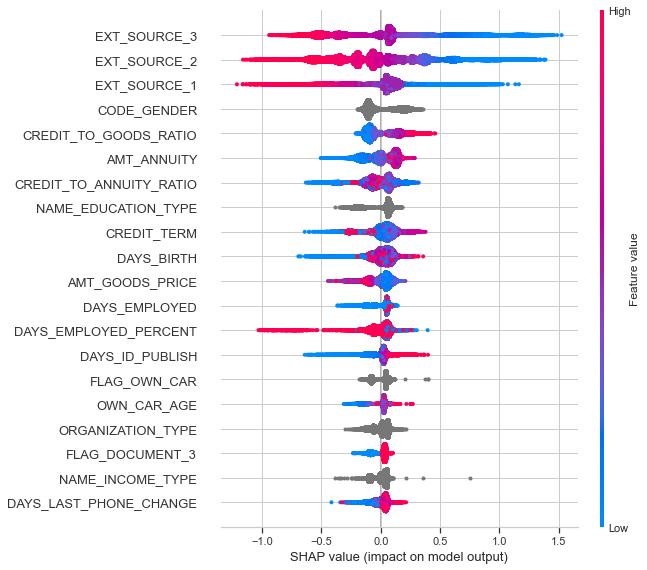

In [93]:
# Строим график

shap.summary_plot(shap_values, X_importance)

Из графика видим, чем меньше доходы клиента, тем выше шанс дефолта и наоборот. Или, например, посмотрим на строку опыта работы. Чем меньше опыт работы, тем выше шанс дефолта по кредиту.

# Выводы

## Смотрим на самые значимые фичи в разрезе таргета

In [94]:
appl_train.groupby('TARGET')['CREDIT_TO_ANNUITY_RATIO'].mean()

TARGET
0    21.686680
1    20.764818
Name: CREDIT_TO_ANNUITY_RATIO, dtype: float64

In [95]:
appl_train.groupby('TARGET')['DAYS_EMPLOYED_PERCENT'].mean()

TARGET
0   -3.003022
1   -1.976284
Name: DAYS_EMPLOYED_PERCENT, dtype: float64

In [96]:
appl_train.groupby('TARGET')['EXT_SOURCE_3'].mean()

TARGET
0    0.523767
1    0.423775
Name: EXT_SOURCE_3, dtype: float64

In [97]:
appl_train.groupby('TARGET')['EXT_SOURCE_2'].mean()

TARGET
0    0.52357
1    0.41126
Name: EXT_SOURCE_2, dtype: float64

In [98]:
appl_train.groupby('TARGET')['CREDIT_TERM'].mean()

TARGET
0    0.053610
1    0.054659
Name: CREDIT_TERM, dtype: float64

In [99]:
abs(appl_train.groupby('TARGET')['DAYS_BIRTH'].mean() / 365)

TARGET
0    0.121135
1    0.111727
Name: DAYS_BIRTH, dtype: float64

In [100]:
appl_train.groupby('TARGET')['AMT_GOODS_PRICE'].mean()

TARGET
0    542652.484651
1    488939.444955
Name: AMT_GOODS_PRICE, dtype: float64

Тут видим обратную зависимость. Большинство клиентов, кто допустил просрочку, брали кредиты на меньшие суммы нежели те, кто платил вовремя

In [101]:
(appl_train.groupby(['TARGET', 'CODE_GENDER'])['CODE_GENDER'].count(
) / appl_train['CODE_GENDER'].count()) * 100

TARGET  CODE_GENDER
0       F              61.226428
        M              30.699390
        XNA             0.001301
1       F               4.607965
        M               3.464917
Name: CODE_GENDER, dtype: float64

In [102]:
(appl_train.groupby(['TARGET', 'NAME_EDUCATION_TYPE'])['NAME_EDUCATION_TYPE'].count(
) / appl_train['NAME_EDUCATION_TYPE'].count()) * 100

TARGET  NAME_EDUCATION_TYPE          
0       Academic degree                   0.052356
        Higher education                 23.041127
        Incomplete higher                 3.058427
        Lower secondary                   1.105326
        Secondary / secondary special    64.669882
1       Academic degree                   0.000976
        Higher education                  1.303693
        Incomplete higher                 0.283567
        Lower secondary                   0.135605
        Secondary / secondary special     6.349041
Name: NAME_EDUCATION_TYPE, dtype: float64

Изначально, были выдвинуты данные гипотезы:

- 1) Большинство людей, кто допускает просрочку, работают на низкой должности. 
- 2) Если человек живет в городе с низким рейтингом (маленький город, низкий уровень жизни и т.д), риск просрочки платежа увеличивается
- 3) Клиент со средним образованием будет чаще допускать просрочку, нежели клиент с высшим образованием

После EDA анализа, а так же построения таблицы с наиболее важными для модели фичами можно подтвердить 1 и 3 гипотезы. Теперь выведем итог по самым важным фичам для неблагонадежного клиента, который может допустить просрочку выплаты по кредиту и тем самым заставить нас создать резервы под его займ, а так же благонадежного клиента, который будет платить в срок: 

TARGET = 0:

Образование - среднее / среднее специальное, средний доход на 20% больше, чем у клиентов с target=1. Средний возраст на ~ 4 года больше. Самое главное - среди не допускающие просрочку, женщин в два раза больше, чем мужчин.

TARGET = 1:

Образование - среднее / среднее специальное, средний доход на 20% меньше, чем у кслиентов с target=0. Средний возраст около 40 лет. Женщин, допустивших просрочку платежа все же больше, но если в target=1 женщин, не допускавших ее, было в 2 раза больше, то теперь лишь на 25%. Из чего делаем вывод - мужчины чаще не платят в срок.